# Time Series Analysis of Seoul's Air Pollution Final Notebook

Breakdown of Notebook
#### 1) Business Problem 
#### 2) Open Data and Imports 
#### 3) Filtering 
#### 4) Feature Engineering
#### 5) Modeling Over Top 5 Stations of Each Pollutant 
#### 6) Visualizations

# 1. Business Problem 

Seoul, South Korea is one of the most polluted cities in the developed world, ranking [3rd](https://www.ft.com/content/b49a9878-141b-11e7-80f4-13e067d5072c) highest daily average as of 2017. Additionally, Seoul has reached PM2.5 levels which is [two times](https://smartairfilters.com/en/blog/air-quality-seoul-pollution/) the annual limit that the WHO recommends. 

This project analyses a series of time series models to provide insight to the South Korean Ministry of Health and Welfare, which is responsible for public health, to pinpoint what areas have the worst PM2.5, PM10, and NO2 levels that can lead to detrimental long term health effects to citizens across all districts of Seoul. Furthermore, this project investigates what could have caused these high levels of air pollution and what can be done to protect the public's health from these air pollutants. Looking at the root mean squared error of every station of Seoul to see within what range my models can predict bad pollutants in specific districts.

# 2. Open Data and Imports 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import  ARIMA
from sklearn.metrics import mean_squared_error
import geopandas
%matplotlib inline 

In [2]:
raw_df = pd.read_csv('Seoul.csv')
df_measurements = pd.read_csv('Measurement_info.csv')
df_station = pd.read_csv('Measurement_station_info.csv')
shanghi_weather = pd.read_csv('Shanghai AQI and Weather.csv')
shanghi_air = pd.read_csv('shanghai-air-quality.csv', index_col=False)
ranking = pd.read_csv('ranking.csv')
gdf = geopandas.read_file('Seoul')

In [3]:
raw_df.head()

Measurement date  Station code  \
0  2017-01-01 00:00           101   
1  2017-01-01 01:00           101   
2  2017-01-01 02:00           101   
3  2017-01-01 03:00           101   
4  2017-01-01 04:00           101   

                                             Address   Latitude   Longitude  \
0  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005007   
1  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005007   
2  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005007   
3  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005007   
4  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005007   

     SO2    NO2     O3   CO  PM10  PM2.5  
0  0.004  0.059  0.002  1.2  73.0   57.0  
1  0.004  0.058  0.002  1.2  71.0   59.0  
2  0.004  0.056  0.002  1.2  70.0   59.0  
3  0.004  0.056  0.002  1.2  70.0   58.0  
4  0.003  0.051  0.002  1.2  69.0   61.0

##### This is a general indication of what levels of certain pollutants are the worst. 

In [4]:
df_measurements

Item code Item name Unit of measurement  Good(Blue)  Normal(Green)  \
0          1       SO2                 ppm        0.02           0.05   
1          3       NO2                 ppm        0.03           0.06   
2          5        CO                 ppm        2.00           9.00   
3          6        O3                 ppm        0.03           0.09   
4          8      PM10       Mircrogram/m3       30.00          80.00   
5          9     PM2.5       Mircrogram/m3       15.00          35.00   

   Bad(Yellow)  Very bad(Red)  
0         0.15            1.0  
1         0.20            2.0  
2        15.00           50.0  
3         0.15            0.5  
4       150.00          600.0  
5        75.00          500.0

##### Station based on every district of Seoul 

In [5]:
df_station

Station code Station name(district)  \
0            101              Jongno-gu   
1            102                Jung-gu   
2            103             Yongsan-gu   
3            104           Eunpyeong-gu   
4            105           Seodaemun-gu   
5            106                Mapo-gu   
6            107           Seongdong-gu   
7            108            Gwangjin-gu   
8            109          Dongdaemun-gu   
9            110            Jungnang-gu   
10           111            Seongbuk-gu   
11           112             Gangbuk-gu   
12           113              Dobong-gu   
13           114               Nowon-gu   
14           115           Yangcheon-gu   
15           116             Gangseo-gu   
16           117                Guro-gu   
17           118           Geumcheon-gu   
18           119        Yeongdeungpo-gu   
19           120             Dongjak-gu   
20           121              Gwanak-gu   
21           122              Seocho-gu   
22           123             Gangnam-gu   
23           124              Songpa-gu   
24           125            Gangdong-gu   

                                              Address   Latitude   Longitude  
0   19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008  
1   15, Deoksugung-gil, Jung-gu, Seoul, Republic o...  37.564263  126.974676  
2   136, Hannam-daero, Yongsan-gu, Seoul, Republic...  37.540033  127.004850  
3   215, Jinheung-ro, Eunpyeong-gu, Seoul, Republi...  37.609823  126.934848  
4   32, Segeomjeong-ro 4-gil, Seodaemun-gu, Seoul,...  37.593742  126.949679  
5   10, Poeun-ro 6-gil, Mapo-gu, Seoul, Republic o...  37.555580  126.905597  
6   18, Ttukseom-ro 3-gil, Seongdong-gu, Seoul, Re...  37.541864  127.049659  
7   571, Gwangnaru-ro, Gwangjin-gu, Seoul, Republi...  37.547180  127.092493  
8   43, Cheonho-daero 13-gil, Dongdaemun-gu, Seoul...  37.575743  127.028885  
9   369, Yongmasan-ro, Jungnang-gu, Seoul, Republi...  37.584848  127.094023  
10  70, Samyang-ro 2-gil, Seongbuk-gu, Seoul, Repu...  37.606719  127.027279  
11  49, Samyang-ro 139-gil, Gangbuk-gu, Seoul, Rep...  37.647930  127.011952  
12  34, Sirubong-ro 2-gil, Dobong-gu, Seoul, Repub...  37.654192  127.029088  
13  17, Sanggye-ro 23-gil, Nowon-gu, Seoul, Republ...  37.658774  127.068505  
14  56, Jungang-ro 52-gil, Yangcheon-gu, Seoul, Re...  37.525939  126.856603  
15  71, Gangseo-ro 45da-gil, Gangseo-gu, Seoul, Re...  37.544640  126.835151  
16  45, Gamasan-ro 27-gil, Guro-gu, Seoul, Republi...  37.498498  126.889692  
17  20, Geumha-ro 21-gil, Geumcheon-gu, Seoul, Rep...  37.452357  126.908296  
18  11, Yangsan-ro 23-gil, Yeongdeungpo-gu, Seoul,...  37.525007  126.897370  
19  6, Sadang-ro 16a-gil, Dongjak-gu, Seoul, Repub...  37.480917  126.971481  
20  14, Sillimdong-gil, Gwanak-gu, Seoul, Republic...  37.487355  126.927102  
21  16, Sinbanpo-ro 15-gil, Seocho-gu, Seoul, Repu...  37.504547  126.994458  
22  426, Hakdong-ro, Gangnam-gu, Seoul, Republic o...  37.517528  127.047470  
23  236, Baekjegobun-ro, Songpa-gu, Seoul, Republi...  37.502686  127.092509  
24  59, Gucheonmyeon-ro 42-gil, Gangdong-gu, Seoul...  37.544962  127.136792

###### Weather Data on Shanghai to see how it may affect air pollution in Seoul 

In [6]:
shanghi_weather.head()

date  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0  2014-01-01      15.0       5.0           0.0      8.7      4.0   
1  2014-01-02      14.0       7.0           0.0      8.7      4.0   
2  2014-01-03      16.0       9.0           0.0      8.7      4.0   
3  2014-01-04      10.0       4.0           0.0      5.5      2.0   
4  2014-01-05      10.0       3.0           0.0      8.7      3.0   

   moon_illumination  DewPointC  FeelsLikeC  HeatIndexC  ...  cloudcover  \
0                0.0       -1.0        11.0        12.0  ...         0.0   
1                2.0        4.0        11.0        13.0  ...         3.0   
2               10.0        3.0        11.0        12.0  ...        26.0   
3               17.0        3.0         7.0         9.0  ...        24.0   
4               24.0        3.0         9.0         9.0  ...        12.0   

   humidity  precipMM  pressure  tempC  visibility  winddirDegree  \
0      43.0       0.0    1021.0   15.0        10.0          242.0   
1      60.0       0.0    1019.0   14.0        10.0          141.0   
2      55.0       0.0    1017.0   16.0        10.0          295.0   
3      68.0       0.1    1022.0   10.0        10.0          169.0   
4      66.0       0.0    1024.0   10.0        10.0          117.0   

   windspeedKmph    AQI  AQI_Explained  
0           12.0  319.0      Hazardous  
1           14.0  352.0      Hazardous  
2           14.0  338.0      Hazardous  
3           14.0  355.0      Hazardous  
4            6.0  343.0      Hazardous  

[5 rows x 22 columns]

##### Air quality data on Shanghai to see how certain increases in specific pollutes could affect Seoul 

In [7]:
shanghi_air.head()

date  pm25  pm10   o3  no2  so2   co
0  2021/1/5    76    43   28   13    1    6
1  2021/1/6    98    41   23   15    2    7
2  2021/1/7   101    60   20    9    2    7
3  2021/1/8    81    46   19   13    3    9
4  2021/1/9    80    57   20   24    4   10

###### Below is a ranking of what pollutants are the highest across all stations. I based this on every pollutant and how often it reached levels of 'Bad' and 'Very Bad'. 

In [8]:
ranking = ranking.drop('Unnamed: 0', axis = 1)
ranking

Station   PM10_Bad  PM2.5_Bad  NO2_Bad
0        113        93        250        8
1        104        74        202       11
2        109        65        173       37
3        120        61        206       27
4        118        60        205       22
5        117       151        319        2
6        101        50        160       24
7        112        67        158       10
8        110        68        172        7
9        123        61        202       10
10       116        80        173       26
11       102        52        159       21
12       125        98        200       17
13       108        99        307       15
14       106       112        310       15
15       121       104        281       49
16       122       161        302        4
17       111        89        183       26
18       114        62        194       18
19       124       101        200       18
20       107       126        222        9
21       105        84        200        4
22       115        76        233       29
23       119       131         52       10
24       103        46        184       12

# 3. Filtering 

#### Testing every station that falls in the top 5 category of one of the three pollutants, then modeling over the pollutant in that specific station. 

In [9]:
ranking['PM10_Bad'].nlargest(5)

16    161
5     151
23    131
20    126
14    112
Name: PM10_Bad, dtype: int64

###### Here we see that PM10 is the worst in stations 122, 117, 119, 107, and 106. We will be looking to model those top 5. 

In [10]:
ranking['PM2.5_Bad'].nlargest(5)

5     319
14    310
13    307
16    302
15    281
Name: PM2.5_Bad, dtype: int64

##### Here we see that PM2.5 is the worst in stations 117, 112, 108, 122, and 121. We will be looking to model those top 5.

In [11]:
ranking['NO2_Bad'].nlargest(5)

15    49
2     37
22    29
3     27
10    26
Name: NO2_Bad, dtype: int64

###### Here we see that NO2 is the worst in stations 121, 109, 115, 120, and 116. We will be looking to model those top 5.

# 4. Feature Engineering

##### Cutting down to look at the daily average and creating a df that looks at every station and date seperatley 

In [12]:
raw_df['Measurement date'] = raw_df['Measurement date'].str.slice(0, 11)
df = raw_df.groupby(['Station code', 'Measurement date']).aggregate({'SO2': 'mean', 'NO2':'mean', 'O3':'mean', 'CO':'mean', 'PM10':'mean', 'PM2.5':'mean'})

##### Functions Relevant for Creating New Columns:

##### NO2 Level

In [13]:
def NO2Level(x):
    if x <= 0.03:
        return "Good"
    elif 0.03 < x <= 0.06:
        return "Normal"
    elif 0.06 < x <= 0.2:
        return "Bad"
    elif 0.2 < x <= 2.0:
        return "Very Bad"
df['NO2 Level'] = df.apply(lambda row: NO2Level(row.NO2), axis=1) 

##### What is NO2?


- [NO2](https://www.epa.gov/no2-pollution/basic-information-about-no2) is a gas representative of the larger group of nitrogen oxides, mainly known to be a highly reactive gas. NO2 comes from emissions from automotive vehicles, and power plants. breathing in air with high levels of NO2 can lead to irritation of the lungs, and can permanently damage the respiratory system long term.  



##### PM10 Level

In [14]:
def PM10Level(x):
    if x <= 30:
        return "Good"
    elif 30 < x <= 80:
        return "Normal"
    elif 80 < x <= 150:
        return "Bad"
    elif 150 < x <= 600:
        return "Very Bad"
df['PM10 Level'] = df.apply(lambda row: PM10Level(row.PM10), axis=1)

##### PM2.5 Level

In [15]:
def PM25Level(x):
    if x <= 15:
        return "Good"
    elif 15 < x <= 35:
        return "Normal"
    elif 35 < x <= 75:
        return "Bad"
    elif 75 < x <= 500:
        return "Very Bad"
df['PM2.5 Level'] = df.apply(lambda row: PM25Level(row['PM2.5']), axis=1)

##### What is PM10 & PM2.5?

[According](https://www.epa.gov/pm-pollution/particulate-matter-pm-basics) to United States Enviromental Protection (EPA) Agency: 

"PM stands for particulate matter (also called particle pollution): the term for a mixture of solid particles and liquid droplets found in the air. Some particles, such as dust, dirt, soot, or smoke, are large or dark enough to be seen with the naked eye. Others are so small they can only be detected using an electron microscope.

Particle pollution includes:

- PM10 : inhalable particles, with diameters that are generally 10 micrometers and smaller; and
- PM2.5 : fine inhalable particles, with diameters that are generally 2.5 micrometers and smaller.

##### Some are emitted directly from a source, such as construction sites, unpaved roads, fields, smokestacks or fires.

Most particles form in the atmosphere as a result of complex reactions of chemicals such as sulfur dioxide and nitrogen oxides, which are pollutants emitted from power plants, industries and automobiles.

# New DataFrame

In [16]:
df

SO2       NO2        O3        CO  \
Station code Measurement date                                           
101          2017-01-01        0.004208  0.054250  0.003125  1.029167   
             2017-01-02        0.004792  0.046250  0.016375  1.020833   
             2017-01-03        0.004833  0.046750  0.013875  0.833333   
             2017-01-04        0.005375  0.058167  0.008750  0.991667   
             2017-01-05        0.004333  0.041333  0.011000  0.620833   
...                                 ...       ...       ...       ...   
125          2019-12-27        0.002958  0.031667  0.015708  0.562500   
             2019-12-28        0.003292  0.043417  0.005667  0.612500   
             2019-12-29        0.003125  0.036833  0.007958  0.591667   
             2019-12-30        0.002958  0.030792  0.012083  0.591667   
             2019-12-31        0.002875  0.019542  0.018542  0.416667   

                                     PM10      PM2.5 NO2 Level PM10 Level  \
Station code Measurement date                                               
101          2017-01-01         81.666667  67.291667    Normal        Bad   
             2017-01-02        112.166667  87.166667    Normal        Bad   
             2017-01-03         72.916667  51.833333    Normal     Normal   
             2017-01-04         51.125000  34.916667    Normal     Normal   
             2017-01-05         34.875000  21.958333    Normal     Normal   
...                                   ...        ...       ...        ...   
125          2019-12-27         41.083333  30.125000    Normal     Normal   
             2019-12-28         49.375000  31.291667    Normal     Normal   
             2019-12-29         49.791667  33.666667    Normal     Normal   
             2019-12-30         46.125000  35.250000    Normal     Normal   
             2019-12-31         27.458333  19.291667      Good       Good   

                              PM2.5 Level  
Station code Measurement date              
101          2017-01-01               Bad  
             2017-01-02          Very Bad  
             2017-01-03               Bad  
             2017-01-04            Normal  
             2017-01-05            Normal  
...                                   ...  
125          2019-12-27            Normal  
             2019-12-28            Normal  
             2019-12-29            Normal  
             2019-12-30               Bad  
             2019-12-31            Normal  

[27125 rows x 9 columns]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27125 entries, (101, '2017-01-01 ') to (125, '2019-12-31 ')
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SO2          27125 non-null  float64
 1   NO2          27125 non-null  float64
 2   O3           27125 non-null  float64
 3   CO           27125 non-null  float64
 4   PM10         27125 non-null  float64
 5   PM2.5        27125 non-null  float64
 6   NO2 Level    27123 non-null  object 
 7   PM10 Level   27109 non-null  object 
 8   PM2.5 Level  27117 non-null  object 
dtypes: float64(6), object(3)
memory usage: 1.9+ MB


##### Reset Index

In [18]:
df = df.reset_index()

In [19]:
df['Measurement date'] = pd.to_datetime(df['Measurement date'])
df.set_index(df['Measurement date'], inplace=True)
df = df.drop('Measurement date', axis=1)
df

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 101  0.004208  0.054250  0.003125  1.029167   
2017-01-02                 101  0.004792  0.046250  0.016375  1.020833   
2017-01-03                 101  0.004833  0.046750  0.013875  0.833333   
2017-01-04                 101  0.005375  0.058167  0.008750  0.991667   
2017-01-05                 101  0.004333  0.041333  0.011000  0.620833   
...                        ...       ...       ...       ...       ...   
2019-12-27                 125  0.002958  0.031667  0.015708  0.562500   
2019-12-28                 125  0.003292  0.043417  0.005667  0.612500   
2019-12-29                 125  0.003125  0.036833  0.007958  0.591667   
2019-12-30                 125  0.002958  0.030792  0.012083  0.591667   
2019-12-31                 125  0.002875  0.019542  0.018542  0.416667   

                        PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                          
2017-01-01         81.666667  67.291667    Normal        Bad         Bad  
2017-01-02        112.166667  87.166667    Normal        Bad    Very Bad  
2017-01-03         72.916667  51.833333    Normal     Normal         Bad  
2017-01-04         51.125000  34.916667    Normal     Normal      Normal  
2017-01-05         34.875000  21.958333    Normal     Normal      Normal  
...                      ...        ...       ...        ...         ...  
2019-12-27         41.083333  30.125000    Normal     Normal      Normal  
2019-12-28         49.375000  31.291667    Normal     Normal      Normal  
2019-12-29         49.791667  33.666667    Normal     Normal      Normal  
2019-12-30         46.125000  35.250000    Normal     Normal         Bad  
2019-12-31         27.458333  19.291667      Good       Good      Normal  

[27125 rows x 10 columns]

#### Relevant functions 

In [20]:
def arima_results(endog, test, order=[0,0,0]):
    arima = ARIMA(endog, order=order).fit()
    
    train_hat = arima.predict()
    
    rmse_train = mean_squared_error(endog,
                                    train_hat,
                                    squared=False)
    
    
    rmse_test = mean_squared_error(test,
                                   arima.predict(), 
                                   squared=False)
    
 
    print(f"""Train RMSE: {rmse_train}""")     
    print(f"""Test RMSE: {rmse_test}""")    
    print(f"""Summary: {arima.summary()}""")
    
    return sm

In [21]:
def stationarity_check(df):     
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

In [22]:
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

In [23]:
def plotarima(n_periods, timeseries, automodel):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, 
                                    return_conf_int=True)
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, 
                           freq="W")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper left")
    plt.show()

# 5. Modeling Over Top 5 Stations of Each Pollutant 

### Station 106

In [24]:
df_106 = df[df['Station code'] == 106]

In [25]:
df_106.head()

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 106  0.004792  0.054917  0.004083  1.162500   
2017-01-02                 106  0.005167  0.045500  0.014500  1.070833   
2017-01-03                 106  0.005083  0.048125  0.012458  0.900000   
2017-01-04                 106  0.005125  0.058458  0.009000  1.041667   
2017-01-05                 106  0.003917  0.041875  0.011000  0.750000   

                        PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                          
2017-01-01         76.083333  68.000000    Normal     Normal         Bad  
2017-01-02        103.333333  91.041667    Normal        Bad    Very Bad  
2017-01-03         66.375000  54.708333    Normal     Normal         Bad  
2017-01-04         49.125000  39.500000    Normal     Normal         Bad  
2017-01-05         31.750000  24.250000    Normal     Normal      Normal

<AxesSubplot:xlabel='Year, Day', ylabel='PM10'>

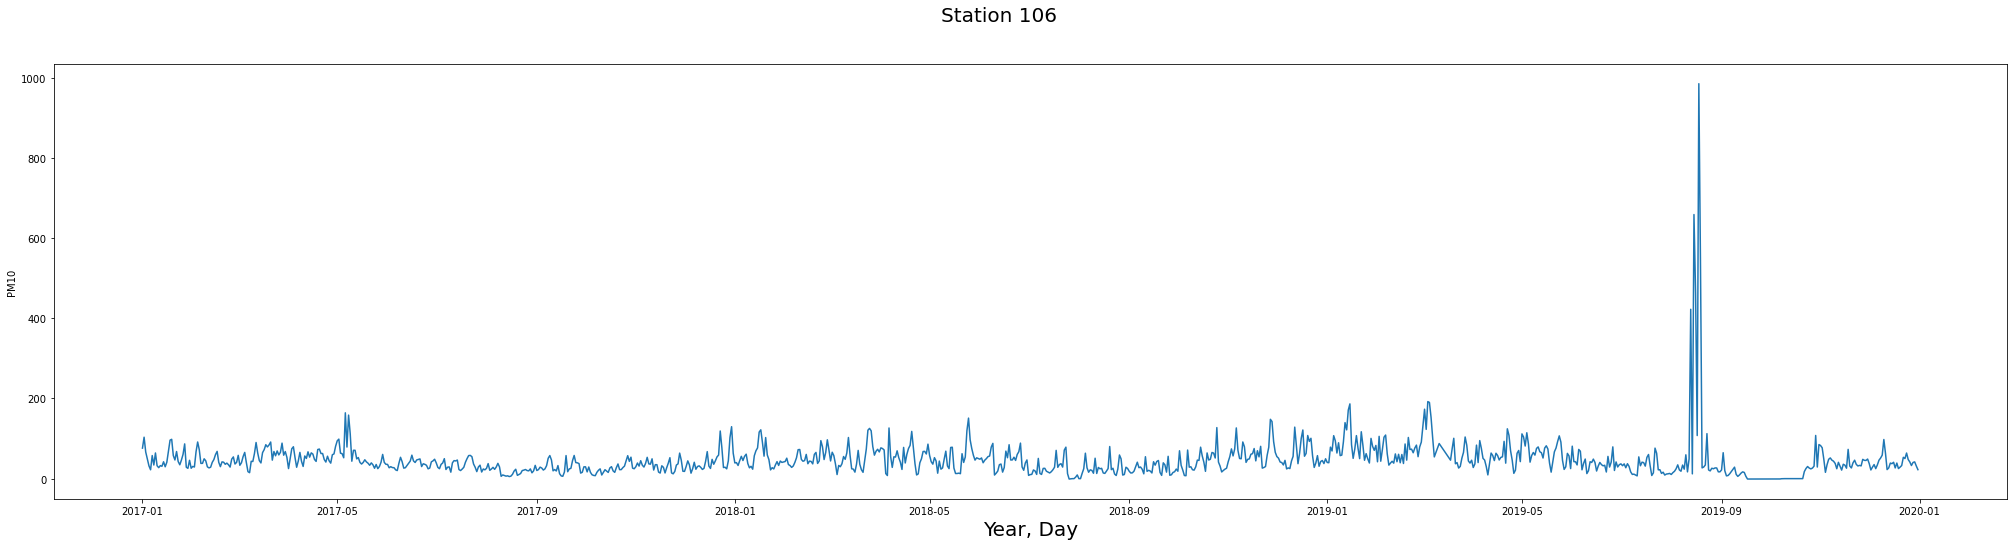

In [26]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 106", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='PM10', data=df_106)

In [27]:
df_106['PM10 Level'].value_counts()

Normal      585
Good        386
Bad         100
Very Bad     12
Name: PM10 Level, dtype: int64

#### For Station 106
- PM10 reaches levels of 'Bad' on 100 occasions and 'Very Bad' on 12 occasions, and gets close to 'Bad' on many occasions.


In [28]:
columns = ['PM10']
df_106 = df_106[columns]
df_106

PM10
Measurement date            
2017-01-01         76.083333
2017-01-02        103.333333
2017-01-03         66.375000
2017-01-04         49.125000
2017-01-05         31.750000
...                      ...
2019-12-27         32.708333
2019-12-28         40.416667
2019-12-29         41.750000
2019-12-30         31.583333
2019-12-31         22.375000

[1085 rows x 1 columns]

In [29]:
train = df_106[:-542]
test = df_106[542:]

<AxesSubplot:xlabel='Measurement date'>

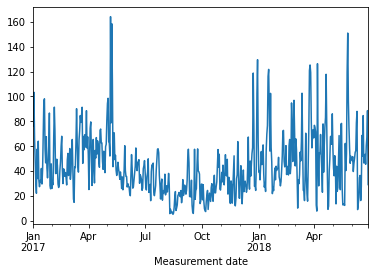

In [30]:
train['PM10'].plot()

<AxesSubplot:xlabel='Measurement date'>

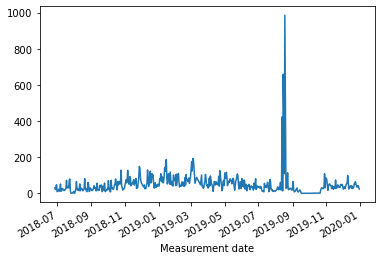

In [31]:
test['PM10'].plot()

### Rolling Mean Difference Train

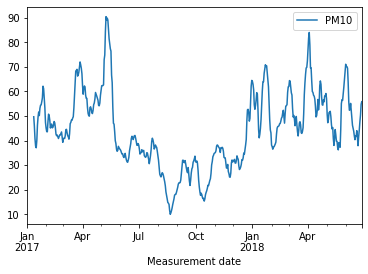

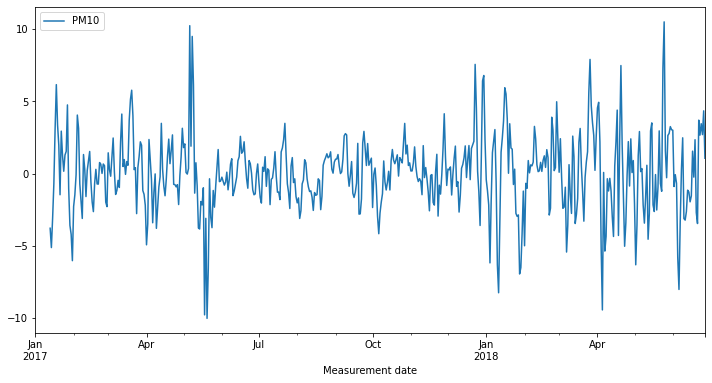

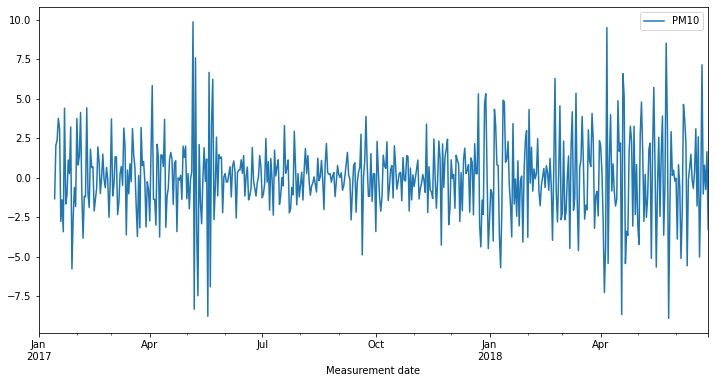

In [32]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_train = train.rolling(window=12).mean()
roll_mean_train.plot();

rm_diff_1 = roll_mean_train.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_train.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [33]:
print(stationarity_check(df_106['PM10']))
print(stationarity_check(rm_diff_1['PM10'].dropna()))
print(stationarity_check(rm_diff_2['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -8.125068e+00
p-value                        1.128928e-12
#Lags Used                     8.000000e+00
Number of Observations Used    1.076000e+03
Critical Value (1%)           -3.436442e+00
Critical Value (5%)           -2.864230e+00
Critical Value (10%)          -2.568202e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -8.494158e+00
p-value                        1.289359e-13
#Lags Used                     1.200000e+01
Number of Observations Used    5.180000e+02
Critical Value (1%)           -3.443037e+00
Critical Value (5%)           -2.867136e+00
Critical Value (10%)          -2.569750e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -9.863519e+00
p-value                        4.172144e-17
#Lags Used                     1.700000e+01
Number of Observations Used    5.120000e+02
Critical Value (1%)           -3.443187e+00
Critical Value (5%)      

### Rolling Mean Difference Test

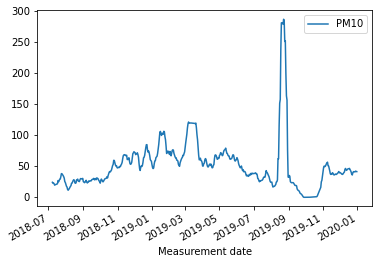

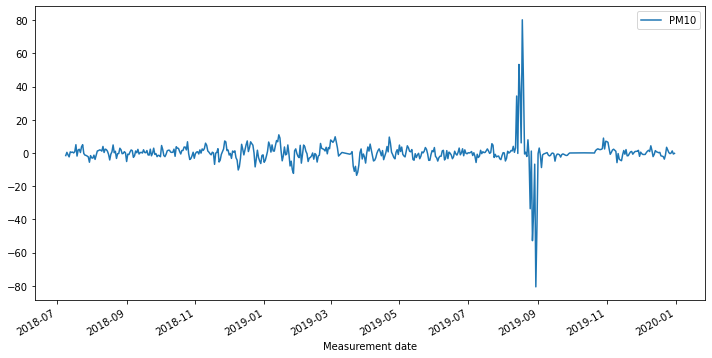

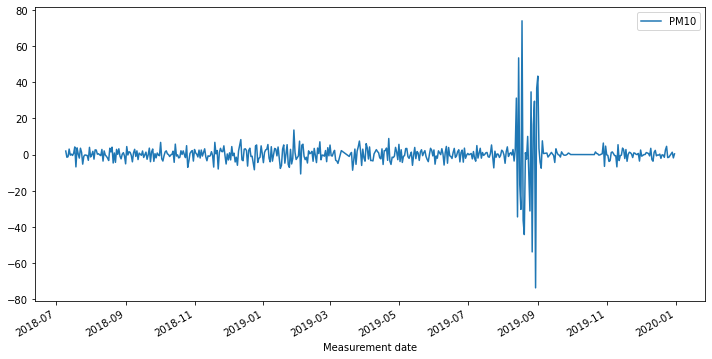

In [34]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_test = test.rolling(window=12).mean()
roll_mean_test.plot();

rm_diff_1 = roll_mean_test.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_test.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [35]:
print(stationarity_check(rm_diff_1['PM10'].dropna()))
print(stationarity_check(rm_diff_2['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -6.285858e+00
p-value                        3.699683e-08
#Lags Used                     1.700000e+01
Number of Observations Used    5.130000e+02
Critical Value (1%)           -3.443162e+00
Critical Value (5%)           -2.867190e+00
Critical Value (10%)          -2.569780e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -8.922238e+00
p-value                        1.033622e-14
#Lags Used                     1.600000e+01
Number of Observations Used    5.130000e+02
Critical Value (1%)           -3.443162e+00
Critical Value (5%)           -2.867190e+00
Critical Value (10%)          -2.569780e+00
dtype: float64
None


### Station 106 PM10

In [36]:
base_model = sm.tsa.statespace.SARIMAX(df_106['PM10'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood               -5780.902
Date:                Wed, 27 Oct 2021   AIC                          11565.805
Time:                        16:07:36   BIC                          11575.783
Sample:                             0   HQIC                         11569.582
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0495      1.668     -0.030      0.976      -3.319       3.220
sigma2      2509.8907     14.263    175.967      0.000    2481.935    2537.846
Ljung-Box (L1) (Q):                 170.10   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11247.246, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11563.806, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11381.633, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11248.255, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11145.757, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11191.009, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11134.793, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11181.861, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=11129.073, Time=0.22 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=11147.064, Time=0.04 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=11130.253, Time=0.28 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=11145.037, Time=0.05 sec
 ARIMA(5,0,2)(0,0,0)[0]        

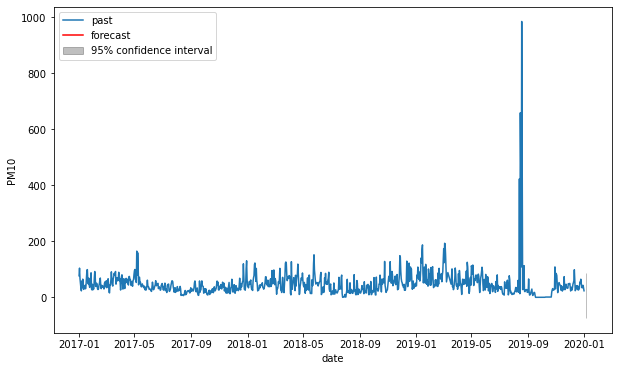

In [37]:
timeseries = df_106['PM10']
automodel = arimamodel(df_106['PM10'].diff().dropna())
plotarima(1, timeseries, automodel)

In [38]:
best_model = sm.tsa.statespace.SARIMAX(df_106['PM10'].diff(), trend='c', order=[4,0,1])
res = best_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1085
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -5558.534
Date:                Wed, 27 Oct 2021   AIC                          11131.069
Time:                        16:07:39   BIC                          11165.994
Sample:                             0   HQIC                         11144.290
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0915      3.191     -0.029      0.977      -6.346       6.163
ar.L1         -1.1431      0.064    -17.963      0.000      -1.268      -1.018
ar.L2         -0.7379      0.032    -23.100      0.0

In [39]:
model_train = arima_results(train['PM10'],test['PM10'], order=[3,0,1])

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Train RMSE: 18.816007519912862
Test RMSE: 70.17326529051837
Summary:                                SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                  543
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -2363.705
Date:                Wed, 27 Oct 2021   AIC                           4739.410
Time:                        16:07:40   BIC                           4765.193
Sample:                    01-01-2017   HQIC                          4749.491
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.6225      7.021      6.498      0.000      31.861      59.384
ar.L1          1.5579      0.040     39.109      0.000       1

# Station 107

In [40]:
df_107 = df[df['Station code'] == 107]

In [41]:
df_107.head()

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 107  0.004500  0.045458  0.002875  0.791667   
2017-01-02                 107  0.005083  0.038042  0.013875  0.666667   
2017-01-03                 107  0.004917  0.045583  0.011208  0.525000   
2017-01-04                 107  0.005208  0.056500  0.006208  0.604167   
2017-01-05                 107  0.004417  0.033125  0.014083  0.450000   

                        PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                          
2017-01-01         76.916667  52.916667    Normal     Normal         Bad  
2017-01-02        111.500000  80.125000    Normal        Bad    Very Bad  
2017-01-03         82.291667  51.875000    Normal        Bad         Bad  
2017-01-04         58.291667  35.458333    Normal     Normal         Bad  
2017-01-05         39.291667  22.833333    Normal     Normal      Normal

<AxesSubplot:xlabel='Year, Day', ylabel='PM10'>

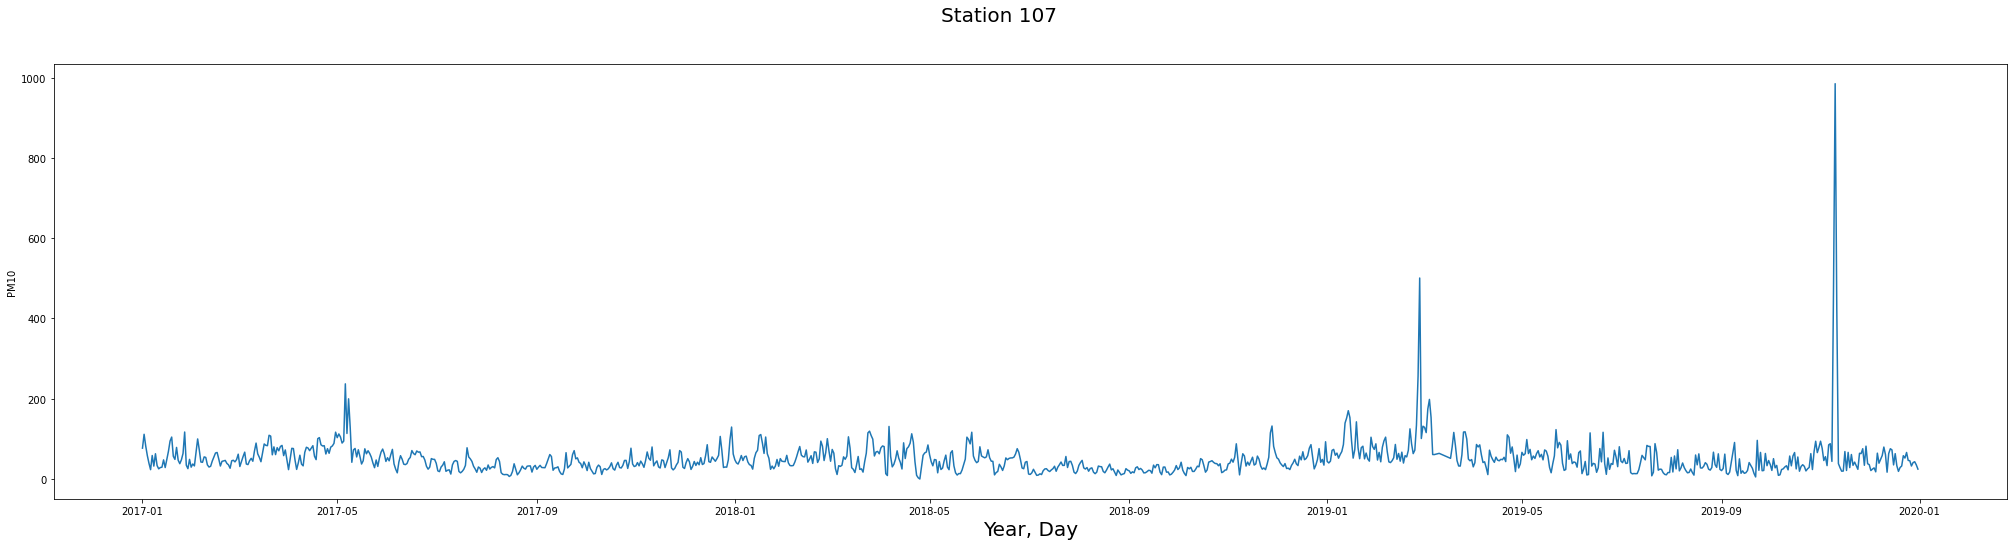

In [42]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 107", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='PM10', data=df_107)

In [43]:
df_107['PM10 Level'].value_counts()

Normal      638
Good        320
Bad         114
Very Bad     12
Name: PM10 Level, dtype: int64

###### For Station 107

- PM10 reaches levels of 'Bad' on 114 occasions and 'Very Bad' on 12, and gets close to bad on many occasions.


#### Picking the relevant columns

In [44]:
columns = ['PM10']
df_107 = df_107[columns]
df_107

PM10
Measurement date            
2017-01-01         76.916667
2017-01-02        111.500000
2017-01-03         82.291667
2017-01-04         58.291667
2017-01-05         39.291667
...                      ...
2019-12-27         32.416667
2019-12-28         40.916667
2019-12-29         43.125000
2019-12-30         35.291667
2019-12-31         24.708333

[1085 rows x 1 columns]

In [45]:
train = df_107[:-542]
test = df_107[542:]

<AxesSubplot:xlabel='Measurement date'>

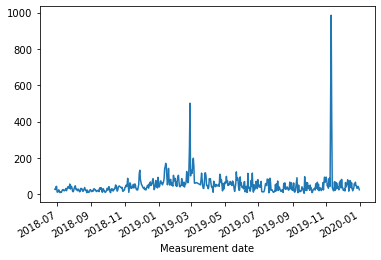

In [46]:
test['PM10'].plot()

<AxesSubplot:xlabel='Measurement date'>

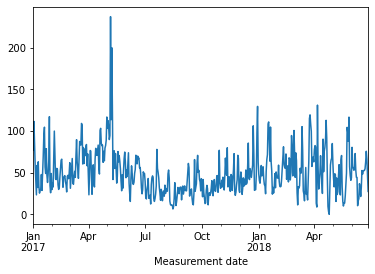

In [47]:
train['PM10'].plot()

#### Rolling Mean Difference Train

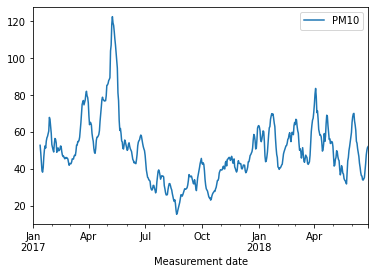

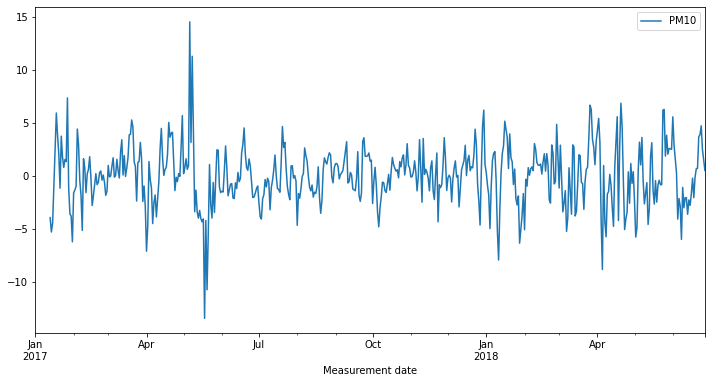

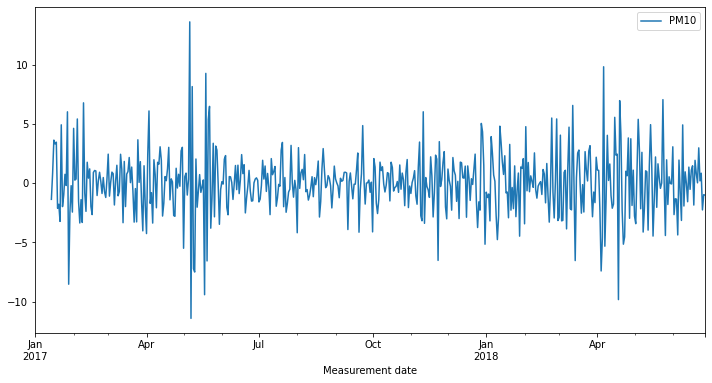

In [48]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_train = train.rolling(window=12).mean()
roll_mean_train.plot();

rm_diff_1 = roll_mean_train.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_train.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [49]:
print(stationarity_check(df_107['PM10']))
print(stationarity_check(rm_diff_1['PM10'].dropna()))
print(stationarity_check(rm_diff_2['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -9.503200e+00
p-value                        3.401381e-16
#Lags Used                     5.000000e+00
Number of Observations Used    1.079000e+03
Critical Value (1%)           -3.436425e+00
Critical Value (5%)           -2.864222e+00
Critical Value (10%)          -2.568198e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -7.881762e+00
p-value                        4.682404e-12
#Lags Used                     1.200000e+01
Number of Observations Used    5.180000e+02
Critical Value (1%)           -3.443037e+00
Critical Value (5%)           -2.867136e+00
Critical Value (10%)          -2.569750e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.083999e+01
p-value                        1.625165e-19
#Lags Used                     1.500000e+01
Number of Observations Used    5.140000e+02
Critical Value (1%)           -3.443136e+00
Critical Value (5%)      

#### Rolling Mean Difference Test

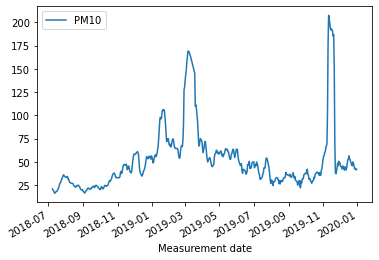

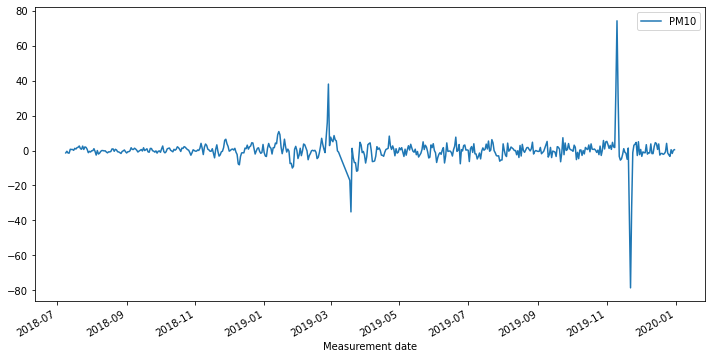

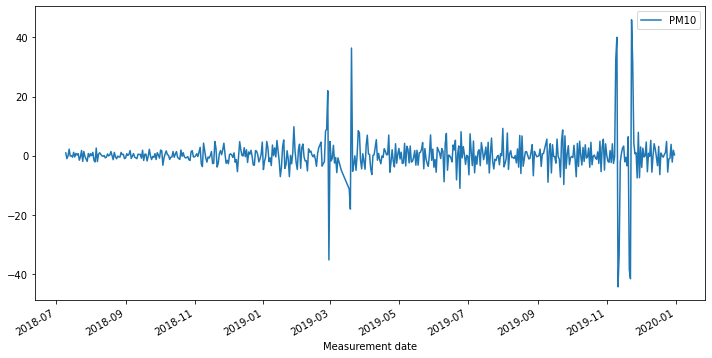

In [50]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_test = test.rolling(window=12).mean()
roll_mean_test.plot();

rm_diff_1 = roll_mean_test.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_test.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));


In [51]:
print(stationarity_check(rm_diff_1['PM10'].dropna()))
print(stationarity_check(rm_diff_2['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -8.059642e+00
p-value                        1.656251e-12
#Lags Used                     1.300000e+01
Number of Observations Used    5.170000e+02
Critical Value (1%)           -3.443062e+00
Critical Value (5%)           -2.867147e+00
Critical Value (10%)          -2.569756e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -9.917139e+00
p-value                        3.058768e-17
#Lags Used                     1.800000e+01
Number of Observations Used    5.110000e+02
Critical Value (1%)           -3.443212e+00
Critical Value (5%)           -2.867213e+00
Critical Value (10%)          -2.569791e+00
dtype: float64
None


#### Station 107 PM10

In [52]:
base_model = sm.tsa.statespace.SARIMAX(df_107['PM10'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood               -5544.039
Date:                Wed, 27 Oct 2021   AIC                          11092.077
Time:                        16:07:41   BIC                          11102.056
Sample:                             0   HQIC                         11095.855
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0482      1.229     -0.039      0.969      -2.457       2.361
sigma2      1621.2888     10.549    153.689      0.000    1600.613    1641.965
Ljung-Box (L1) (Q):                   3.07   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10862.916, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11090.079, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11089.016, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11082.653, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10815.749, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=10973.625, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=10809.149, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=10953.187, Time=0.03 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=10809.808, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=10809.457, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10807.511, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10805.513, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=10833.608, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=10807.511, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0

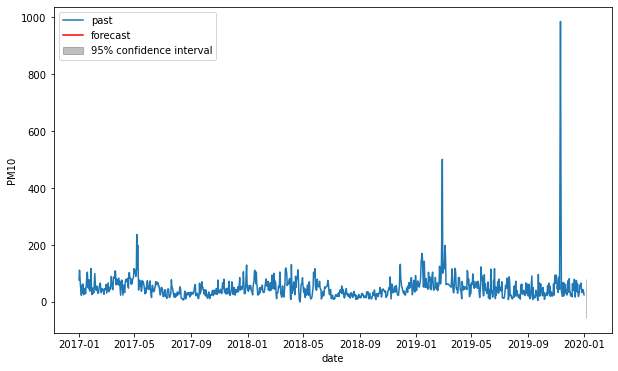

In [53]:
timeseries = df_107['PM10']
automodel = arimamodel(df_107['PM10'].diff().dropna())
plotarima(1, timeseries, automodel)

In [54]:
best_model = sm.tsa.statespace.SARIMAX(df_107['PM10'], trend='c', order=[1,0,2])
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1085
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -5407.201
Date:                Wed, 27 Oct 2021   AIC                          10824.403
Time:                        16:07:43   BIC                          10849.349
Sample:                             0   HQIC                         10833.846
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     18.0553      3.971      4.547      0.000      10.273      25.838
ar.L1          0.6399      0.067      9.583      0.000       0.509       0.771
ma.L1          0.0978      0.065      1.498      0.1

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [55]:
model_train = arima_results(train['PM10'],test['PM10'], order=[2,0,2])

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Train RMSE: 20.05457391305559
Test RMSE: 64.81045786520997
Summary:                                SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                  543
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2398.494
Date:                Wed, 27 Oct 2021   AIC                           4808.989
Time:                        16:07:43   BIC                           4834.771
Sample:                    01-01-2017   HQIC                          4819.070
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0118      6.451      7.753      0.000      37.368      62.655
ar.L1          1.4219      0.082     17.329      0.000       1.

# Station 108

In [56]:
df_108 = df[df['Station code'] == 108]

In [57]:
df_108.head()

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 108  0.004375  0.044542  0.005042  0.812500   
2017-01-02                 108  0.005208  0.044792  0.019208  0.900000   
2017-01-03                 108  0.004875  0.047708  0.015875  0.862500   
2017-01-04                 108  0.006083  0.055833  0.008042  0.945833   
2017-01-05                 108  0.004000  0.033042  0.017125  0.612500   

                        PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                          
2017-01-01         79.708333  71.333333    Normal     Normal         Bad  
2017-01-02        110.750000  95.458333    Normal        Bad    Very Bad  
2017-01-03         85.750000  69.041667    Normal        Bad         Bad  
2017-01-04         55.875000  41.250000    Normal     Normal         Bad  
2017-01-05         32.583333  21.750000    Normal     Normal      Normal

<AxesSubplot:xlabel='Year, Day', ylabel='PM2.5'>

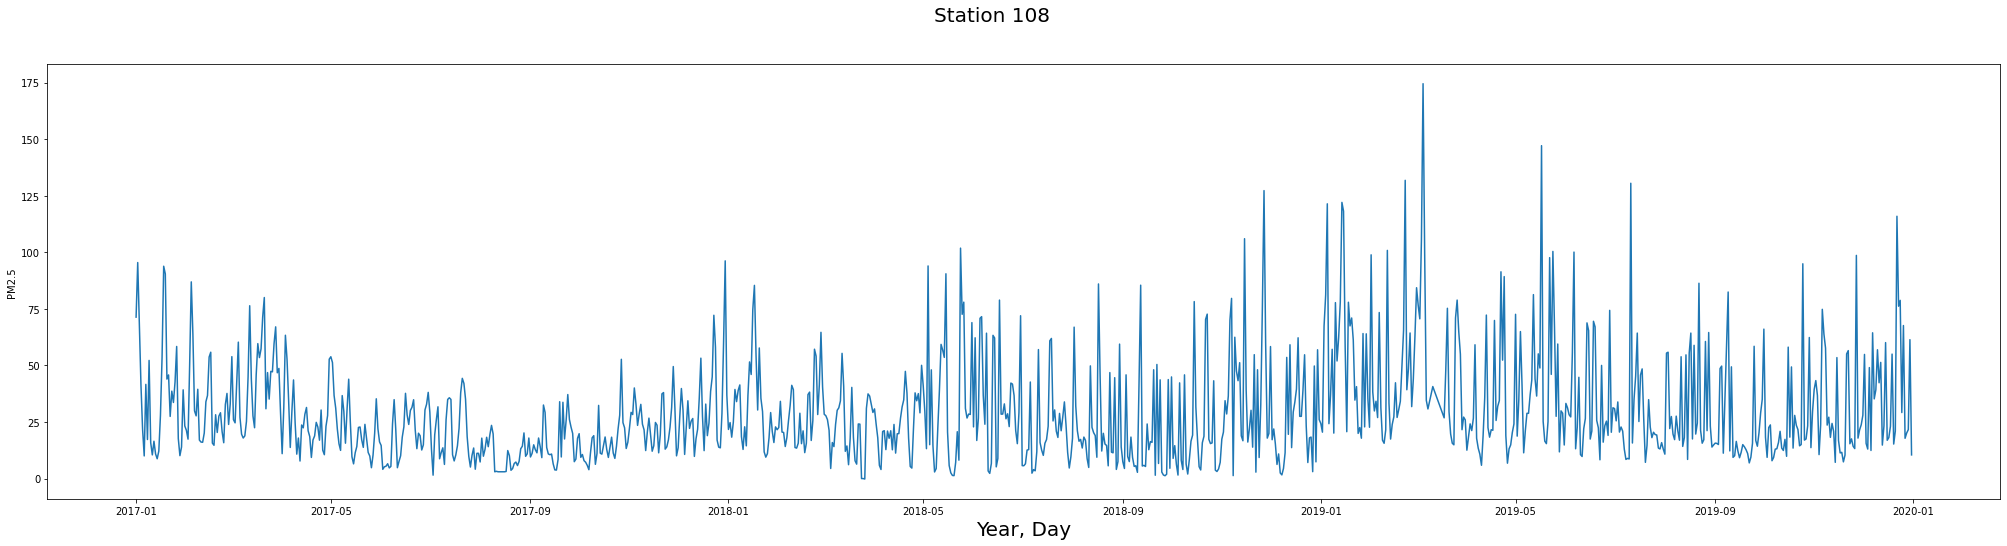

In [58]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 108", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='PM2.5', data=df_108)

In [59]:
df_108['PM2.5 Level'].value_counts()

Normal      467
Good        311
Bad         255
Very Bad     52
Name: PM2.5 Level, dtype: int64

#### For Station 108:
- PM2.5 reaches levels of 'Bad' on 255 occasions and 'Very Bad' on 52 occasions.

#### Picking the relevant columns

In [60]:
columns = ['PM2.5']
df_108 = df_108[columns]
df_108

PM2.5
Measurement date           
2017-01-01        71.333333
2017-01-02        95.458333
2017-01-03        69.041667
2017-01-04        41.250000
2017-01-05        21.750000
...                     ...
2019-12-27        17.791667
2019-12-28        20.125000
2019-12-29        21.625000
2019-12-30        61.375000
2019-12-31        10.458333

[1085 rows x 1 columns]

#### Train-Test Split

In [61]:
train = df_108[:-542]
test = df_108[542:]

<AxesSubplot:xlabel='Measurement date'>

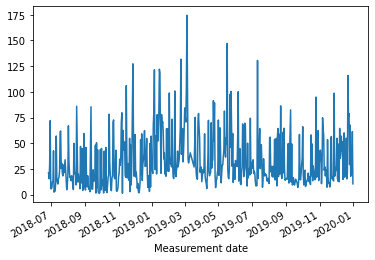

In [62]:
test['PM2.5'].plot()

<AxesSubplot:xlabel='Measurement date'>

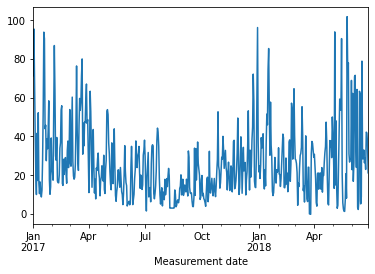

In [63]:
train['PM2.5'].plot()

#### Rolling Mean Difference Train

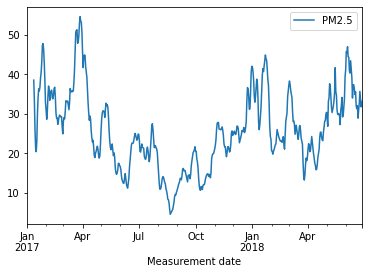

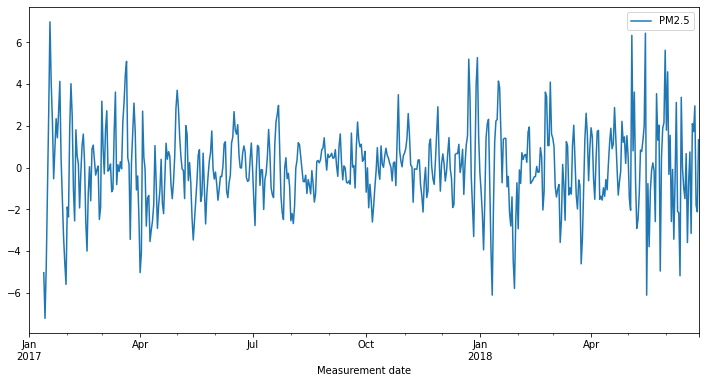

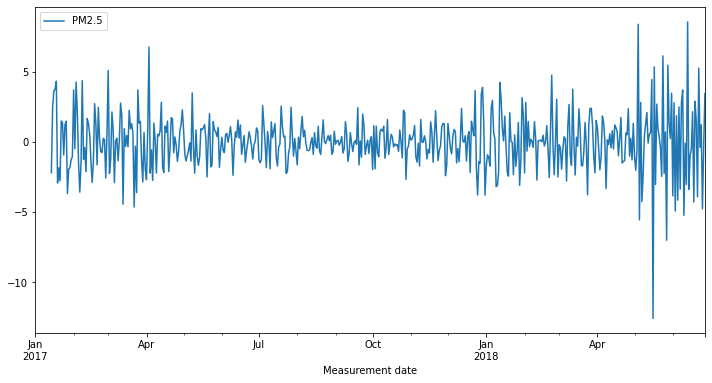

In [64]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_train = train.rolling(window=12).mean()
roll_mean_train.plot();

rm_diff_1 = roll_mean_train.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_train.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

#### Rolling Mean Difference Test

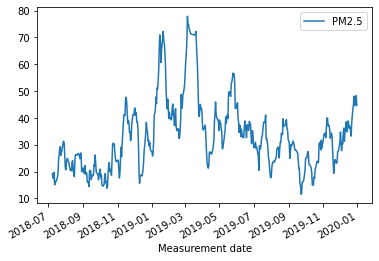

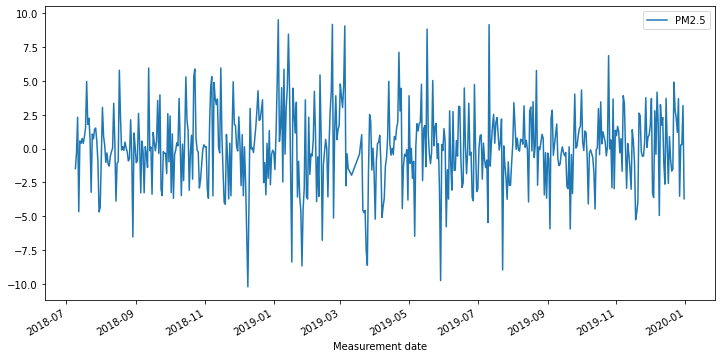

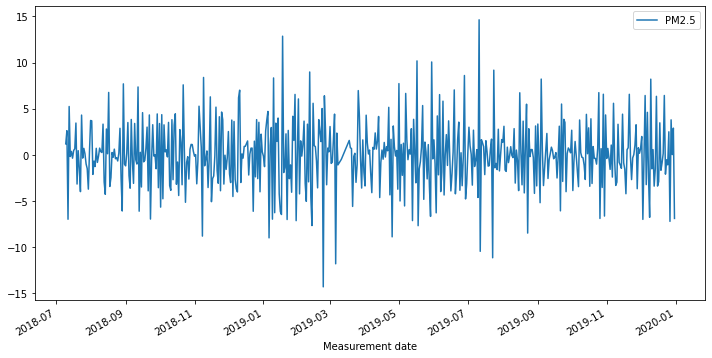

In [65]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_test = test.rolling(window=12).mean()
roll_mean_test.plot();

rm_diff_1 = roll_mean_test.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_test.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [66]:
print(stationarity_check(df_108['PM2.5']))
print(stationarity_check(rm_diff_1['PM2.5'].dropna()))
print(stationarity_check(rm_diff_2['PM2.5'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -5.651316e+00
p-value                        9.845705e-07
#Lags Used                     1.100000e+01
Number of Observations Used    1.073000e+03
Critical Value (1%)           -3.436459e+00
Critical Value (5%)           -2.864237e+00
Critical Value (10%)          -2.568206e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -8.818859e+00
p-value                        1.901315e-14
#Lags Used                     1.200000e+01
Number of Observations Used    5.180000e+02
Critical Value (1%)           -3.443037e+00
Critical Value (5%)           -2.867136e+00
Critical Value (10%)          -2.569750e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.063638e+01
p-value                        5.059769e-19
#Lags Used                     1.600000e+01
Number of Observations Used    5.130000e+02
Critical Value (1%)           -3.443162e+00
Critical Value (5%)      

#### Station 108 PM2.5

In [67]:
base_model = sm.tsa.statespace.SARIMAX(df_108['PM2.5'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood               -5048.657
Date:                Wed, 27 Oct 2021   AIC                          10101.315
Time:                        16:07:45   BIC                          10111.293
Sample:                             0   HQIC                         10105.092
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0562      0.775     -0.072      0.942      -1.575       1.462
sigma2       650.0108     17.841     36.433      0.000     615.042     684.979
Ljung-Box (L1) (Q):                 151.53   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9658.293, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10099.320, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9938.103, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9722.600, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9660.042, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9660.088, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9665.326, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9875.694, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9661.743, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=9660.289, Time=0.14 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.787 seconds


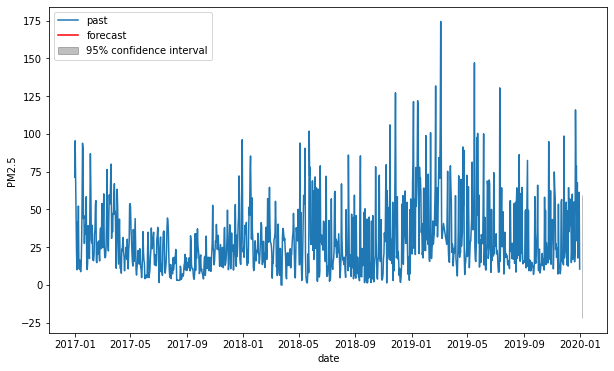

In [68]:
timeseries = df_108['PM2.5']
automodel = arimamodel(df_108['PM2.5'].diff().dropna())
plotarima(1, timeseries, automodel)

In [69]:
best_model = sm.tsa.statespace.SARIMAX(df_108['PM2.5'], trend='c', order=[1,0,1])
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1085
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -4845.315
Date:                Wed, 27 Oct 2021   AIC                           9698.631
Time:                        16:07:46   BIC                           9718.588
Sample:                             0   HQIC                          9706.186
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.0088      1.633      6.128      0.000       6.808      13.210
ar.L1          0.6600      0.051     12.823      0.000       0.559       0.761
ma.L1         -0.3417      0.065     -5.290      0.0

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [70]:
model_train = arima_results(train['PM2.5'],test['PM2.5'], order=[1,0,2])

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Train RMSE: 15.163370590762861
Test RMSE: 29.477219586512895
Summary:                                SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                  543
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2245.625
Date:                Wed, 27 Oct 2021   AIC                           4501.250
Time:                        16:07:46   BIC                           4522.735
Sample:                    01-01-2017   HQIC                          4509.650
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.2849      1.926     13.645      0.000      22.509      30.060
ar.L1          0.4934      0.122      4.060      0.000       

# Station 109

In [71]:
df_109 = df[df['Station code'] == 109]

In [72]:
df_109.head()

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 109  0.005583  0.046292  0.002917  1.016667   
2017-01-02                 109  0.005625  0.039417  0.012250  1.041667   
2017-01-03                 109  0.006042  0.043958  0.010042  0.945833   
2017-01-04                 109  0.006250  0.051583  0.007208  0.995833   
2017-01-05                 109  0.005292  0.040375  0.006667  0.804167   

                        PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                          
2017-01-01         87.083333  62.250000    Normal        Bad         Bad  
2017-01-02        128.041667  89.250000    Normal        Bad    Very Bad  
2017-01-03         91.958333  62.583333    Normal        Bad         Bad  
2017-01-04         55.958333  34.791667    Normal     Normal      Normal  
2017-01-05         43.416667  24.458333    Normal     Normal      Normal

<AxesSubplot:xlabel='Year, Day', ylabel='NO2'>

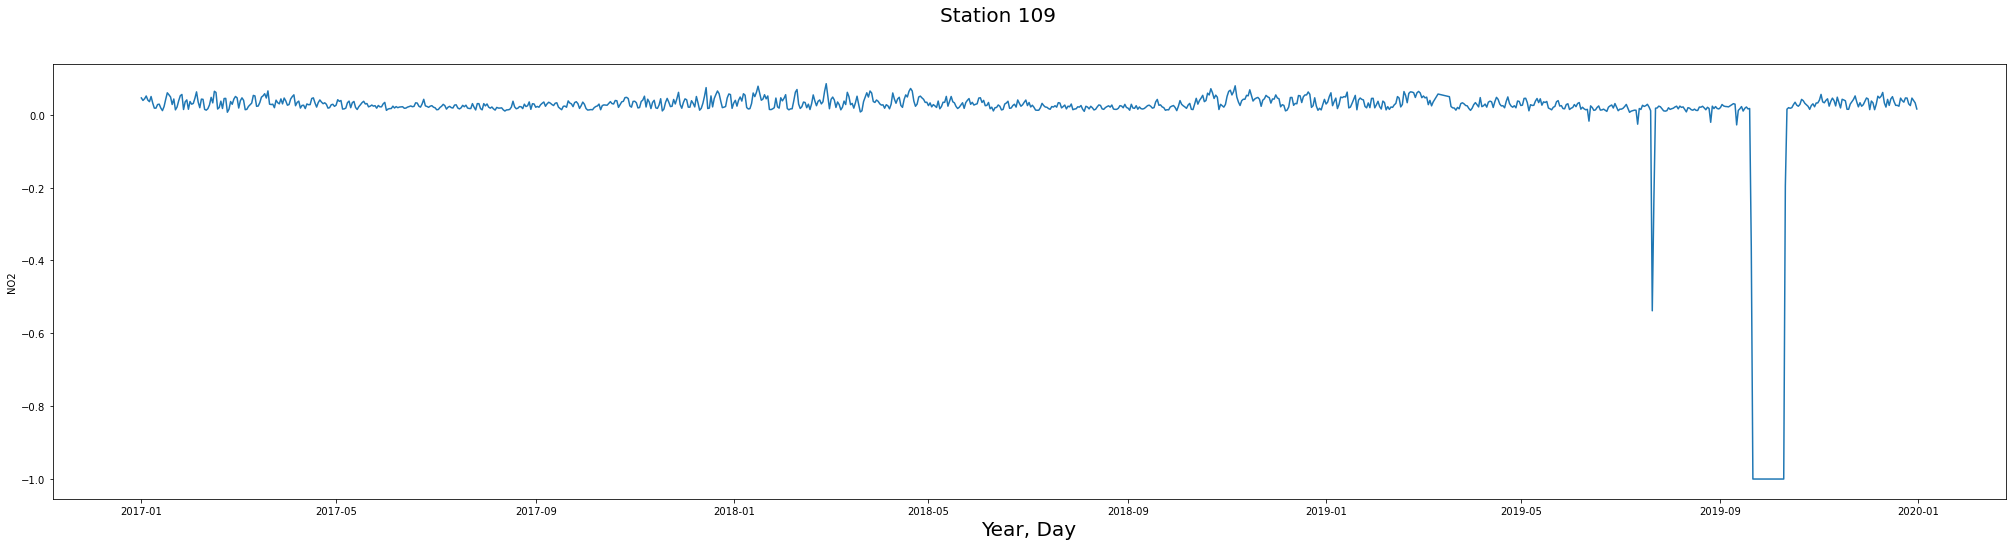

In [73]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 109", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='NO2', data=df_109)

In [74]:
df_109['NO2 Level'].value_counts()

Good      643
Normal    405
Bad        37
Name: NO2 Level, dtype: int64

#### For Station 109
- NO2 reaches levels of 'Bad' on 37 occasions and sits close to bad on most of the year.

#### Picking the relevant columns

In [75]:
columns = ['NO2']
df_109 = df_109[columns]
df_109

NO2
Measurement date          
2017-01-01        0.046292
2017-01-02        0.039417
2017-01-03        0.043958
2017-01-04        0.051583
2017-01-05        0.040375
...                    ...
2019-12-27        0.025333
2019-12-28        0.045833
2019-12-29        0.039000
2019-12-30        0.032667
2019-12-31        0.015917

[1085 rows x 1 columns]

In [76]:
train = df_109[:-542]
test = df_109[542:]

<AxesSubplot:xlabel='Measurement date'>

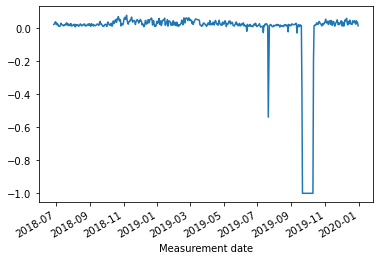

In [77]:
test['NO2'].plot()

<AxesSubplot:xlabel='Measurement date'>

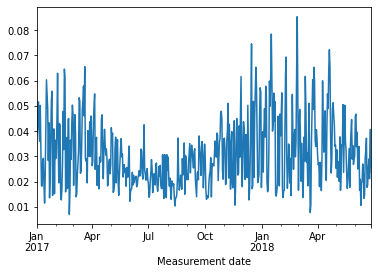

In [78]:
train['NO2'].plot()

#### Rolling Mean Difference Train

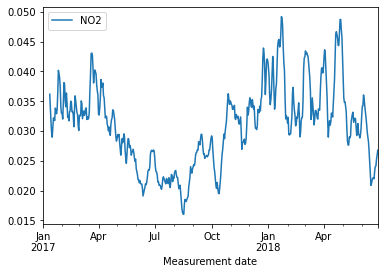

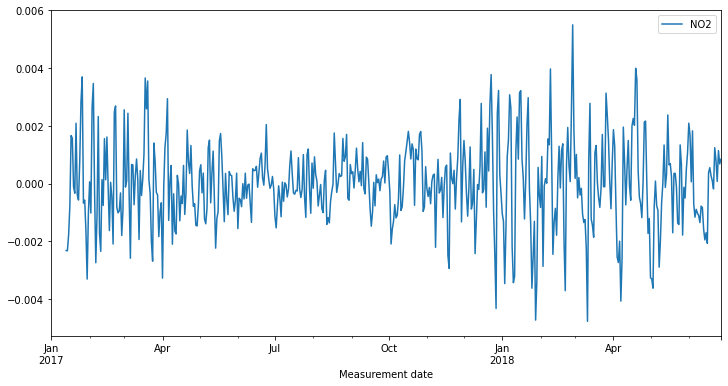

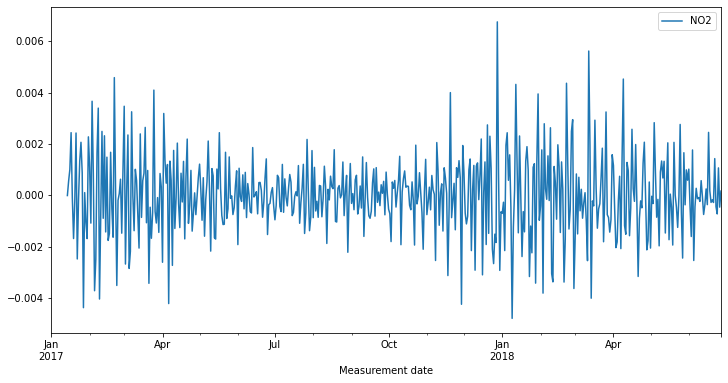

In [79]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_train = train.rolling(window=12).mean()
roll_mean_train.plot();

rm_diff_1 = roll_mean_train.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_train.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

#### Rolling Mean Difference Test

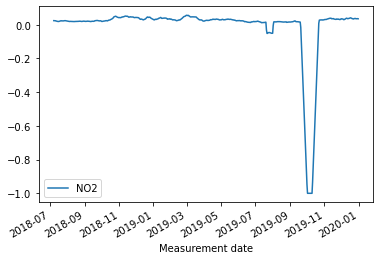

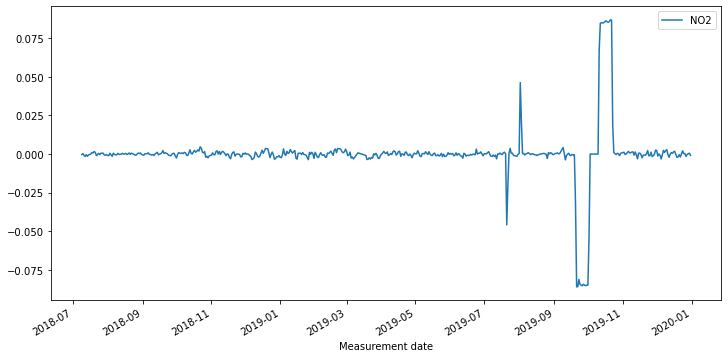

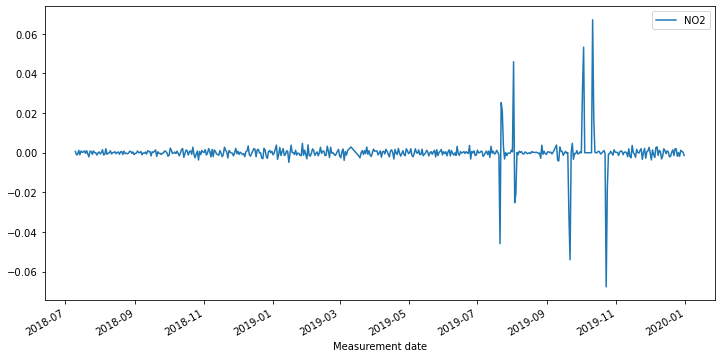

In [80]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_test = test.rolling(window=12).mean()
roll_mean_test.plot();

rm_diff_1 = roll_mean_test.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_test.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [81]:
print(stationarity_check(df_109['NO2']))
print(stationarity_check(rm_diff_1['NO2'].dropna()))
print(stationarity_check(rm_diff_2['NO2'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                   -4.391018
p-value                           0.000308
#Lags Used                       22.000000
Number of Observations Used    1062.000000
Critical Value (1%)              -3.436522
Critical Value (5%)              -2.864265
Critical Value (10%)             -2.568221
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -6.712313e+00
p-value                        3.654403e-09
#Lags Used                     1.900000e+01
Number of Observations Used    5.110000e+02
Critical Value (1%)           -3.443212e+00
Critical Value (5%)           -2.867213e+00
Critical Value (10%)          -2.569791e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -7.692690e+00
p-value                        1.405544e-11
#Lags Used                     1.900000e+01
Number of Observations Used    5.100000e+02
Critical Value (1%)           -3.443237e+00
Critical Value (5%)           -2

#### Station 109 NO2

In [82]:
base_model = sm.tsa.statespace.SARIMAX(df_109['NO2'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood                1908.602
Date:                Wed, 27 Oct 2021   AIC                          -3813.204
Time:                        16:07:47   BIC                          -3803.225
Sample:                             0   HQIC                         -3809.426
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.802e-05      0.001     -0.022      0.982      -0.003       0.002
sigma2         0.0017   7.13e-06    242.617      0.000       0.002       0.002
Ljung-Box (L1) (Q):                  26.32   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3856.215, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3815.203, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3839.731, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3847.710, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3855.228, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3855.522, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-3857.497, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-3855.520, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-3853.509, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-3855.497, Time=0.10 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 0.612 seconds


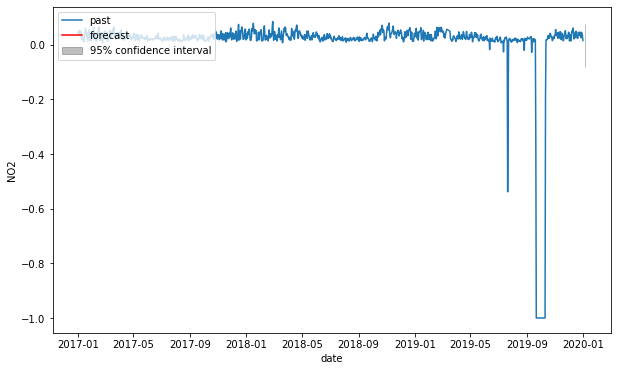

In [83]:
timeseries = df_109['NO2']
automodel = arimamodel(df_109['NO2'].diff().dropna())
plotarima(1, timeseries, automodel)

In [84]:
best_model = sm.tsa.statespace.SARIMAX(df_109['NO2'], trend='c', order=[0,0,2])
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1085
Model:               SARIMAX(0, 0, 2)   Log Likelihood                1482.007
Date:                Wed, 27 Oct 2021   AIC                          -2956.014
Time:                        16:07:48   BIC                          -2936.057
Sample:                             0   HQIC                         -2948.459
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0096      0.009      1.094      0.274      -0.008       0.027
ma.L1          1.2413      0.007    166.141      0.000       1.227       1.256
ma.L2          0.6308      0.008     74.318      0.0

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [85]:
model_train = arima_results(train['NO2'],test['NO2'], order=[2,0,1])

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

Train RMSE: 0.011340093063532898
Test RMSE: 0.2017935359892835
Summary:                                SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                  543
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1661.869
Date:                Wed, 27 Oct 2021   AIC                          -3313.739
Time:                        16:07:48   BIC                          -3292.253
Sample:                    01-01-2017   HQIC                         -3305.338
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0305      0.001     29.890      0.000       0.029       0.033
ar.L1         -0.0454      0.144     -0.315      0.753     

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Station 112

In [86]:
df_112 = df[df['Station code'] == 112]

In [87]:
df_112.head()

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 112  0.004875  0.046375  0.002625  0.858333   
2017-01-02                 112  0.008542  0.033792  0.022875  0.966667   
2017-01-03                 112  0.006000  0.038917  0.014958  0.729167   
2017-01-04                 112  0.006667  0.044125  0.013792  0.808333   
2017-01-05                 112  0.005000  0.030375  0.013458  0.591667   

                        PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                          
2017-01-01         78.166667  65.208333    Normal     Normal         Bad  
2017-01-02        102.916667  85.291667    Normal        Bad    Very Bad  
2017-01-03         77.875000  59.791667    Normal     Normal         Bad  
2017-01-04         43.583333  33.291667    Normal     Normal      Normal  
2017-01-05         27.500000  20.291667    Normal       Good      Normal

<AxesSubplot:xlabel='Year, Day', ylabel='PM2.5'>

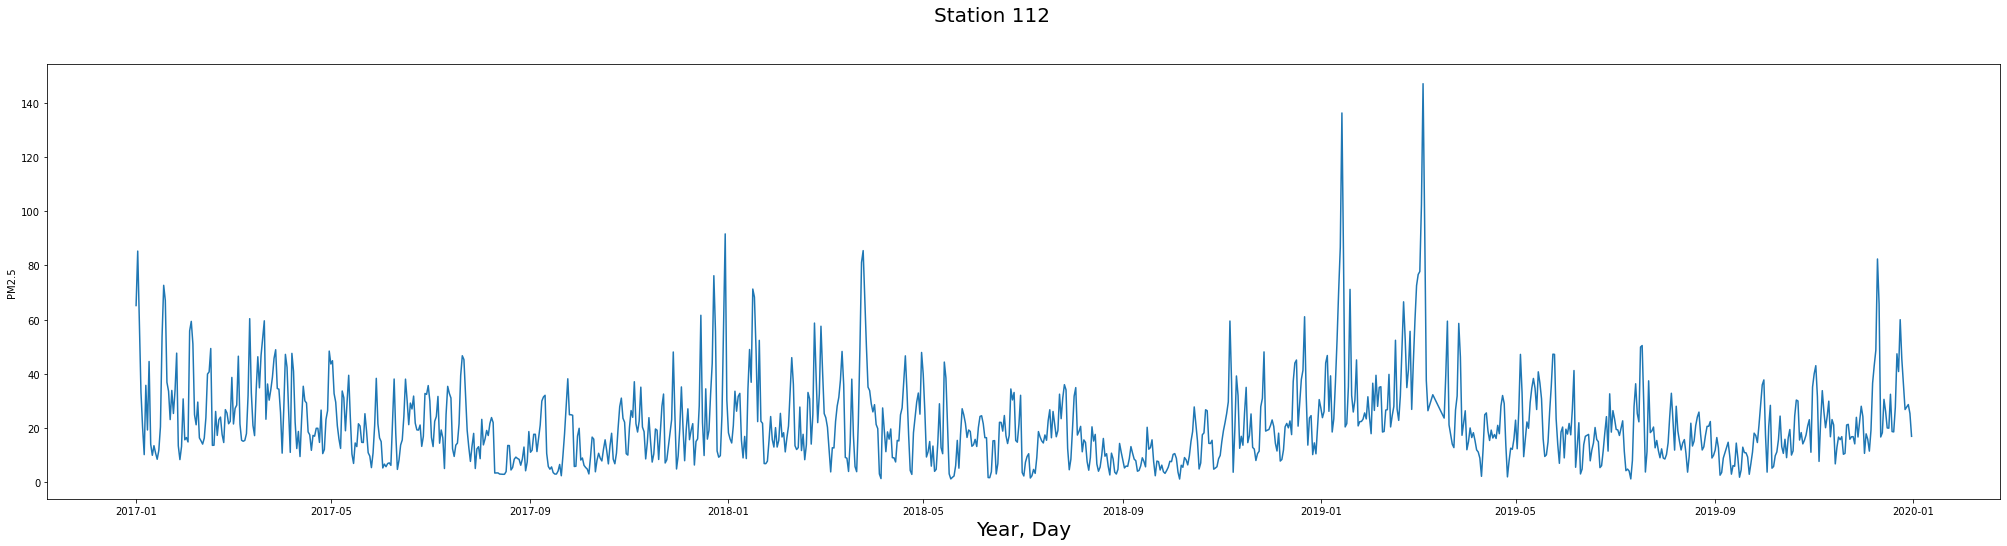

In [88]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 112", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='PM2.5', data=df_112)

In [89]:
df_112['PM2.5 Level'].value_counts()

Normal      531
Good        396
Bad         144
Very Bad     14
Name: PM2.5 Level, dtype: int64

###### For Station 112
- PM2.5 reaches levels of 'Bad' on 144 occasions and 'Very Bad' on 14 occasions.

#### Picking the relevant columns

In [90]:
columns = ['PM2.5']
df_112 = df_112[columns]
df_112

PM2.5
Measurement date           
2017-01-01        65.208333
2017-01-02        85.291667
2017-01-03        59.791667
2017-01-04        33.291667
2017-01-05        20.291667
...                     ...
2019-12-27        26.875000
2019-12-28        27.791667
2019-12-29        28.708333
2019-12-30        25.416667
2019-12-31        17.000000

[1085 rows x 1 columns]

# Train-Test Split

In [91]:
train = df_112[:-542]
test = df_112[542:]

<AxesSubplot:xlabel='Measurement date'>

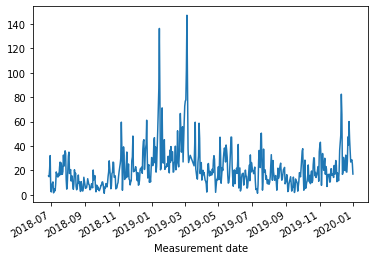

In [92]:
test['PM2.5'].plot()

<AxesSubplot:xlabel='Measurement date'>

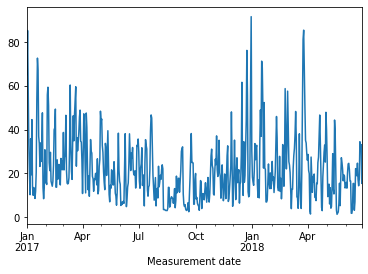

In [93]:
train['PM2.5'].plot()

#### Rolling Mean Difference Train

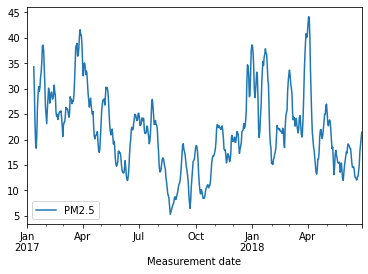

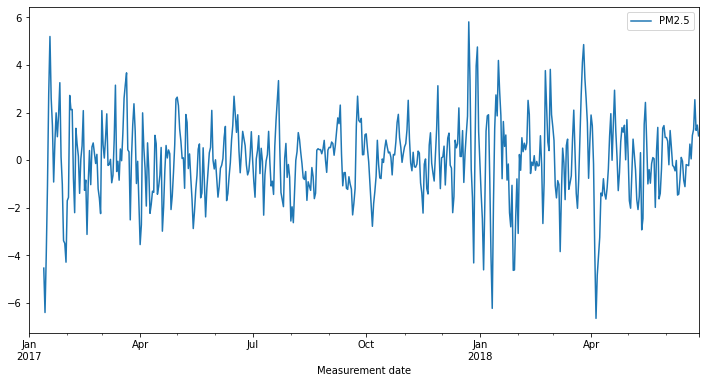

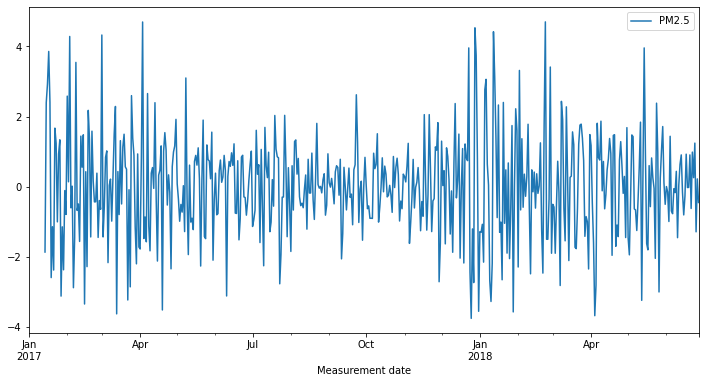

In [94]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_train = train.rolling(window=12).mean()
roll_mean_train.plot();

rm_diff_1 = roll_mean_train.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_train.diff(periods=1).diff(periods=1)

rm_diff_2.plot(figsize=(12,6));

In [95]:
print(stationarity_check(df_112['PM2.5']))
print(stationarity_check(rm_diff_1['PM2.5'].dropna()))
print(stationarity_check(rm_diff_2['PM2.5'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                   -5.188564
p-value                           0.000009
#Lags Used                       13.000000
Number of Observations Used    1071.000000
Critical Value (1%)              -3.436470
Critical Value (5%)              -2.864242
Critical Value (10%)             -2.568209
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -7.976100e+00
p-value                        2.699851e-12
#Lags Used                     1.300000e+01
Number of Observations Used    5.170000e+02
Critical Value (1%)           -3.443062e+00
Critical Value (5%)           -2.867147e+00
Critical Value (10%)          -2.569756e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.069035e+01
p-value                        3.739816e-19
#Lags Used                     1.600000e+01
Number of Observations Used    5.130000e+02
Critical Value (1%)           -3.443162e+00
Critical Value (5%)           -2

#### Rolling Mean Difference Test

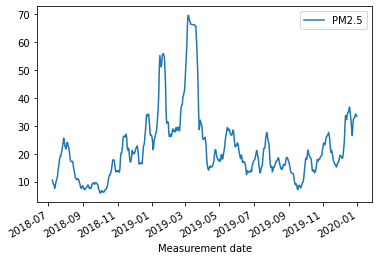

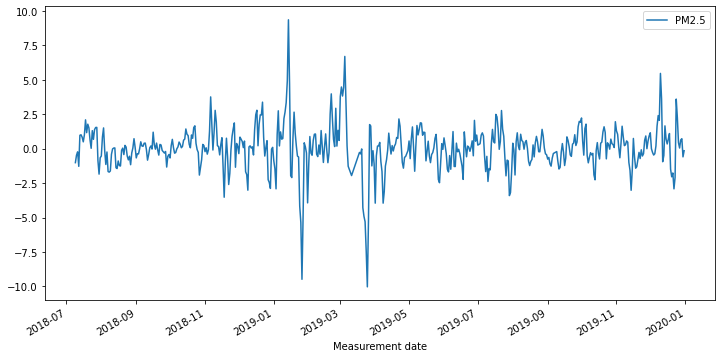

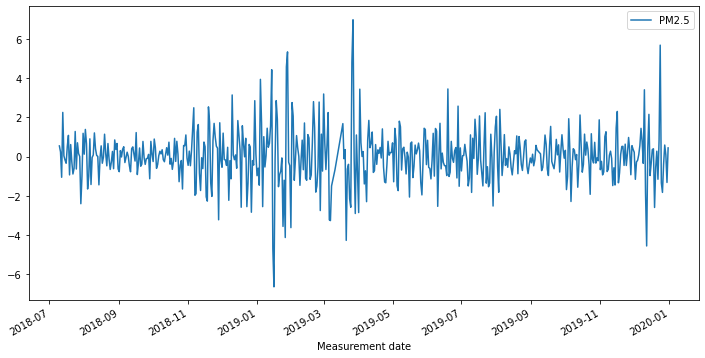

In [96]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_test = test.rolling(window=12).mean()
roll_mean_test.plot();

rm_diff_1 = roll_mean_test.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_test.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [97]:
print(stationarity_check(rm_diff_1['PM2.5'].dropna()))
print(stationarity_check(rm_diff_2['PM2.5'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -6.164865e+00
p-value                        7.029766e-08
#Lags Used                     1.400000e+01
Number of Observations Used    5.160000e+02
Critical Value (1%)           -3.443087e+00
Critical Value (5%)           -2.867158e+00
Critical Value (10%)          -2.569762e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.006148e+01
p-value                        1.329988e-17
#Lags Used                     1.500000e+01
Number of Observations Used    5.140000e+02
Critical Value (1%)           -3.443136e+00
Critical Value (5%)           -2.867179e+00
Critical Value (10%)          -2.569774e+00
dtype: float64
None


#### Station 112 PM2.5

In [98]:
base_model = sm.tsa.statespace.SARIMAX(df_112['PM2.5'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood               -4239.375
Date:                Wed, 27 Oct 2021   AIC                           8482.750
Time:                        16:07:50   BIC                           8492.729
Sample:                             0   HQIC                          8486.528
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0445      0.376     -0.118      0.906      -0.782       0.693
sigma2       146.0353      3.947     37.004      0.000     138.300     153.770
Ljung-Box (L1) (Q):                   0.57   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8303.258, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8480.765, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8482.200, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8481.438, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8258.987, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8395.651, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8255.525, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8369.076, Time=0.06 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8257.508, Time=0.21 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=8260.861, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8256.409, Time=0.15 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8355.768, Time=0.09 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=8259.525, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8257.495, Time=0.32 sec

Best model:  ARIMA(3,0,1)(0,0,0)

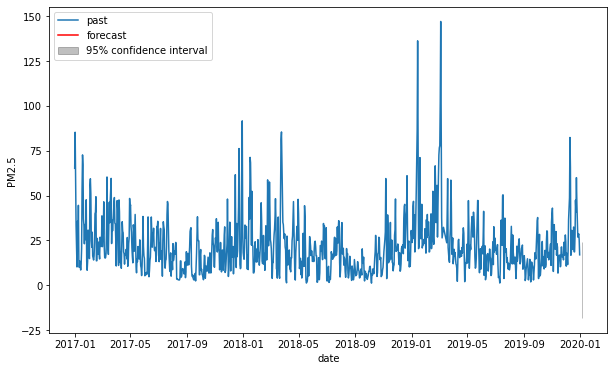

In [99]:
timeseries = df_112['PM2.5']
automodel = arimamodel(df_112['PM2.5'].diff().dropna())
plotarima(1, timeseries, automodel)

In [100]:
best_model = sm.tsa.statespace.SARIMAX(df_112['PM2.5'], trend='c', order=[3,0,1])
res = best_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1085
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -4125.004
Date:                Wed, 27 Oct 2021   AIC                           8262.009
Time:                        16:07:52   BIC                           8291.945
Sample:                             0   HQIC                          8273.341
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2670      0.169      1.578      0.114      -0.065       0.599
ar.L1          1.7036      0.037     45.891      0.000       1.631       1.776
ar.L2         -0.9339      0.045    -20.807      0.0

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [101]:
model_train = arima_results(train['PM2.5'],test['PM2.5'], order=[2,0,2])

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Train RMSE: 11.035767683682915
Test RMSE: 20.141767249569387
Summary:                                SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                  543
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2070.917
Date:                Wed, 27 Oct 2021   AIC                           4153.835
Time:                        16:07:53   BIC                           4179.617
Sample:                    01-01-2017   HQIC                          4163.916
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.6583      3.471      6.528      0.000      15.855      29.462
ar.L1          1.4070      0.070     20.202      0.000       

# Station 115

In [102]:
df_115 = df[df['Station code'] == 115]

In [103]:
df_115.head()

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 115  0.005125  0.046375  0.003625  1.058333   
2017-01-02                 115  0.005167  0.039167  0.011125  0.875000   
2017-01-03                 115  0.004833  0.040625  0.007750  0.816667   
2017-01-04                 115  0.006417  0.049500  0.006417  0.970833   
2017-01-05                 115  0.004958  0.039167  0.006083  0.820833   

                        PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                          
2017-01-01         79.625000  51.041667    Normal     Normal         Bad  
2017-01-02        106.958333  62.791667    Normal        Bad         Bad  
2017-01-03         73.166667  38.416667    Normal     Normal         Bad  
2017-01-04         58.375000  31.500000    Normal     Normal      Normal  
2017-01-05         39.000000  20.291667    Normal     Normal      Normal

<AxesSubplot:xlabel='Year, Day', ylabel='NO2'>

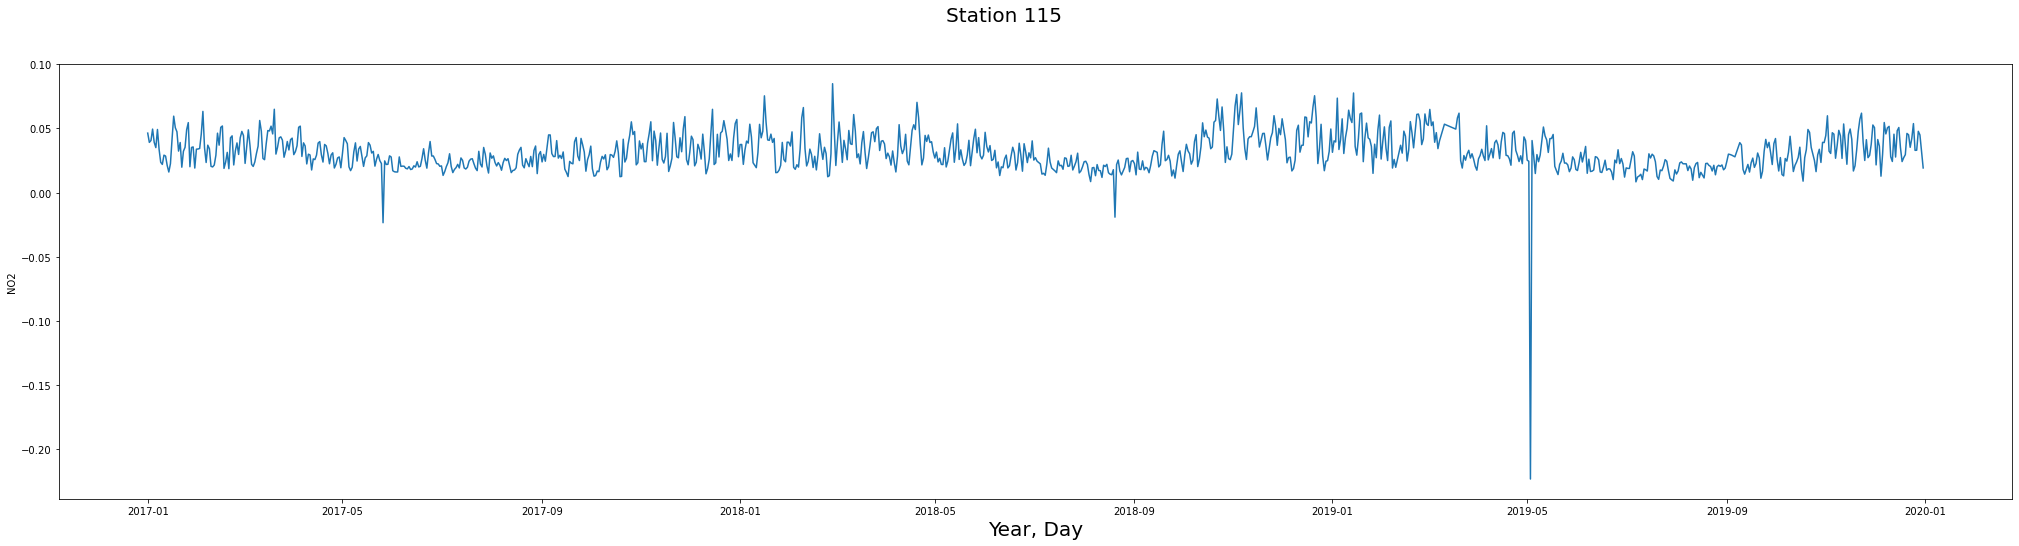

In [104]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 115", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='NO2', data=df_115)

In [105]:
df_115['NO2 Level'].value_counts()

Good      586
Normal    470
Bad        29
Name: NO2 Level, dtype: int64

###### For Station 115
- NO2 reaches levels of 'Bad' on 29 occasions and sits close to bad on most of the year.

#### Picking the relevant columns

In [106]:
columns = ['NO2']
df_115 = df_115[columns]
df_115

NO2
Measurement date          
2017-01-01        0.046375
2017-01-02        0.039167
2017-01-03        0.040625
2017-01-04        0.049500
2017-01-05        0.039167
...                    ...
2019-12-27        0.033042
2019-12-28        0.047792
2019-12-29        0.044958
2019-12-30        0.032417
2019-12-31        0.019250

[1085 rows x 1 columns]

#### Train-Test Split

In [107]:
train = df_115[:-542]
test = df_115[542:]

<AxesSubplot:xlabel='Measurement date'>

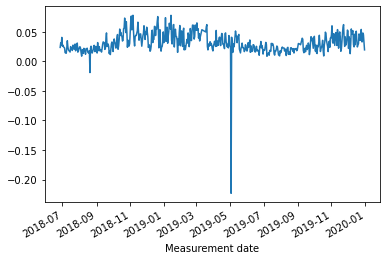

In [108]:
test['NO2'].plot()

<AxesSubplot:xlabel='Measurement date'>

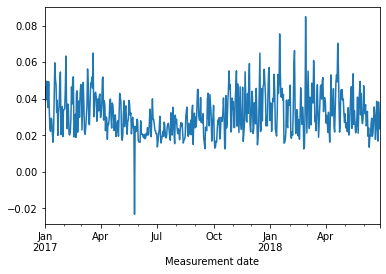

In [109]:
train['NO2'].plot()

#### Rolling Mean Difference Train

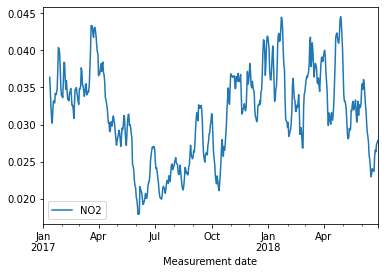

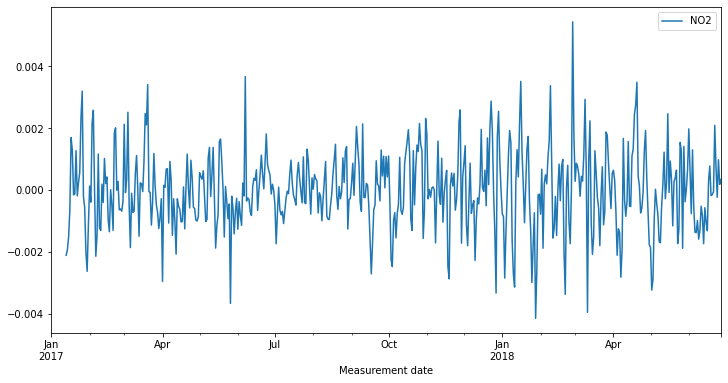

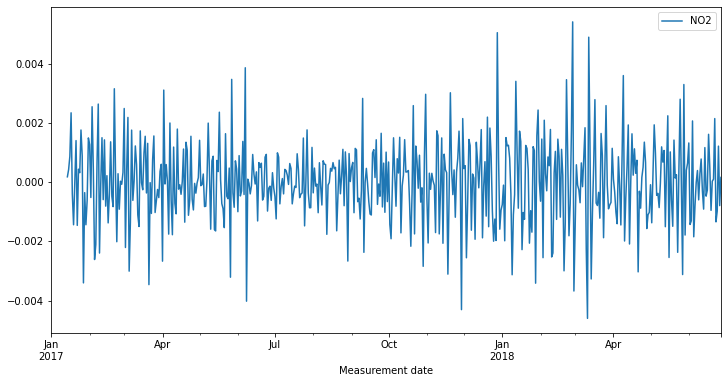

In [110]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_test = train.rolling(window=12).mean()
roll_mean_test.plot();

rm_diff_1 = roll_mean_test.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_test.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [111]:
print(stationarity_check(df_115['NO2']))
print(stationarity_check(rm_diff_1['NO2'].dropna()))
print(stationarity_check(rm_diff_2['NO2'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                   -3.749838
p-value                           0.003464
#Lags Used                       17.000000
Number of Observations Used    1067.000000
Critical Value (1%)              -3.436493
Critical Value (5%)              -2.864253
Critical Value (10%)             -2.568214
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -9.066083e+00
p-value                        4.428963e-15
#Lags Used                     1.200000e+01
Number of Observations Used    5.180000e+02
Critical Value (1%)           -3.443037e+00
Critical Value (5%)           -2.867136e+00
Critical Value (10%)          -2.569750e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.017778e+01
p-value                        6.820224e-18
#Lags Used                     1.800000e+01
Number of Observations Used    5.110000e+02
Critical Value (1%)           -3.443212e+00
Critical Value (5%)           -2

#### Rolling Mean Difference Train

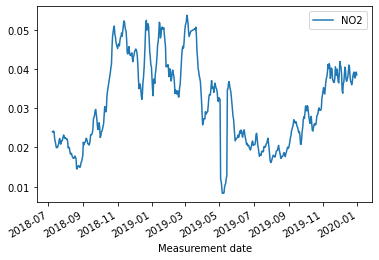

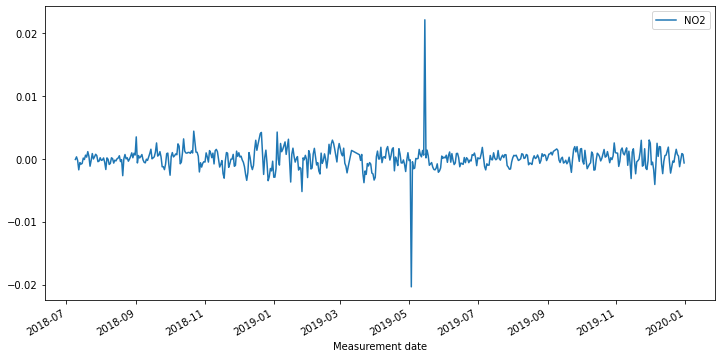

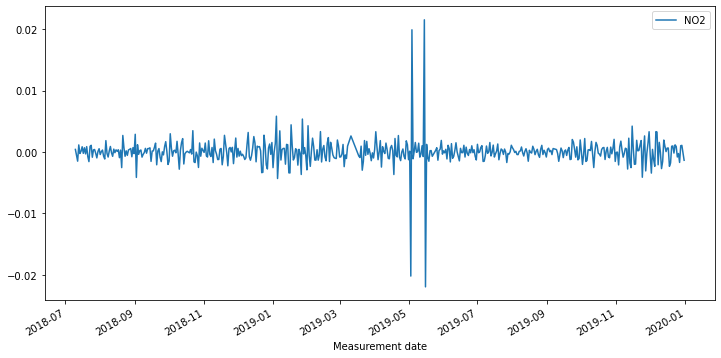

In [112]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_train = test.rolling(window=12).mean()
roll_mean_train.plot();

rm_diff_1 = roll_mean_train.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_train.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [113]:
print(stationarity_check(rm_diff_1['NO2'].dropna()))
print(stationarity_check(rm_diff_2['NO2'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -7.042000e+00
p-value                        5.814414e-10
#Lags Used                     1.400000e+01
Number of Observations Used    5.160000e+02
Critical Value (1%)           -3.443087e+00
Critical Value (5%)           -2.867158e+00
Critical Value (10%)          -2.569762e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.054121e+01
p-value                        8.640619e-19
#Lags Used                     1.700000e+01
Number of Observations Used    5.120000e+02
Critical Value (1%)           -3.443187e+00
Critical Value (5%)           -2.867202e+00
Critical Value (10%)          -2.569785e+00
dtype: float64
None


#### Station 115 NO2

In [114]:
base_model = sm.tsa.statespace.SARIMAX(df_115['NO2'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood                2936.037
Date:                Wed, 27 Oct 2021   AIC                          -5868.075
Time:                        16:07:54   BIC                          -5858.096
Sample:                             0   HQIC                         -5864.297
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.502e-05      0.000     -0.051      0.959      -0.001       0.001
sigma2         0.0003   1.46e-06    178.106      0.000       0.000       0.000
Ljung-Box (L1) (Q):                 130.86   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6311.599, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5870.072, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6006.977, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6255.453, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6311.870, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6123.290, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-6312.057, Time=0.27 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-6158.630, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-6310.975, Time=0.45 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-6311.529, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-6313.508, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-6313.228, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-6306.949, Time=0.39 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-6312.842, Time=0.34 sec
 ARIMA(3,0,3)(0,0,0

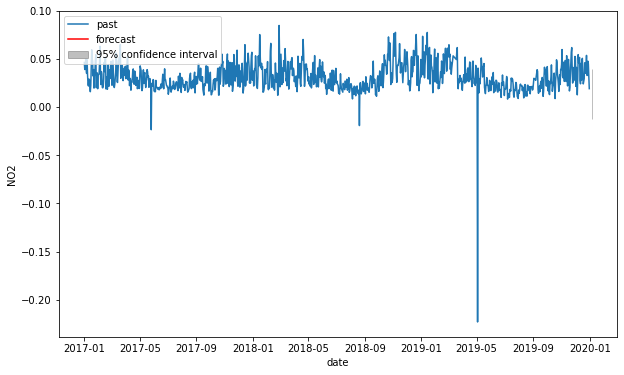

In [115]:
timeseries = df_115['NO2']
automodel = arimamodel(df_115['NO2'].diff().dropna())
plotarima(1, timeseries, automodel)

In [116]:
best_model = sm.tsa.statespace.SARIMAX(df_115['NO2'].diff(), trend='c', order=[1,0,3])
res = best_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1085
Model:               SARIMAX(1, 0, 3)   Log Likelihood                3161.416
Date:                Wed, 27 Oct 2021   AIC                          -6310.832
Time:                        16:07:59   BIC                          -6280.896
Sample:                             0   HQIC                         -6299.500
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.845e-06   7.31e-05     -0.066      0.947      -0.000       0.000
ar.L1         -0.7705      0.329     -2.342      0.019      -1.416      -0.126
ma.L1          0.0897      0.330      0.272      0.7

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [117]:
model_train = arima_results(train['NO2'],test['NO2'], order=[1,0,3])

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

Train RMSE: 0.010083611491460379
Test RMSE: 0.019849041840572006
Summary:                                SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                  543
Model:                 ARIMA(1, 0, 3)   Log Likelihood                1725.705
Date:                Wed, 27 Oct 2021   AIC                          -3439.409
Time:                        16:08:00   BIC                          -3413.627
Sample:                    01-01-2017   HQIC                         -3429.328
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0313      0.001     21.506      0.000       0.028       0.034
ar.L1          0.9474      0.045     20.967      0.000   

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Station 116

In [118]:
df_116 = df[df['Station code'] == 116]

In [119]:
df_116.head()

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 116  0.006292  0.053292  0.005250  0.962500   
2017-01-02                 116  0.006500  0.036500  0.017833  0.683333   
2017-01-03                 116  0.006875  0.044125  0.012542  0.716667   
2017-01-04                 116  0.007125  0.051667  0.010000  0.787500   
2017-01-05                 116  0.006167  0.042583  0.007458  0.679167   

                        PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                          
2017-01-01         75.125000  53.708333    Normal     Normal         Bad  
2017-01-02        107.083333  71.000000    Normal        Bad         Bad  
2017-01-03         75.208333  45.875000    Normal     Normal         Bad  
2017-01-04         62.875000  37.208333    Normal     Normal         Bad  
2017-01-05         51.541667  28.541667    Normal     Normal      Normal

<AxesSubplot:xlabel='Year, Day', ylabel='NO2'>

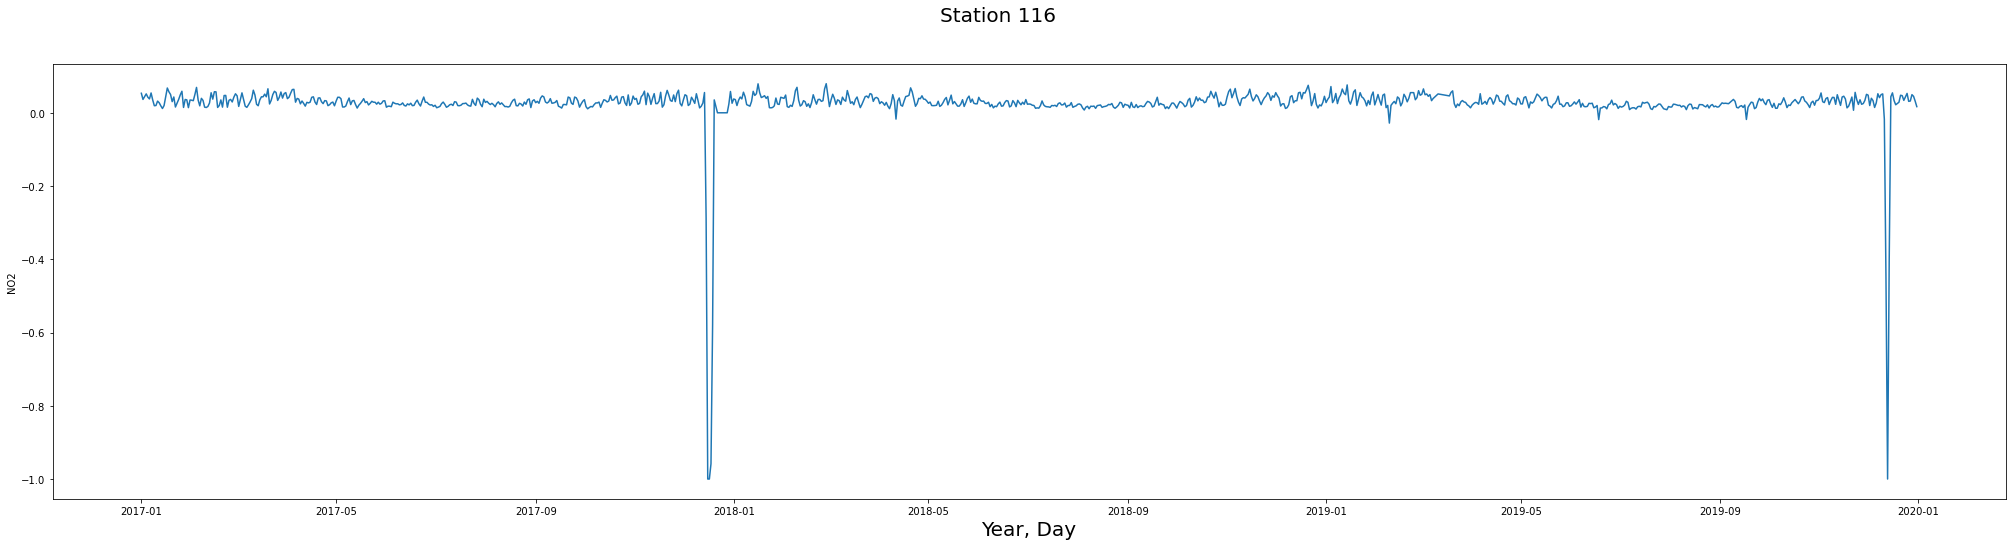

In [120]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 116", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='NO2', data=df_116)

In [121]:
df_116['NO2 Level'].value_counts()

Good      619
Normal    440
Bad        26
Name: NO2 Level, dtype: int64

##### For Station 116
- NO2 reaches levels of 'Bad' on 26 occasions and sits close to bad on most of the year.

#### Picking the relevant columns

In [122]:
columns = ['NO2']
df_116 = df_116[columns]
df_116

NO2
Measurement date          
2017-01-01        0.053292
2017-01-02        0.036500
2017-01-03        0.044125
2017-01-04        0.051667
2017-01-05        0.042583
...                    ...
2019-12-27        0.032208
2019-12-28        0.049542
2019-12-29        0.044958
2019-12-30        0.031792
2019-12-31        0.016792

[1085 rows x 1 columns]

#### Train-Test Split

In [123]:
train = df_116[:-542]
test = df_116[542:]

<AxesSubplot:xlabel='Measurement date'>

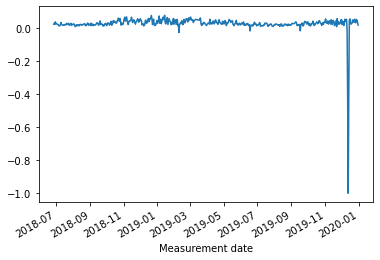

In [124]:
test['NO2'].plot()

<AxesSubplot:xlabel='Measurement date'>

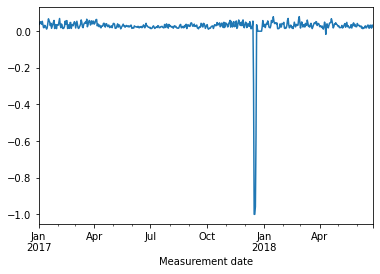

In [125]:
train['NO2'].plot()

#### Rolling Mean Difference Train

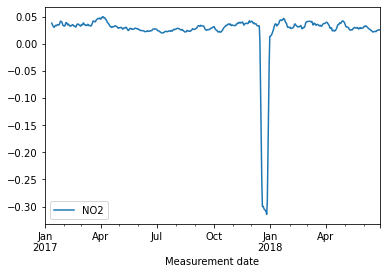

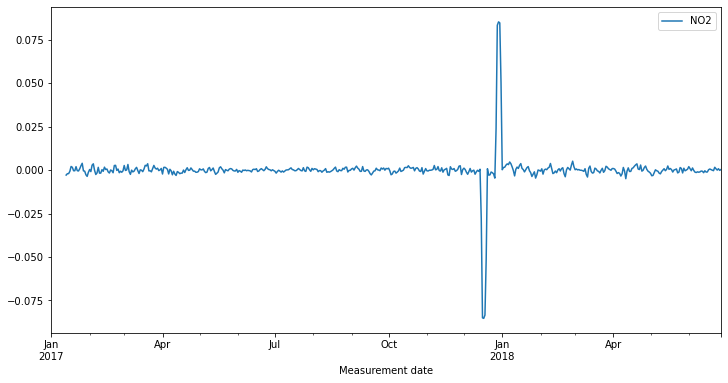

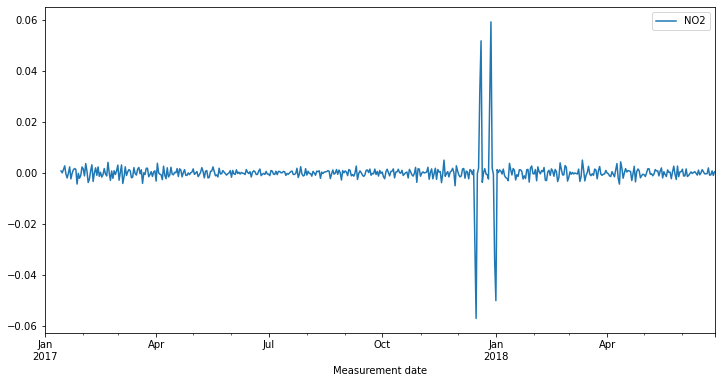

In [126]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_train = train.rolling(window=12).mean()
roll_mean_train.plot();

rm_diff_1 = roll_mean_train.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_train.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [127]:
print(stationarity_check(df_116['NO2']))
print(stationarity_check(rm_diff_1['NO2'].dropna()))
print(stationarity_check(rm_diff_2['NO2'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -1.007266e+01
p-value                        1.247141e-17
#Lags Used                     7.000000e+00
Number of Observations Used    1.077000e+03
Critical Value (1%)           -3.436436e+00
Critical Value (5%)           -2.864227e+00
Critical Value (10%)          -2.568201e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -6.416177e+00
p-value                        1.838916e-08
#Lags Used                     1.700000e+01
Number of Observations Used    5.130000e+02
Critical Value (1%)           -3.443162e+00
Critical Value (5%)           -2.867190e+00
Critical Value (10%)          -2.569780e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -9.398684e+00
p-value                        6.272653e-16
#Lags Used                     1.700000e+01
Number of Observations Used    5.120000e+02
Critical Value (1%)           -3.443187e+00
Critical Value (5%)      

#### Rolling Mean Difference Test

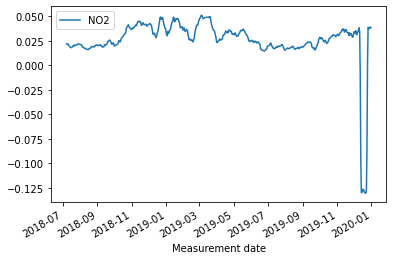

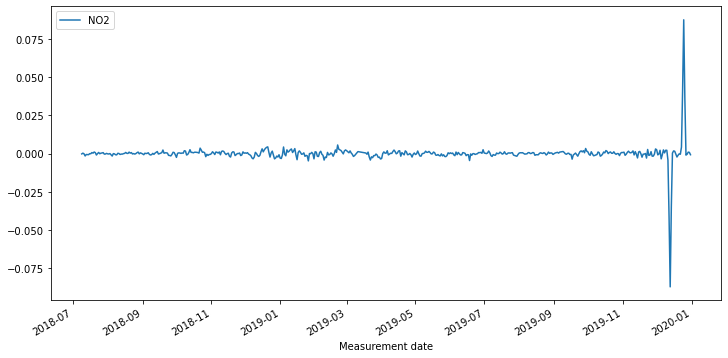

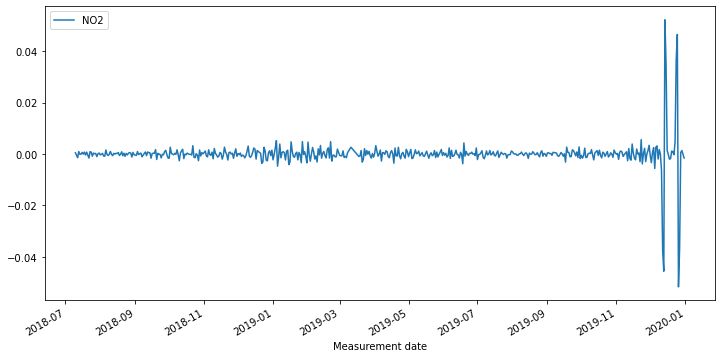

In [128]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_test = test.rolling(window=12).mean()
roll_mean_test.plot();

rm_diff_1 = roll_mean_test.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_test.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [129]:
print(stationarity_check(rm_diff_1['NO2'].dropna()))
print(stationarity_check(rm_diff_2['NO2'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -8.208927e+00
p-value                        6.902556e-13
#Lags Used                     1.400000e+01
Number of Observations Used    5.160000e+02
Critical Value (1%)           -3.443087e+00
Critical Value (5%)           -2.867158e+00
Critical Value (10%)          -2.569762e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -9.847919e+00
p-value                        4.566935e-17
#Lags Used                     1.900000e+01
Number of Observations Used    5.100000e+02
Critical Value (1%)           -3.443237e+00
Critical Value (5%)           -2.867224e+00
Critical Value (10%)          -2.569797e+00
dtype: float64
None


#### Station 116 NO2

In [130]:
base_model = sm.tsa.statespace.SARIMAX(df_116['NO2'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood                1780.501
Date:                Wed, 27 Oct 2021   AIC                          -3557.002
Time:                        16:08:01   BIC                          -3547.023
Sample:                             0   HQIC                         -3553.225
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.367e-05      0.001     -0.024      0.981      -0.003       0.003
sigma2         0.0022   1.13e-05    193.745      0.000       0.002       0.002
Ljung-Box (L1) (Q):                  80.37   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3770.680, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3559.001, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3640.128, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3731.066, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-3794.383, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-3872.267, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-3870.609, Time=0.52 sec

Best model:  ARIMA(0,0,3)(0,0,0)[0]          
Total fit time: 3.323 seconds


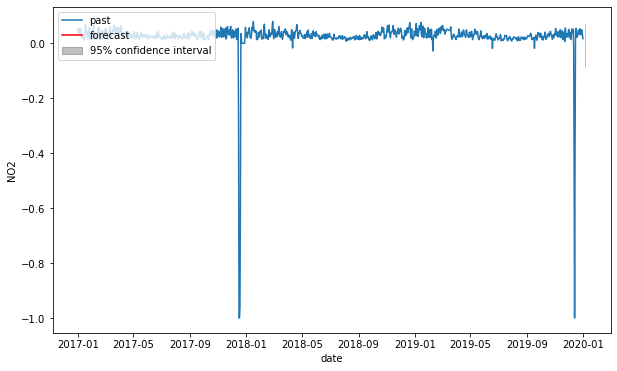

In [131]:
timeseries = df_116['NO2']
automodel = arimamodel(df_116['NO2'].diff().dropna())
plotarima(1, timeseries, automodel)

In [132]:
best_model = sm.tsa.statespace.SARIMAX(df_116['NO2'], trend='c', order=[0,0,3])
res = best_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1085
Model:               SARIMAX(0, 0, 3)   Log Likelihood                1996.672
Date:                Wed, 27 Oct 2021   AIC                          -3983.344
Time:                        16:08:05   BIC                          -3958.398
Sample:                             0   HQIC                         -3973.900
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0247      0.007      3.492      0.000       0.011       0.039
ma.L1          1.1976      0.006    208.597      0.000       1.186       1.209
ma.L2          0.6825      0.009     73.069      0.0

In [133]:
model_train = arima_results(train['NO2'],test['NO2'], order=[3,0,0])

Train RMSE: 0.03980459881451225
Test RMSE: 0.08867915680775477
Summary:                                SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                  543
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 979.381
Date:                Wed, 27 Oct 2021   AIC                          -1948.761
Time:                        16:08:05   BIC                          -1927.275
Sample:                    01-01-2017   HQIC                         -1940.360
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0239      0.016      1.474      0.140      -0.008       0.056
ar.L1          1.2574      0.011    114.740      0.000     

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


# Station 117

In [134]:
df_117 = df[df['Station code'] == 117]

In [135]:
df_117.head()

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 117  0.007000  0.036333  0.006208  0.983333   
2017-01-02                 117  0.008000  0.030458  0.016500  0.754167   
2017-01-03                 117  0.007417  0.030125  0.014958  0.637500   
2017-01-04                 117  0.007750  0.039250  0.009458  0.795833   
2017-01-05                 117  0.006000  0.029292  0.010417  0.554167   

                        PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                          
2017-01-01         79.000000  54.375000    Normal     Normal         Bad  
2017-01-02        116.416667  77.958333    Normal        Bad    Very Bad  
2017-01-03         75.125000  48.750000    Normal     Normal         Bad  
2017-01-04         60.166667  35.583333    Normal     Normal         Bad  
2017-01-05         38.500000  21.583333      Good     Normal      Normal

<AxesSubplot:xlabel='Year, Day', ylabel='PM2.5'>

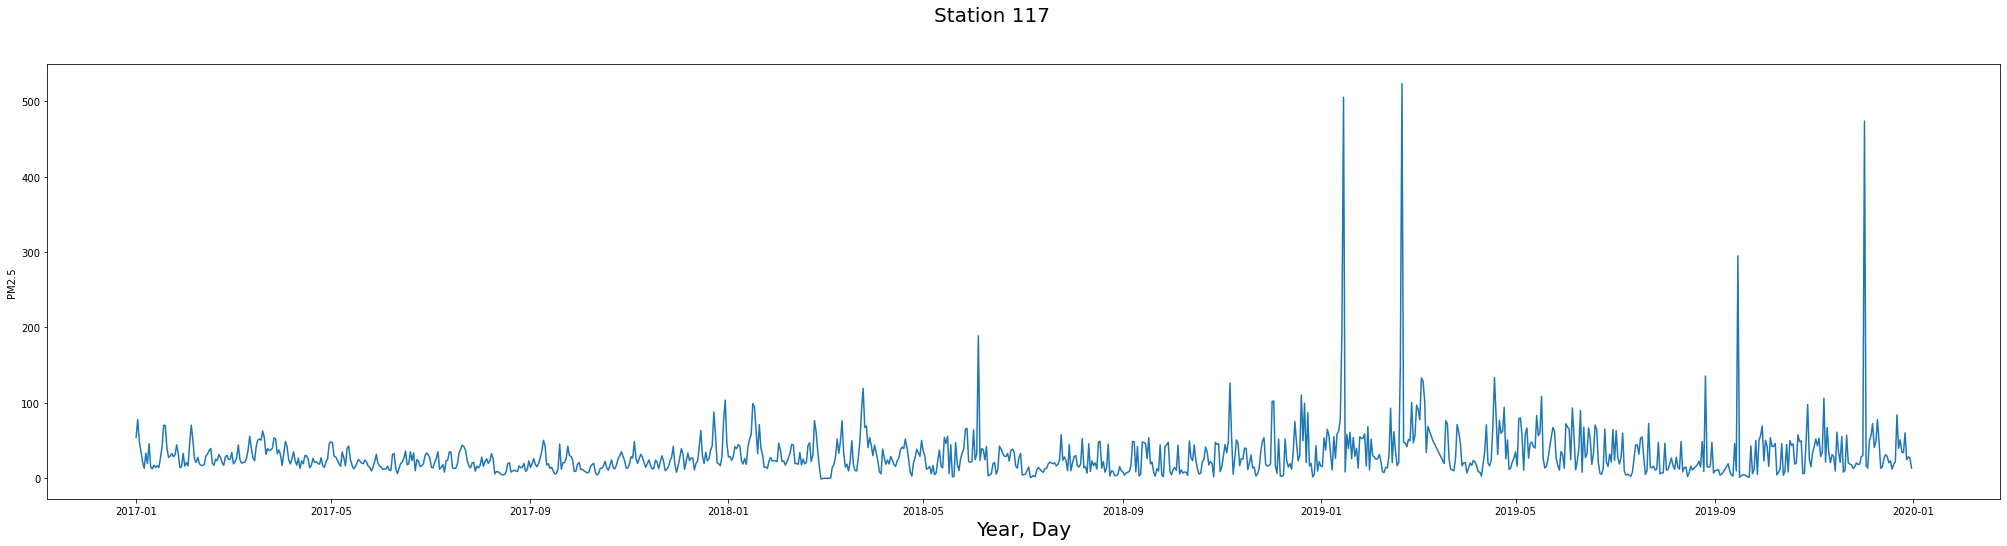

In [136]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 117", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='PM2.5', data=df_117)

<AxesSubplot:xlabel='Year, Day', ylabel='PM10'>

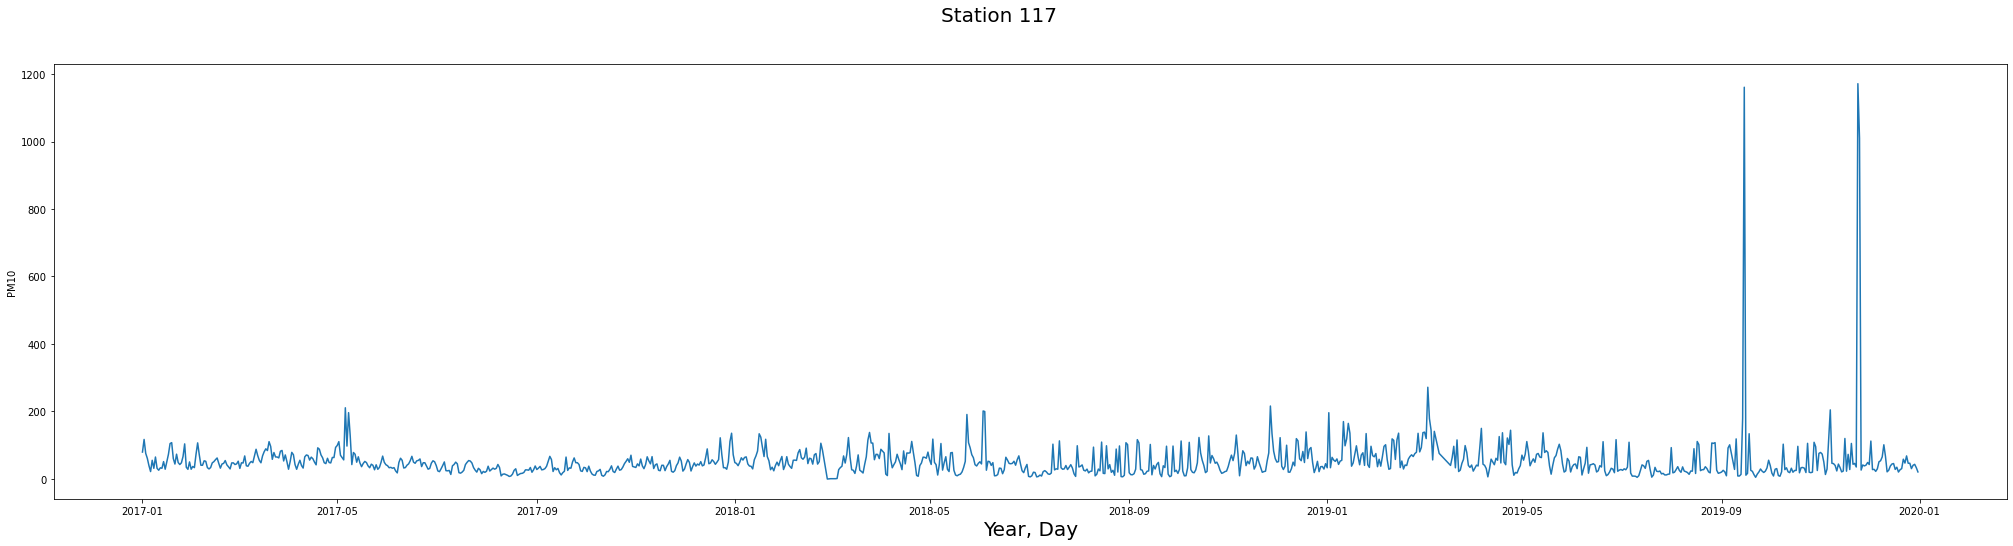

In [137]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 117", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='PM10', data=df_117)

In [138]:
df_117['PM10 Level'].value_counts()

Normal      569
Good        362
Bad         138
Very Bad     13
Name: PM10 Level, dtype: int64

In [139]:
df_117['PM2.5 Level'].value_counts()

Normal      471
Good        293
Bad         272
Very Bad     47
Name: PM2.5 Level, dtype: int64

###### For Station 117
- PM10 reaches levels of 'Bad' on 138 occasions and 'Very Bad' on 13 occasions, and can get close to 'Bad' on many occasions.
- PM2.5 reaches levels of 'Bad' on 272 occasions and 'Very Bad' on 47 occasions.

#### Relevant Columns 

In [140]:
columns = ['PM10', 'PM2.5']
df_117 = df_117[columns]
df_117

PM10      PM2.5
Measurement date                       
2017-01-01         79.000000  54.375000
2017-01-02        116.416667  77.958333
2017-01-03         75.125000  48.750000
2017-01-04         60.166667  35.583333
2017-01-05         38.500000  21.583333
...                      ...        ...
2019-12-27         29.875000  60.250000
2019-12-28         39.750000  24.791667
2019-12-29         42.583333  28.458333
2019-12-30         32.666667  26.875000
2019-12-31         20.083333  13.625000

[1085 rows x 2 columns]

In [141]:
train = df_117[:-542]
test = df_117[542:]

<AxesSubplot:xlabel='Measurement date'>

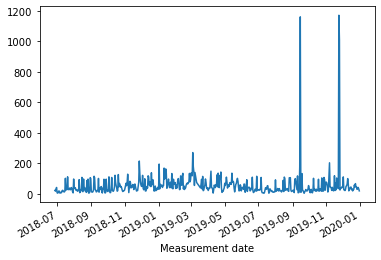

In [142]:
test['PM10'].plot()

<AxesSubplot:xlabel='Measurement date'>

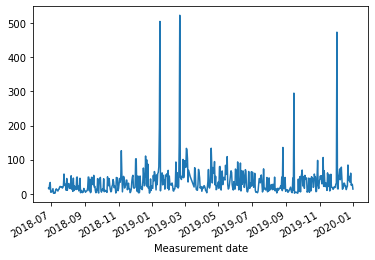

In [143]:
test['PM2.5'].plot()

<AxesSubplot:xlabel='Measurement date'>

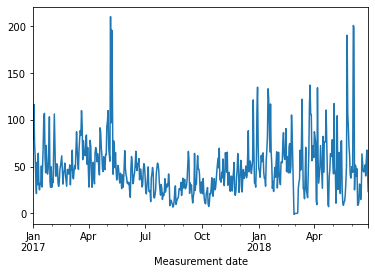

In [144]:
train['PM10'].plot()

<AxesSubplot:xlabel='Measurement date'>

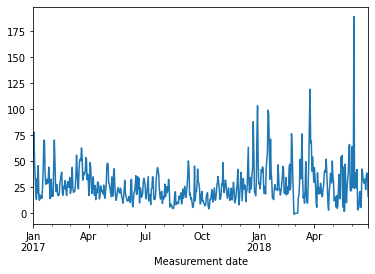

In [145]:
train['PM2.5'].plot()

In [146]:
print(stationarity_check(df_117['PM2.5']))
print(stationarity_check(df_117['PM10']))

Results of Dickey-Fuller Test: 

Test Statistic                -1.037313e+01
p-value                        2.236985e-18
#Lags Used                     5.000000e+00
Number of Observations Used    1.079000e+03
Critical Value (1%)           -3.436425e+00
Critical Value (5%)           -2.864222e+00
Critical Value (10%)          -2.568198e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.611123e+01
p-value                        5.010567e-29
#Lags Used                     2.000000e+00
Number of Observations Used    1.082000e+03
Critical Value (1%)           -3.436408e+00
Critical Value (5%)           -2.864215e+00
Critical Value (10%)          -2.568194e+00
dtype: float64
None


#### Rolling Mean Difference Train

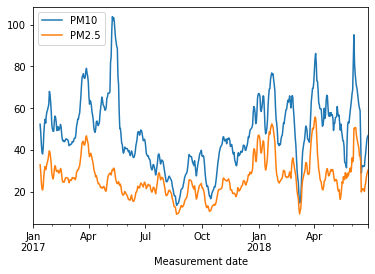

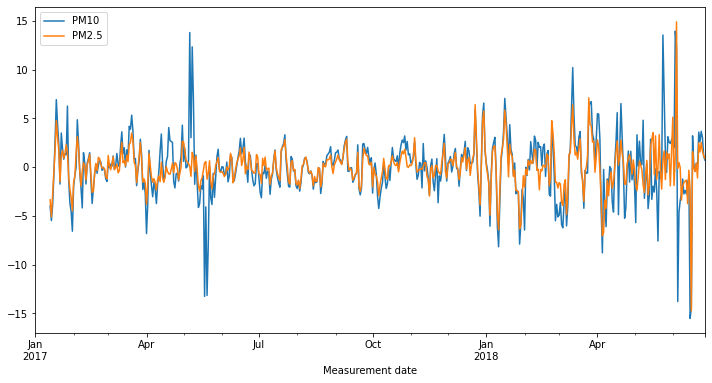

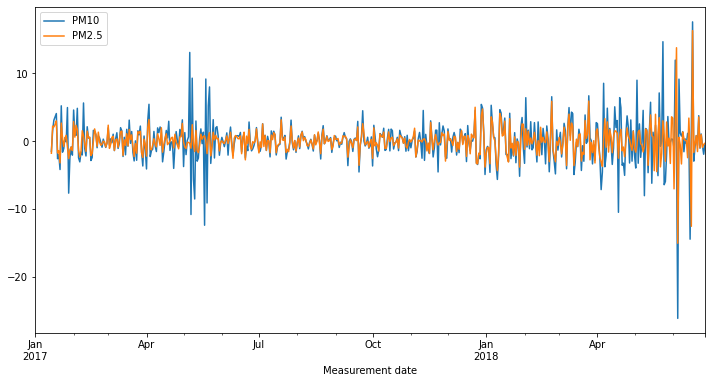

In [147]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_train = train.rolling(window=12).mean()
roll_mean_train.plot();

rm_diff_1 = roll_mean_train.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_train.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [148]:
print(stationarity_check(rm_diff_1['PM2.5'].dropna()))
print(stationarity_check(rm_diff_1['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -7.539632e+00
p-value                        3.405164e-11
#Lags Used                     1.200000e+01
Number of Observations Used    5.180000e+02
Critical Value (1%)           -3.443037e+00
Critical Value (5%)           -2.867136e+00
Critical Value (10%)          -2.569750e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -8.209131e+00
p-value                        6.894296e-13
#Lags Used                     1.200000e+01
Number of Observations Used    5.180000e+02
Critical Value (1%)           -3.443037e+00
Critical Value (5%)           -2.867136e+00
Critical Value (10%)          -2.569750e+00
dtype: float64
None


In [149]:
print(stationarity_check(rm_diff_2['PM2.5'].dropna()))
print(stationarity_check(rm_diff_2['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -1.149467e+01
p-value                        4.645500e-21
#Lags Used                     1.500000e+01
Number of Observations Used    5.140000e+02
Critical Value (1%)           -3.443136e+00
Critical Value (5%)           -2.867179e+00
Critical Value (10%)          -2.569774e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.097248e+01
p-value                        7.817004e-20
#Lags Used                     1.500000e+01
Number of Observations Used    5.140000e+02
Critical Value (1%)           -3.443136e+00
Critical Value (5%)           -2.867179e+00
Critical Value (10%)          -2.569774e+00
dtype: float64
None


#### Rolling Mean Difference Test

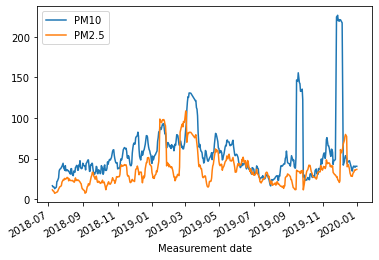

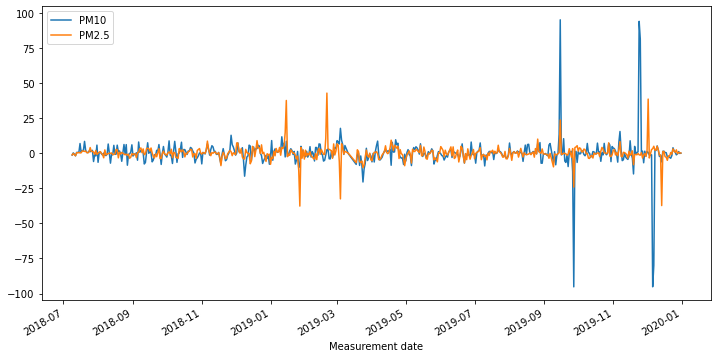

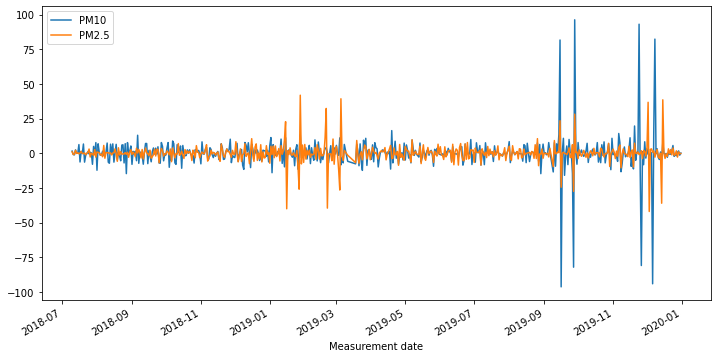

In [150]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_test = test.rolling(window=12).mean()
roll_mean_test.plot();

rm_diff_1 = roll_mean_test.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_test.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [151]:
print(stationarity_check(rm_diff_1['PM2.5'].dropna()))
print(stationarity_check(rm_diff_1['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -9.284011e+00
p-value                        1.229309e-15
#Lags Used                     1.200000e+01
Number of Observations Used    5.180000e+02
Critical Value (1%)           -3.443037e+00
Critical Value (5%)           -2.867136e+00
Critical Value (10%)          -2.569750e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -9.301325e+00
p-value                        1.110466e-15
#Lags Used                     1.300000e+01
Number of Observations Used    5.170000e+02
Critical Value (1%)           -3.443062e+00
Critical Value (5%)           -2.867147e+00
Critical Value (10%)          -2.569756e+00
dtype: float64
None


In [152]:
print(stationarity_check(rm_diff_2['PM2.5'].dropna()))
print(stationarity_check(rm_diff_2['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -9.582534e+00
p-value                        2.139398e-16
#Lags Used                     1.900000e+01
Number of Observations Used    5.100000e+02
Critical Value (1%)           -3.443237e+00
Critical Value (5%)           -2.867224e+00
Critical Value (10%)          -2.569797e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.044514e+01
p-value                        1.486829e-18
#Lags Used                     1.800000e+01
Number of Observations Used    5.110000e+02
Critical Value (1%)           -3.443212e+00
Critical Value (5%)           -2.867213e+00
Critical Value (10%)          -2.569791e+00
dtype: float64
None


#### Station 117 PM2.5

In [153]:
base_model = sm.tsa.statespace.SARIMAX(df_117['PM2.5'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood               -5586.749
Date:                Wed, 27 Oct 2021   AIC                          11177.497
Time:                        16:08:07   BIC                          11187.476
Sample:                             0   HQIC                         11181.275
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0376      1.308     -0.029      0.977      -2.601       2.526
sigma2      1754.2160     12.981    135.138      0.000    1728.774    1779.658
Ljung-Box (L1) (Q):                 184.59   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10659.483, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11175.498, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10976.070, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10697.331, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10661.030, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10660.966, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=10662.405, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=10887.570, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10661.778, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10661.455, Time=0.16 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.909 seconds


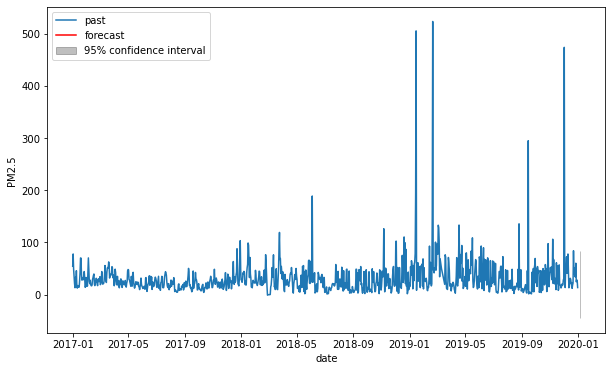

In [154]:
timeseries = df_117['PM2.5']
automodel = arimamodel(df_117['PM2.5'].diff().dropna())
plotarima(1, timeseries, automodel)

In [155]:
best_model = sm.tsa.statespace.SARIMAX(df_117['PM2.5'], trend='c', order=[1,0,1])
res = best_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1085
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -5336.719
Date:                Wed, 27 Oct 2021   AIC                          10681.438
Time:                        16:08:08   BIC                          10701.395
Sample:                             0   HQIC                         10688.993
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.4807      2.389      3.550      0.000       3.798      13.163
ar.L1          0.7257      0.070     10.391      0.000       0.589       0.863
ma.L1         -0.5268      0.077     -6.872      0.0

In [156]:
model_train = arima_results(train['PM2.5'],test['PM2.5'], order=[2,0,1])

Train RMSE: 14.767310121962904
Test RMSE: 46.1798763299191
Summary:                                SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                  543
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2232.105
Date:                Wed, 27 Oct 2021   AIC                           4474.210
Time:                        16:08:09   BIC                           4495.695
Sample:                    01-01-2017   HQIC                          4482.611
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.0330      1.796     15.050      0.000      23.512      30.554
ar.L1         -0.3780      0.026    -14.784      0.000      -0.

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

#### Station 117 PM10

In [157]:
base_model = sm.tsa.statespace.SARIMAX(df_117['PM10'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood               -6207.918
Date:                Wed, 27 Oct 2021   AIC                          12419.837
Time:                        16:08:09   BIC                          12429.815
Sample:                             0   HQIC                         12423.614
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0544      2.256     -0.024      0.981      -4.477       4.368
sigma2      5518.4195     26.518    208.098      0.000    5466.444    5570.395
Ljung-Box (L1) (Q):                  68.22   Jarque-

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12417.837, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12349.693, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12129.262, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=11985.649, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=11987.498, Time=0.22 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=11987.520, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=11988.914, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 1.331 seconds


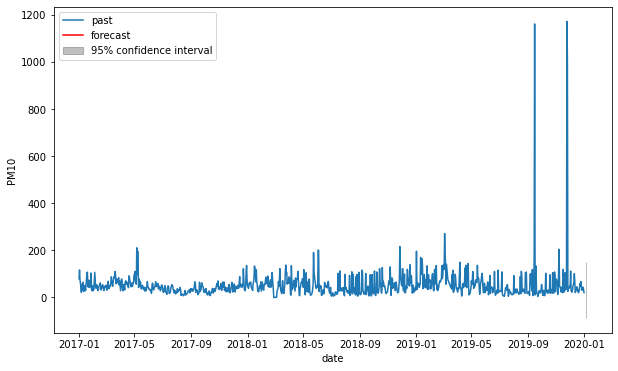

In [158]:
timeseries = df_117['PM10']
automodel = arimamodel(df_117['PM10'].diff().dropna())
plotarima(1, timeseries, automodel)

In [159]:
best_model = sm.tsa.statespace.SARIMAX(df_117['PM10'], trend='c', order=[0,0,2])
res = best_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1085
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -5993.649
Date:                Wed, 27 Oct 2021   AIC                          11995.298
Time:                        16:08:10   BIC                          12015.255
Sample:                             0   HQIC                         12002.853
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     51.5365      5.147     10.013      0.000      41.448      61.625
ma.L1          0.4058      0.006     71.808      0.000       0.395       0.417
ma.L2          0.0050      0.012      0.404      0.6

In [160]:
model_train = arima_results(train['PM10'],test['PM10'], order=[1,0,2])

Train RMSE: 23.277606106288534
Test RMSE: 91.22696829220713
Summary:                                SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                  543
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2479.448
Date:                Wed, 27 Oct 2021   AIC                           4968.896
Time:                        16:08:11   BIC                           4990.381
Sample:                    01-01-2017   HQIC                          4977.297
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.1096      4.387     10.966      0.000      39.511      56.709
ar.L1          0.8537      0.053     16.212      0.000       0

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


# Station 119

In [161]:
df_119 = df[df['Station code'] == 119]

In [162]:
df_119.head()

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 119  0.004458  0.030333  0.005708  1.179167   
2017-01-02                 119  0.004292  0.027042  0.013875  1.025000   
2017-01-03                 119 -0.121292 -0.102583 -0.114958  0.583333   
2017-01-04                 119  0.004375  0.033333  0.007958  1.008333   
2017-01-05                 119  0.004417  0.025292  0.010083  0.733333   

                        PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                          
2017-01-01         70.250000  52.583333    Normal     Normal         Bad  
2017-01-02        107.333333  74.541667      Good        Bad         Bad  
2017-01-03         55.833333  36.416667      Good     Normal         Bad  
2017-01-04         56.708333  33.500000    Normal     Normal      Normal  
2017-01-05         36.750000  23.958333      Good     Normal      Normal

<AxesSubplot:xlabel='Year, Day', ylabel='PM10'>

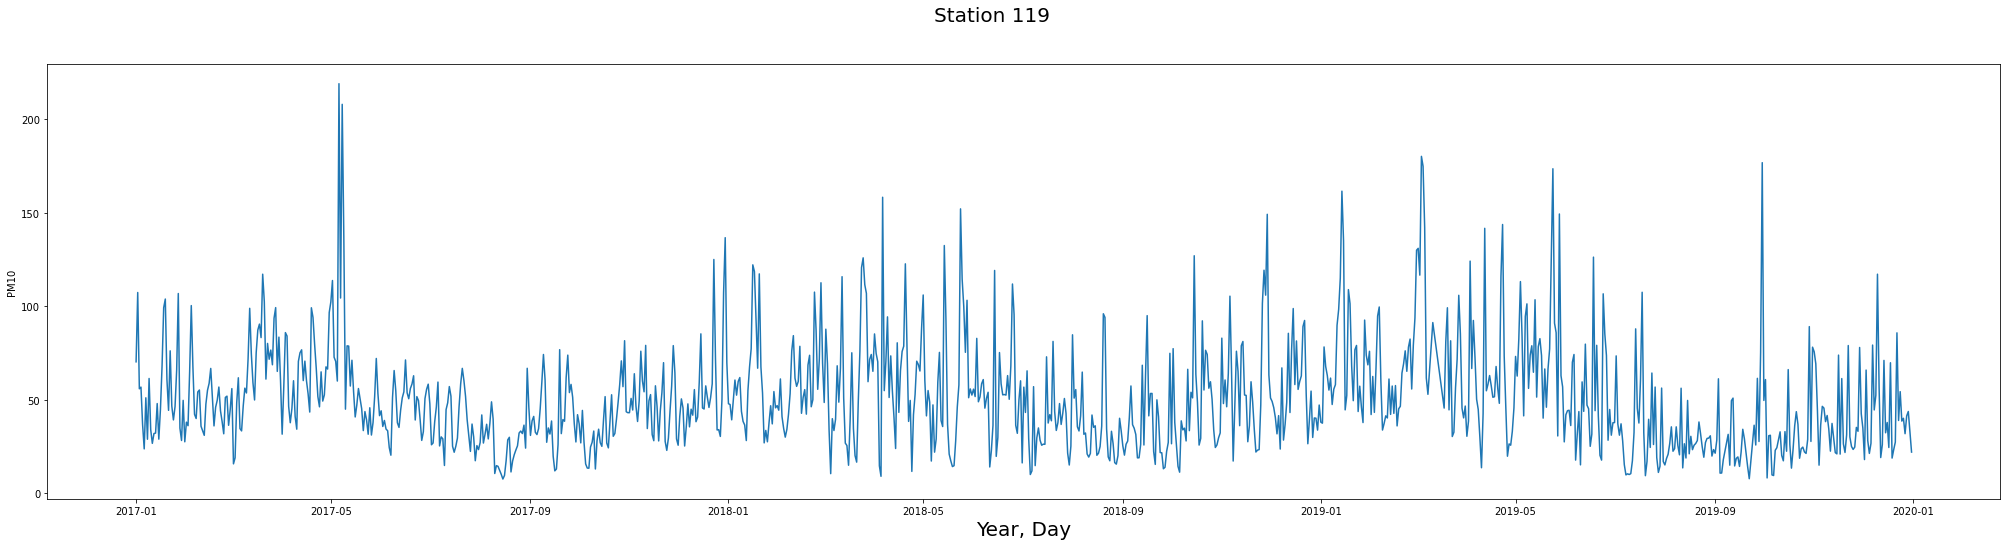

In [163]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 119", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='PM10', data=df_119)

In [164]:
df_119['PM10 Level'].value_counts()

Normal      688
Good        266
Bad         122
Very Bad      9
Name: PM10 Level, dtype: int64

###### For Station 119:
- PM10 reaches levels of 'Bad' on 122 occasions and 'Very Bad' on 9, and can get close to bad on many occasions.

#### Picking the relevant columns

In [165]:
columns = ['PM10']
df_119 = df_119[columns]
df_119

PM10
Measurement date            
2017-01-01         70.250000
2017-01-02        107.333333
2017-01-03         55.833333
2017-01-04         56.708333
2017-01-05         36.750000
...                      ...
2019-12-27         31.791667
2019-12-28         41.291667
2019-12-29         43.666667
2019-12-30         32.875000
2019-12-31         21.958333

[1085 rows x 1 columns]

#### Train-Test Split

In [166]:
train = df_119[:-542]
test = df_119[542:]

<AxesSubplot:xlabel='Measurement date'>

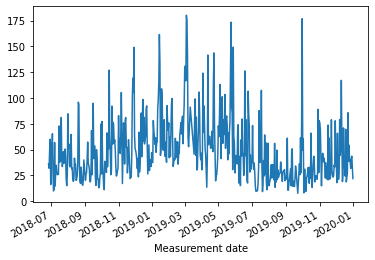

In [167]:
test['PM10'].plot()

<AxesSubplot:xlabel='Measurement date'>

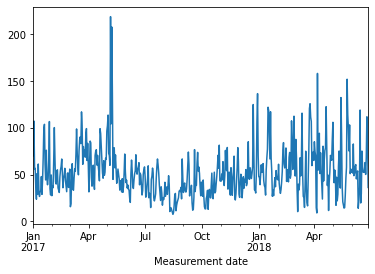

In [168]:
train['PM10'].plot()

#### Rolling Mean Difference Train

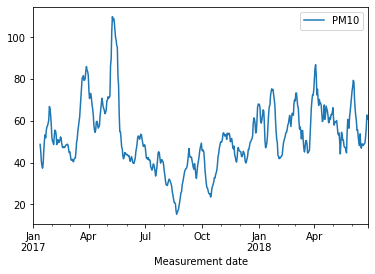

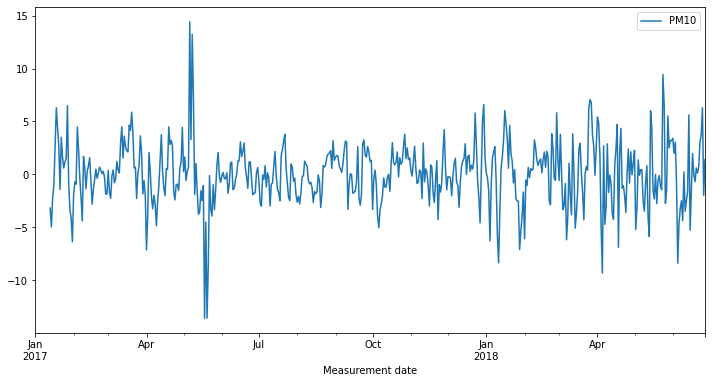

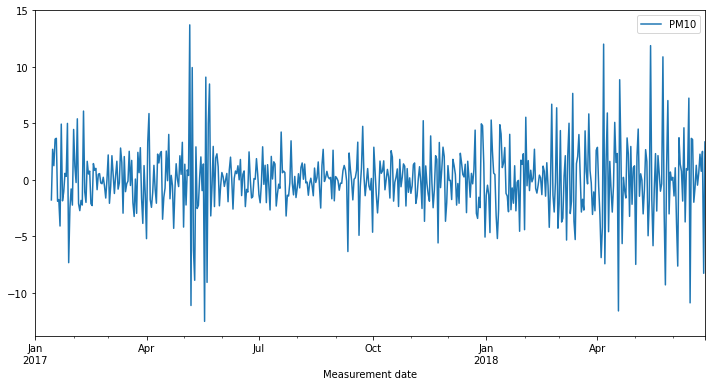

In [169]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_train = train.rolling(window=12).mean()
roll_mean_train.plot();

rm_diff_1 = roll_mean_train.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_train.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [170]:
print(stationarity_check(df_119['PM10']))
print(stationarity_check(rm_diff_1['PM10'].dropna()))
print(stationarity_check(rm_diff_2['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -7.403943e+00
p-value                        7.429371e-11
#Lags Used                     7.000000e+00
Number of Observations Used    1.077000e+03
Critical Value (1%)           -3.436436e+00
Critical Value (5%)           -2.864227e+00
Critical Value (10%)          -2.568201e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -8.463127e+00
p-value                        1.547937e-13
#Lags Used                     1.200000e+01
Number of Observations Used    5.180000e+02
Critical Value (1%)           -3.443037e+00
Critical Value (5%)           -2.867136e+00
Critical Value (10%)          -2.569750e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.045489e+01
p-value                        1.406997e-18
#Lags Used                     1.500000e+01
Number of Observations Used    5.140000e+02
Critical Value (1%)           -3.443136e+00
Critical Value (5%)      

#### Rolling Mean Difference Test

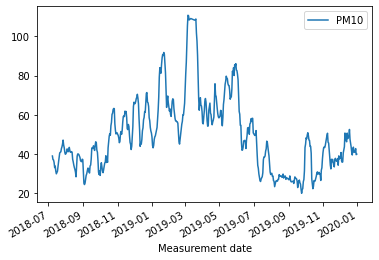

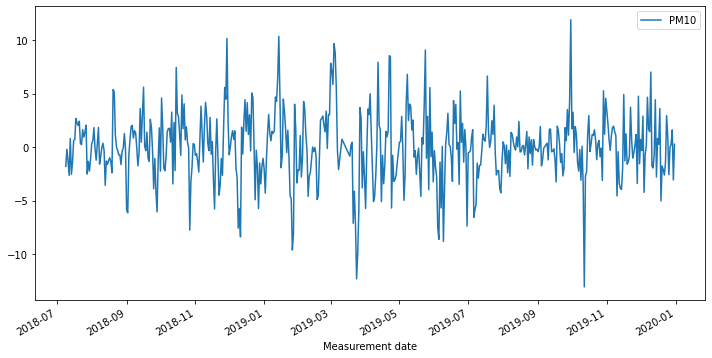

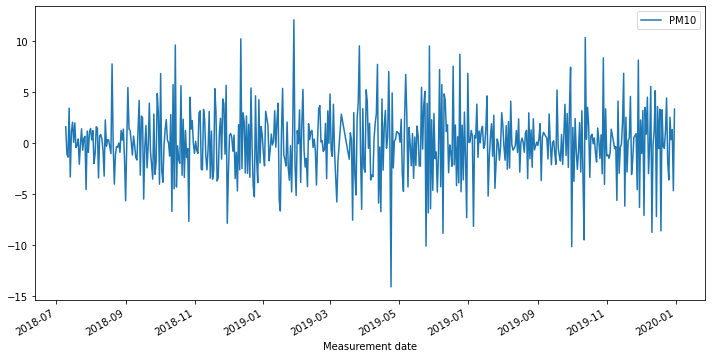

In [171]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_test = test.rolling(window=12).mean()
roll_mean_test.plot();

rm_diff_1 = roll_mean_test.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_test.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [172]:
print(stationarity_check(rm_diff_1['PM10'].dropna()))
print(stationarity_check(rm_diff_2['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -9.303426e+00
p-value                        1.096855e-15
#Lags Used                     1.200000e+01
Number of Observations Used    5.180000e+02
Critical Value (1%)           -3.443037e+00
Critical Value (5%)           -2.867136e+00
Critical Value (10%)          -2.569750e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.015707e+01
p-value                        7.679799e-18
#Lags Used                     1.700000e+01
Number of Observations Used    5.120000e+02
Critical Value (1%)           -3.443187e+00
Critical Value (5%)           -2.867202e+00
Critical Value (10%)          -2.569785e+00
dtype: float64
None


#### Station 119 PM10

In [173]:
base_model = sm.tsa.statespace.SARIMAX(df_119['PM10'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood               -5137.111
Date:                Wed, 27 Oct 2021   AIC                          10278.221
Time:                        16:08:12   BIC                          10288.200
Sample:                             0   HQIC                         10281.999
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0445      0.844     -0.053      0.958      -1.698       1.609
sigma2       765.2380     19.480     39.284      0.000     727.059     803.417
Ljung-Box (L1) (Q):                 103.72   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9950.501, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10276.224, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10169.519, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10068.063, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9951.884, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9951.850, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9979.035, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=10116.070, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9953.487, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=9952.440, Time=0.15 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.966 seconds


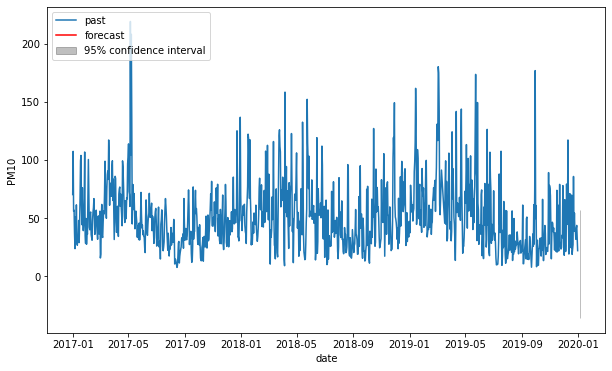

In [174]:
timeseries = df_119['PM10']
automodel = arimamodel(df_119['PM10'].diff().dropna())
plotarima(1, timeseries, automodel)

In [175]:
best_model = sm.tsa.statespace.SARIMAX(df_119['PM10'], trend='c', order=[1,0,1])
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1085
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -4988.951
Date:                Wed, 27 Oct 2021   AIC                           9985.901
Time:                        16:08:13   BIC                          10005.859
Sample:                             0   HQIC                          9993.456
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     15.0669      1.743      8.646      0.000      11.651      18.482
ar.L1          0.7020      0.030     23.570      0.000       0.644       0.760
ma.L1         -0.2494      0.042     -5.955      0.0

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [176]:
model_train = arima_results(train['PM10'],test['PM10'], order=[1,0,1])

Train RMSE: 22.53709047149155
Test RMSE: 34.95575314241667
Summary:                                SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                  543
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2462.091
Date:                Wed, 27 Oct 2021   AIC                           4932.183
Time:                        16:08:14   BIC                           4949.371
Sample:                    01-01-2017   HQIC                          4938.904
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.5799      2.982     17.633      0.000      46.736      58.424
ar.L1          0.6398      0.038     16.682      0.000       0.

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


# Station 120

In [177]:
df_120 = df[df['Station code'] == 120]

In [178]:
df_120.head()

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 120  0.005417  0.058292  0.003583  1.104167   
2017-01-02                 120  0.009417  0.045167  0.018000  1.270833   
2017-01-03                 120  0.004708  0.041167  0.017417  0.729167   
2017-01-04                 120  0.005000  0.055958  0.008958  0.862500   
2017-01-05                 120  0.003833  0.045333  0.008750  0.720833   

                       PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                         
2017-01-01        71.666667  57.666667    Normal     Normal         Bad  
2017-01-02        99.791667  82.041667    Normal        Bad    Very Bad  
2017-01-03        63.416667  45.500000    Normal     Normal         Bad  
2017-01-04        52.250000  35.333333    Normal     Normal         Bad  
2017-01-05        32.458333  23.958333    Normal     Normal      Normal

<AxesSubplot:xlabel='Year, Day', ylabel='NO2'>

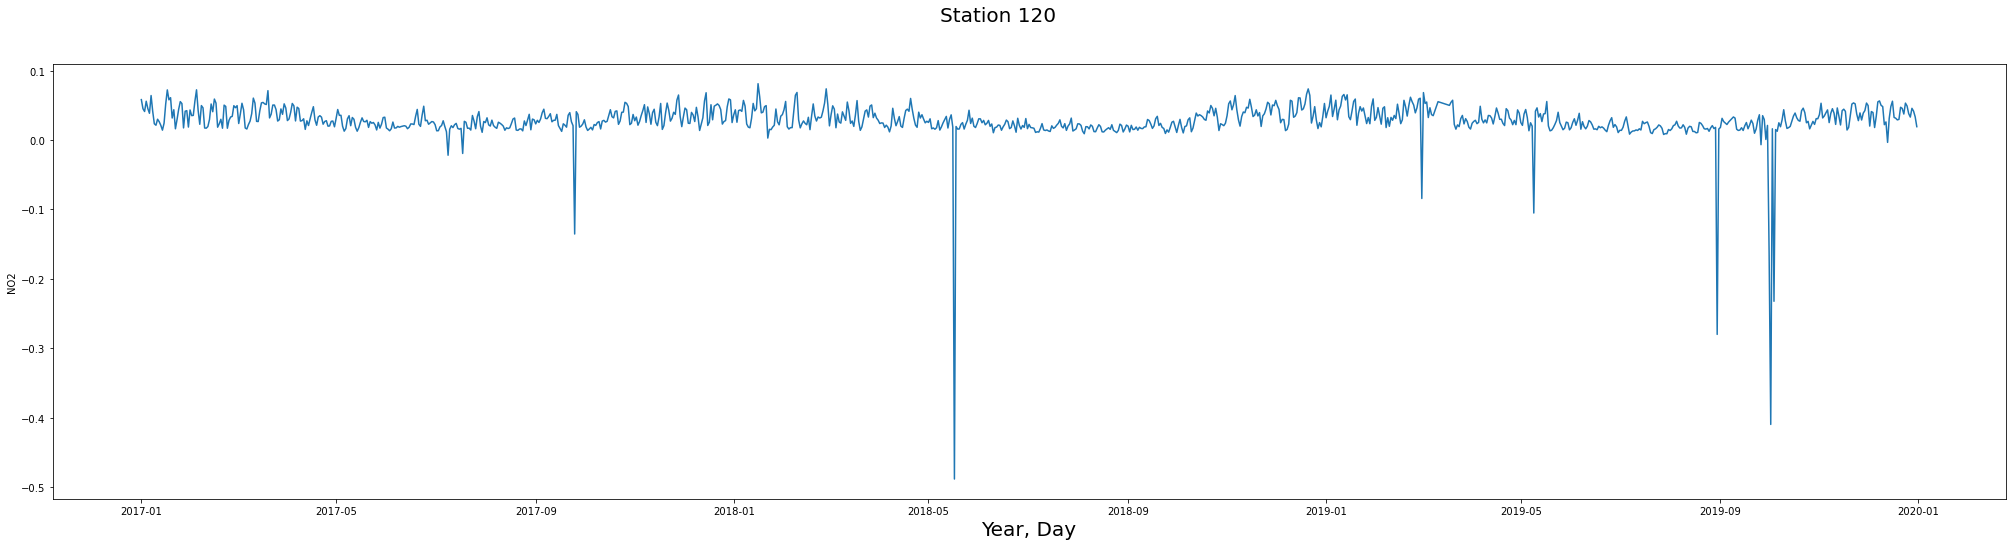

In [179]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 120", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='NO2', data=df_120)

In [180]:
df_120['NO2 Level'].value_counts()

Good      638
Normal    420
Bad        27
Name: NO2 Level, dtype: int64

###### For Station 120
- NO2 reaches levels of 'Bad' on 27 occasions and sits close to bad on most of the year.

#### Picking the relevant columns

In [181]:
columns = ['NO2']
df_120 = df_120[columns]
df_120

NO2
Measurement date          
2017-01-01        0.058292
2017-01-02        0.045167
2017-01-03        0.041167
2017-01-04        0.055958
2017-01-05        0.045333
...                    ...
2019-12-27        0.033125
2019-12-28        0.045750
2019-12-29        0.041667
2019-12-30        0.033500
2019-12-31        0.019292

[1085 rows x 1 columns]

In [182]:
train = df_120[:-542]
test = df_120[542:]

<AxesSubplot:xlabel='Measurement date'>

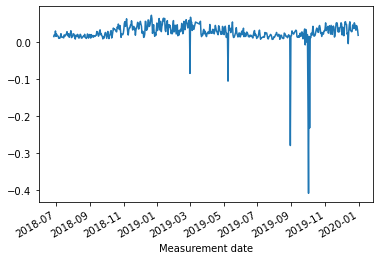

In [183]:
test['NO2'].plot()

<AxesSubplot:xlabel='Measurement date'>

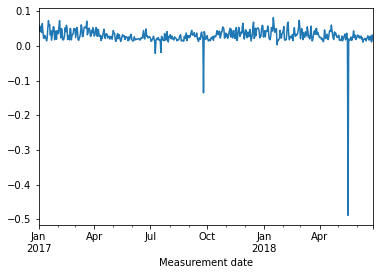

In [184]:
train['NO2'].plot()

#### Rolling Mean Difference Train

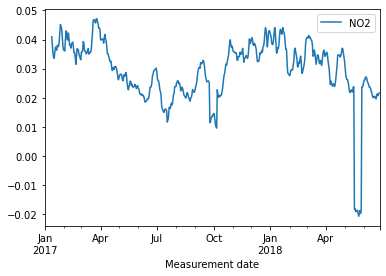

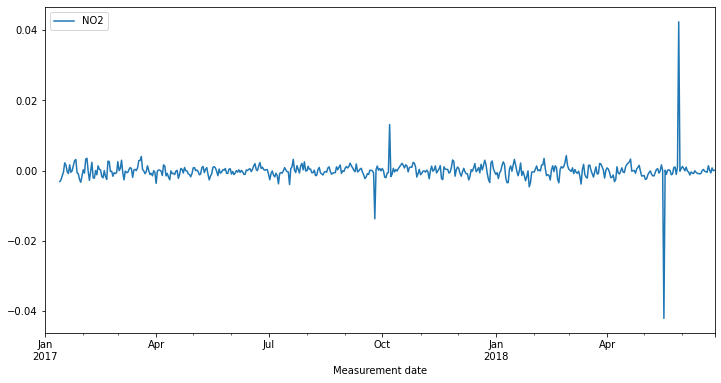

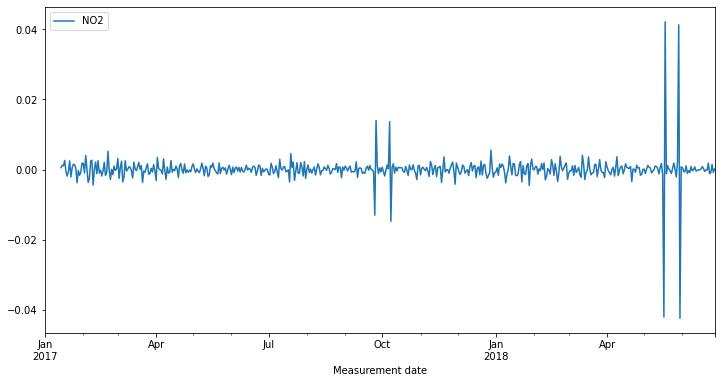

In [185]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_train = train.rolling(window=12).mean()
roll_mean_train.plot();

rm_diff_1 = roll_mean_train.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_train.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [186]:
print(stationarity_check(df_120['NO2']))
print(stationarity_check(rm_diff_1['NO2'].dropna()))
print(stationarity_check(rm_diff_2['NO2'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -1.397643e+01
p-value                        4.253526e-26
#Lags Used                     2.000000e+00
Number of Observations Used    1.082000e+03
Critical Value (1%)           -3.436408e+00
Critical Value (5%)           -2.864215e+00
Critical Value (10%)          -2.568194e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.095975e+01
p-value                        8.384321e-20
#Lags Used                     1.100000e+01
Number of Observations Used    5.190000e+02
Critical Value (1%)           -3.443013e+00
Critical Value (5%)           -2.867125e+00
Critical Value (10%)          -2.569745e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.012994e+01
p-value                        8.973408e-18
#Lags Used                     1.700000e+01
Number of Observations Used    5.120000e+02
Critical Value (1%)           -3.443187e+00
Critical Value (5%)      

#### Rolling Mean Difference Test

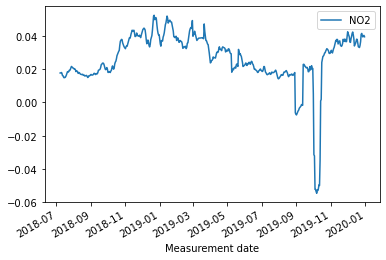

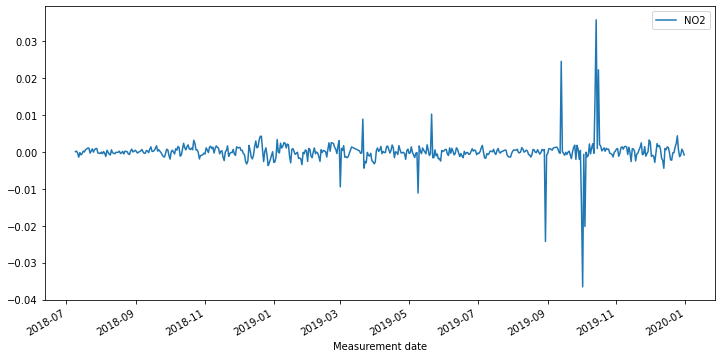

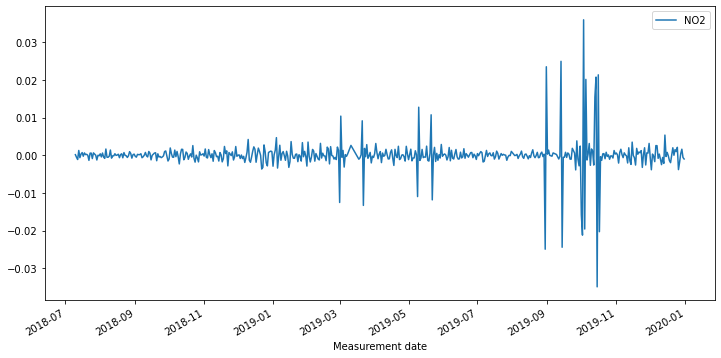

In [187]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_test = test.rolling(window=12).mean()
roll_mean_test.plot();

rm_diff_1 = roll_mean_test.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_test.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [188]:
print(stationarity_check(rm_diff_1['NO2'].dropna()))
print(stationarity_check(rm_diff_2['NO2'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -6.720978e+00
p-value                        3.483799e-09
#Lags Used                     1.900000e+01
Number of Observations Used    5.110000e+02
Critical Value (1%)           -3.443212e+00
Critical Value (5%)           -2.867213e+00
Critical Value (10%)          -2.569791e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -9.270218e+00
p-value                        1.333047e-15
#Lags Used                     1.800000e+01
Number of Observations Used    5.110000e+02
Critical Value (1%)           -3.443212e+00
Critical Value (5%)           -2.867213e+00
Critical Value (10%)          -2.569791e+00
dtype: float64
None


#### Station 120 NO2

In [189]:
base_model = sm.tsa.statespace.SARIMAX(df_120['NO2'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood                2073.262
Date:                Wed, 27 Oct 2021   AIC                          -4142.525
Time:                        16:08:15   BIC                          -4132.546
Sample:                             0   HQIC                         -4138.747
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.598e-05      0.001     -0.033      0.974      -0.002       0.002
sigma2         0.0013   7.43e-06    171.894      0.000       0.001       0.001
Ljung-Box (L1) (Q):                 252.83   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4692.866, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4144.524, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4429.022, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4674.839, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4702.083, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4509.884, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-4700.784, Time=0.29 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4691.285, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4671.991, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-4539.344, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-4698.295, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4699.287, Time=0.38 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 2.214 seconds


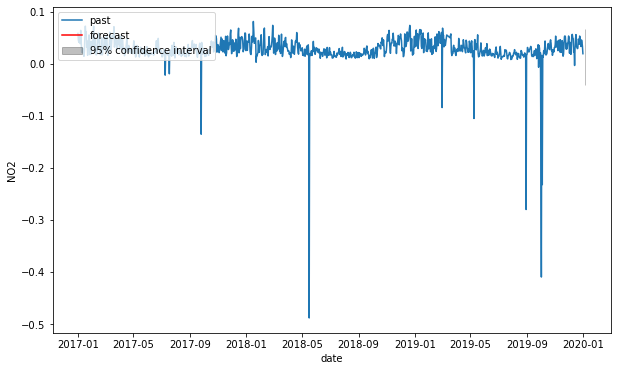

In [190]:
timeseries = df_120['NO2']
automodel = arimamodel(df_120['NO2'].diff().dropna())
plotarima(1, timeseries, automodel)

In [191]:
best_model = sm.tsa.statespace.SARIMAX(df_120['NO2'], trend='c', order=[2,0,1])
res = best_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1085
Model:               SARIMAX(2, 0, 1)   Log Likelihood                2351.566
Date:                Wed, 27 Oct 2021   AIC                          -4693.132
Time:                        16:08:18   BIC                          -4668.185
Sample:                             0   HQIC                         -4683.688
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0065      0.002      2.841      0.004       0.002       0.011
ar.L1          0.7394      0.100      7.403      0.000       0.544       0.935
ar.L2          0.0288      0.024      1.209      0.2

In [192]:
model_train = arima_results(train['NO2'],test['NO2'], order=[2,0,1])

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

Train RMSE: 0.02618306580280754
Test RMSE: 0.03337145033929495
Summary:                                SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                  543
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1207.400
Date:                Wed, 27 Oct 2021   AIC                          -2404.800
Time:                        16:08:18   BIC                          -2383.315
Sample:                    01-01-2017   HQIC                         -2396.399
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0294      0.007      4.437      0.000       0.016       0.042
ar.L1          1.0557      0.076     13.981      0.000     

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Station 121

In [193]:
df_121 = df[df['Station code'] == 121]

In [194]:
df_121.head()

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 121  0.006375  0.064333  0.005375  1.258333   
2017-01-02                 121  0.007833  0.047792  0.016667  0.975000   
2017-01-03                 121  0.006917  0.048583  0.013875  0.816667   
2017-01-04                 121  0.006750  0.063958  0.008792  1.000000   
2017-01-05                 121  0.005542  0.049667  0.007667  0.695833   

                       PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                         
2017-01-01        74.958333  55.750000       Bad     Normal         Bad  
2017-01-02        95.375000  67.916667    Normal        Bad         Bad  
2017-01-03        64.291667  42.083333    Normal     Normal         Bad  
2017-01-04        54.666667  37.000000       Bad     Normal         Bad  
2017-01-05        33.708333  24.541667    Normal     Normal      Normal

<AxesSubplot:xlabel='Year, Day', ylabel='NO2'>

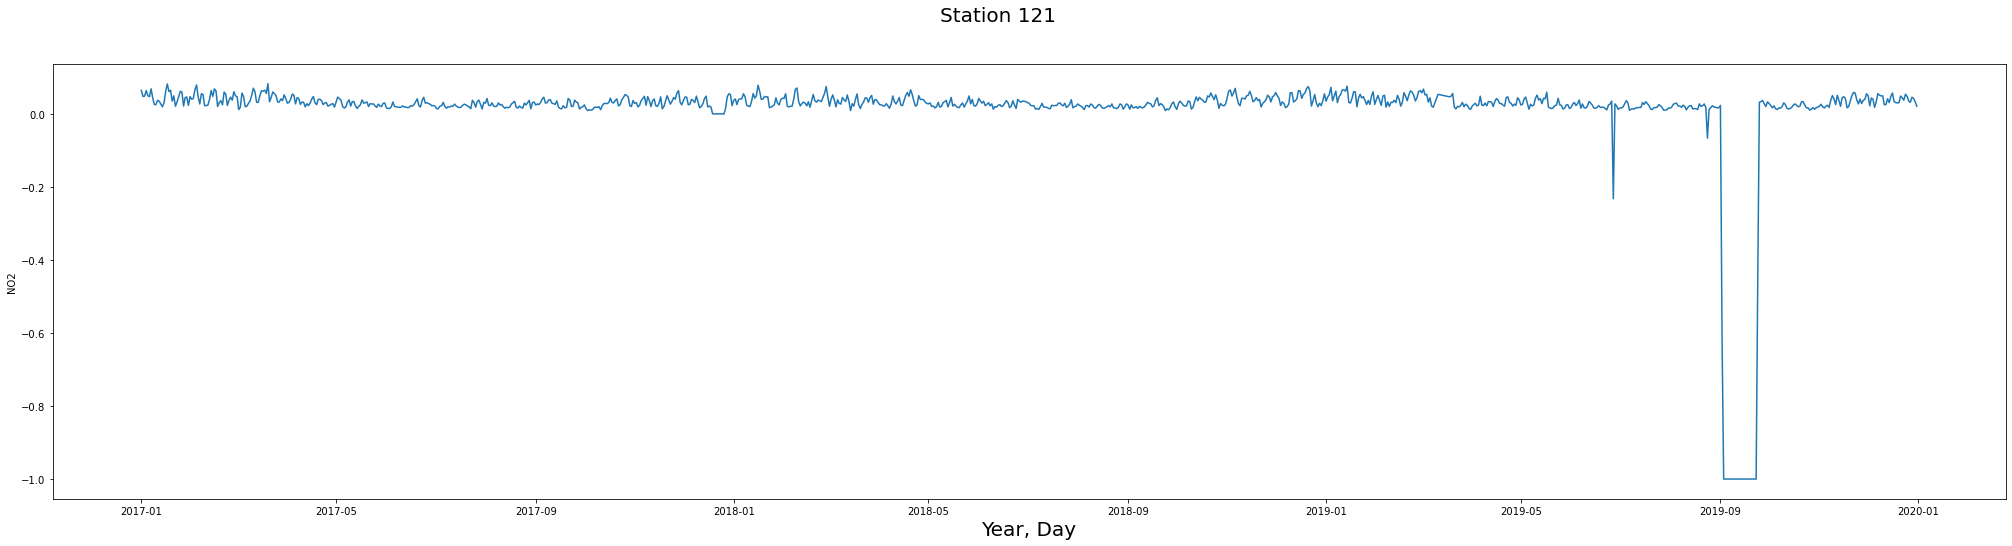

In [195]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 121", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='NO2', data=df_121)

<AxesSubplot:xlabel='Year, Day', ylabel='PM2.5'>

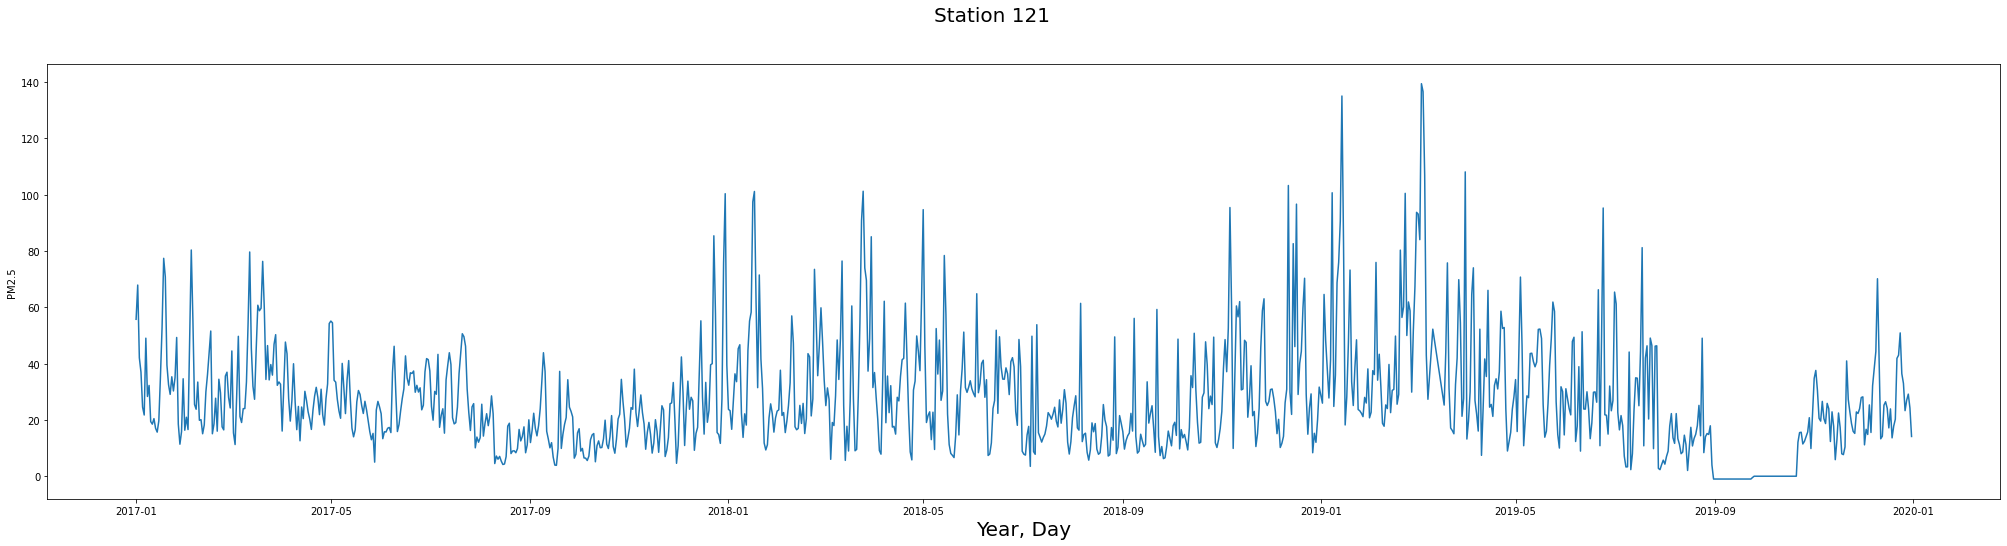

In [196]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 121", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='PM2.5', data=df_121)

In [197]:
df_121['NO2 Level'].value_counts()

Good      603
Normal    433
Bad        49
Name: NO2 Level, dtype: int64

In [198]:
df_121['PM2.5 Level'].value_counts()

Normal      521
Good        283
Bad         244
Very Bad     37
Name: PM2.5 Level, dtype: int64

###### For Station 121
- NO2 reaches levels of 'Bad' on 49 occasions and sits close to bad on most of the year.
- PM2.5 reaches levels of 'Bad' on 244 occasions and 'Very Bad' on 37 occasions.

#### Picking the relevant columns

In [199]:
columns = ['NO2', 'PM2.5']
df_121 = df_121[columns]
df_121

NO2      PM2.5
Measurement date                     
2017-01-01        0.064333  55.750000
2017-01-02        0.047792  67.916667
2017-01-03        0.048583  42.083333
2017-01-04        0.063958  37.000000
2017-01-05        0.049667  24.541667
...                    ...        ...
2019-12-27        0.031542  23.291667
2019-12-28        0.045542  27.000000
2019-12-29        0.042500  29.166667
2019-12-30        0.033208  24.250000
2019-12-31        0.021042  14.125000

[1085 rows x 2 columns]

In [200]:
train = df_121[:-542]
test = df_121[542:]

<AxesSubplot:xlabel='Measurement date'>

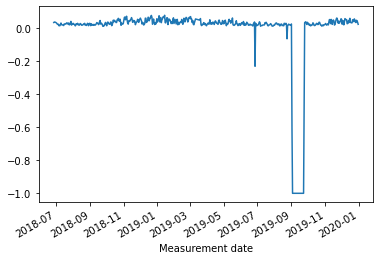

In [201]:
test['NO2'].plot()

<AxesSubplot:xlabel='Measurement date'>

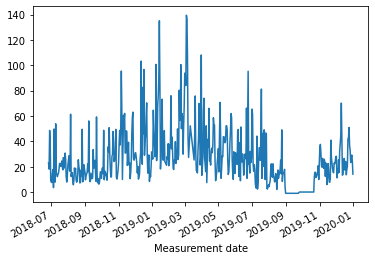

In [202]:
test['PM2.5'].plot()

<AxesSubplot:xlabel='Measurement date'>

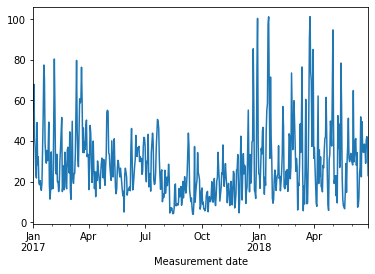

In [203]:
train['PM2.5'].plot()

In [204]:
print(stationarity_check(df_121['PM2.5']))
print(stationarity_check(df_121['NO2']))

Results of Dickey-Fuller Test: 

Test Statistic                -6.746870e+00
p-value                        3.019493e-09
#Lags Used                     7.000000e+00
Number of Observations Used    1.077000e+03
Critical Value (1%)           -3.436436e+00
Critical Value (5%)           -2.864227e+00
Critical Value (10%)          -2.568201e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                   -4.308098
p-value                           0.000430
#Lags Used                       22.000000
Number of Observations Used    1062.000000
Critical Value (1%)              -3.436522
Critical Value (5%)              -2.864265
Critical Value (10%)             -2.568221
dtype: float64
None


#### Rolling Mean Difference Train

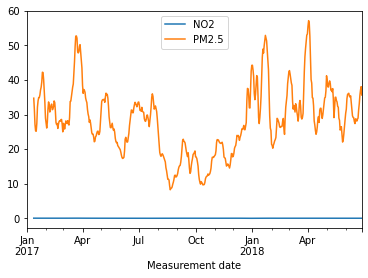

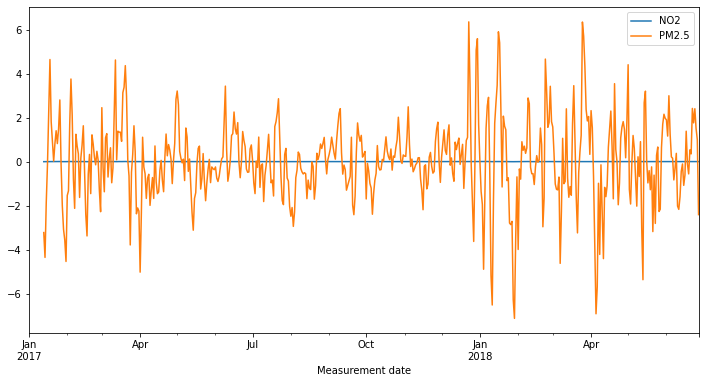

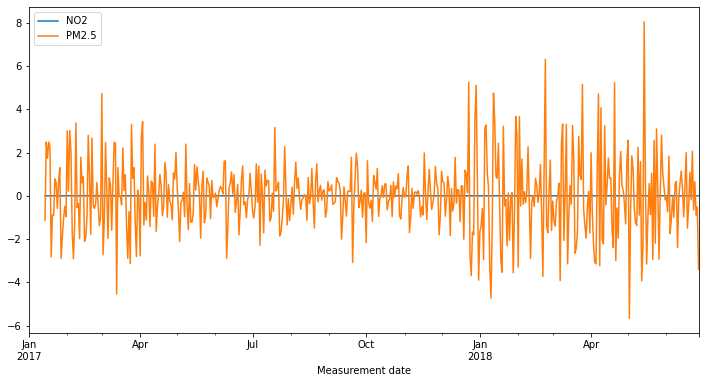

In [205]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_train = train.rolling(window=12).mean()
roll_mean_train.plot();

rm_diff_1 = roll_mean_train.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_train.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [206]:
print(stationarity_check(rm_diff_1['PM2.5'].dropna()))
print(stationarity_check(rm_diff_1['NO2'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -7.405284e+00
p-value                        7.372483e-11
#Lags Used                     1.300000e+01
Number of Observations Used    5.170000e+02
Critical Value (1%)           -3.443062e+00
Critical Value (5%)           -2.867147e+00
Critical Value (10%)          -2.569756e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -7.703248e+00
p-value                        1.322089e-11
#Lags Used                     1.200000e+01
Number of Observations Used    5.180000e+02
Critical Value (1%)           -3.443037e+00
Critical Value (5%)           -2.867136e+00
Critical Value (10%)          -2.569750e+00
dtype: float64
None


In [207]:
print(stationarity_check(rm_diff_2['PM2.5'].dropna()))
print(stationarity_check(rm_diff_2['NO2'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -1.105103e+01
p-value                        5.079565e-20
#Lags Used                     1.500000e+01
Number of Observations Used    5.140000e+02
Critical Value (1%)           -3.443136e+00
Critical Value (5%)           -2.867179e+00
Critical Value (10%)          -2.569774e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.041680e+01
p-value                        1.745914e-18
#Lags Used                     1.500000e+01
Number of Observations Used    5.140000e+02
Critical Value (1%)           -3.443136e+00
Critical Value (5%)           -2.867179e+00
Critical Value (10%)          -2.569774e+00
dtype: float64
None


#### Rolling Mean Difference Test

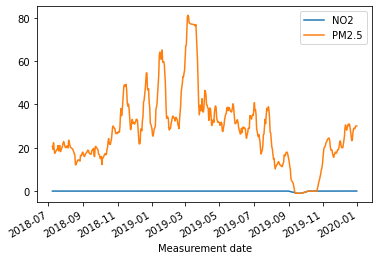

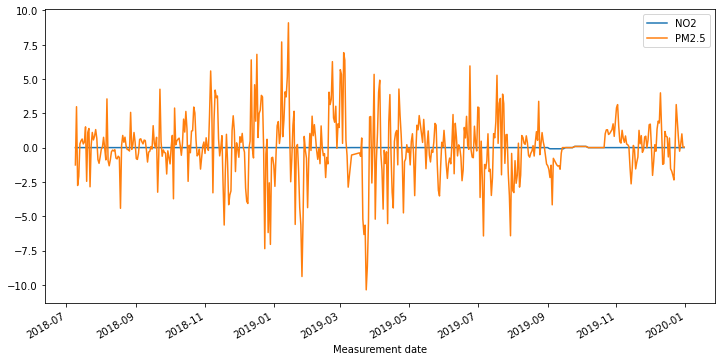

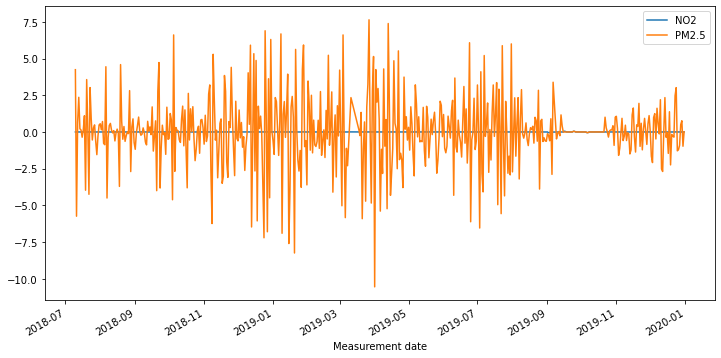

In [208]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_test = test.rolling(window=12).mean()
roll_mean_test.plot();

rm_diff_1 = roll_mean_test.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_test.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [209]:
print(stationarity_check(rm_diff_1['PM2.5'].dropna()))
print(stationarity_check(rm_diff_1['NO2'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -8.701723e+00
p-value                        3.793406e-14
#Lags Used                     1.200000e+01
Number of Observations Used    5.180000e+02
Critical Value (1%)           -3.443037e+00
Critical Value (5%)           -2.867136e+00
Critical Value (10%)          -2.569750e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -6.831820e+00
p-value                        1.885236e-09
#Lags Used                     1.800000e+01
Number of Observations Used    5.120000e+02
Critical Value (1%)           -3.443187e+00
Critical Value (5%)           -2.867202e+00
Critical Value (10%)          -2.569785e+00
dtype: float64
None


In [210]:
print(stationarity_check(rm_diff_2['PM2.5'].dropna()))
print(stationarity_check(rm_diff_2['NO2'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -9.757712e+00
p-value                        7.709743e-17
#Lags Used                     1.800000e+01
Number of Observations Used    5.110000e+02
Critical Value (1%)           -3.443212e+00
Critical Value (5%)           -2.867213e+00
Critical Value (10%)          -2.569791e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -8.629638e+00
p-value                        5.802438e-14
#Lags Used                     1.900000e+01
Number of Observations Used    5.100000e+02
Critical Value (1%)           -3.443237e+00
Critical Value (5%)           -2.867224e+00
Critical Value (10%)          -2.569797e+00
dtype: float64
None


#### Station 121 PM2.5

In [211]:
base_model = sm.tsa.statespace.SARIMAX(df_121['PM2.5'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood               -4644.212
Date:                Wed, 27 Oct 2021   AIC                           9292.424
Time:                        16:08:20   BIC                           9302.403
Sample:                             0   HQIC                          9296.201
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0384      0.542     -0.071      0.943      -1.100       1.023
sigma2       308.2095      7.987     38.590      0.000     292.556     323.863
Ljung-Box (L1) (Q):                  57.28   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9013.978, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9290.429, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9233.816, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9151.844, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9013.396, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9147.032, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=9009.534, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=9130.887, Time=0.03 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=9010.169, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=9006.396, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9005.851, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9012.056, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=9006.416, Time=0.38 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=9008.485, Time=0.43 sec
 ARIMA(3,0,3)(0,0,0)[0]          

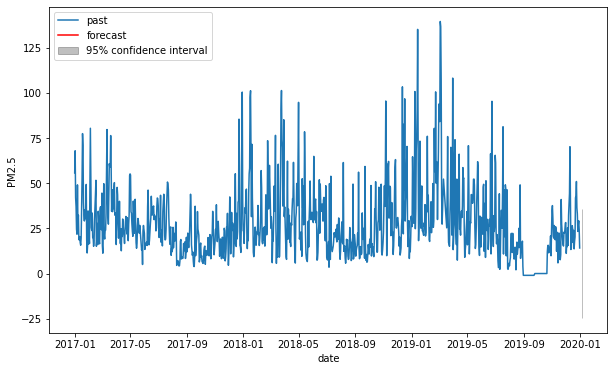

In [212]:
timeseries = df_121['PM2.5']
automodel = arimamodel(df_121['PM2.5'].diff().dropna())
plotarima(1, timeseries, automodel)

In [213]:
best_model = sm.tsa.statespace.SARIMAX(df_121['PM2.5'].diff(), trend='c', order=[3,0,2])
res = best_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1085
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -4497.170
Date:                Wed, 27 Oct 2021   AIC                           9008.340
Time:                        16:08:24   BIC                           9043.265
Sample:                             0   HQIC                          9021.561
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0090      0.047     -0.192      0.848      -0.101       0.083
ar.L1         -0.1577      0.133     -1.183      0.237      -0.419       0.104
ar.L2          0.2382      0.073      3.272      0.0

In [214]:
model_train = arima_results(train['PM2.5'],test['PM2.5'], order=[3,0,2])

Train RMSE: 13.047771733180552
Test RMSE: 26.175002476365282
Summary:                                SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                  543
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -2164.581
Date:                Wed, 27 Oct 2021   AIC                           4343.162
Time:                        16:08:24   BIC                           4373.242
Sample:                    01-01-2017   HQIC                          4354.923
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.5263      1.857     15.362      0.000      24.887      32.166
ar.L1          0.2984      2.185      0.137      0.891      -

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

#### Station 121 NO2

In [215]:
base_model = sm.tsa.statespace.SARIMAX(df_121['NO2'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood                2068.336
Date:                Wed, 27 Oct 2021   AIC                          -4132.672
Time:                        16:08:24   BIC                          -4122.693
Sample:                             0   HQIC                         -4128.894
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.994e-05      0.001     -0.037      0.971      -0.002       0.002
sigma2         0.0013   5.71e-06    225.776      0.000       0.001       0.001
Ljung-Box (L1) (Q):                  91.11   Jarque-

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4249.590, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4134.671, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4227.419, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4249.278, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4247.543, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4247.567, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-4249.533, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4244.557, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4245.585, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4247.604, Time=0.22 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.067 seconds


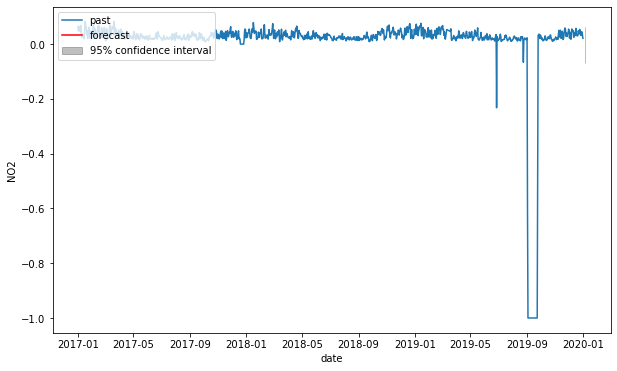

In [216]:
timeseries = df_121['NO2']
automodel = arimamodel(df_121['NO2'].diff().dropna())
plotarima(1, timeseries, automodel)

In [217]:
best_model = sm.tsa.statespace.SARIMAX(df_121['NO2'].diff(), trend='c', order=[1,0,1])
res = best_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1085
Model:               SARIMAX(1, 0, 1)   Log Likelihood                2127.802
Date:                Wed, 27 Oct 2021   AIC                          -4247.604
Time:                        16:08:26   BIC                          -4227.647
Sample:                             0   HQIC                         -4240.049
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5.734e-05      0.002     -0.038      0.970      -0.003       0.003
ar.L1         -0.1329      0.052     -2.539      0.011      -0.236      -0.030
ma.L1          0.4704      0.051      9.153      0.0

In [218]:
model_train = arima_results(train['NO2'],test['NO2'], order=[1,0,1])

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Train RMSE: 0.011355327626139514
Test RMSE: 0.1973809976347759
Summary:                                SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                  543
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1662.305
Date:                Wed, 27 Oct 2021   AIC                          -3316.611
Time:                        16:08:26   BIC                          -3299.422
Sample:                    01-01-2017   HQIC                         -3309.890
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0321      0.001     29.053      0.000       0.030       0.034
ar.L1          0.3420      0.057      6.008      0.000     

# Station 122

In [219]:
df_122 = df[df['Station code'] == 122]

In [220]:
df_122.head()

Station code       SO2       NO2        O3        CO  \
Measurement date                                                         
2017-01-01                 122  0.005292  0.041500  0.005000  1.195833   
2017-01-02                 122  0.006000  0.036917  0.021458  0.925000   
2017-01-03                 122  0.005667  0.039750  0.018000  0.725000   
2017-01-04                 122  0.005417  0.047500  0.011792  0.895833   
2017-01-05                 122  0.004917  0.038375  0.013292  0.795833   

                        PM10      PM2.5 NO2 Level PM10 Level PM2.5 Level  
Measurement date                                                          
2017-01-01         87.250000  51.208333    Normal        Bad         Bad  
2017-01-02        122.958333  68.250000    Normal        Bad         Bad  
2017-01-03         76.166667  39.166667    Normal     Normal         Bad  
2017-01-04         55.708333  28.041667    Normal     Normal      Normal  
2017-01-05         37.708333  17.625000    Normal     Normal      Normal

<AxesSubplot:xlabel='Year, Day', ylabel='PM10'>

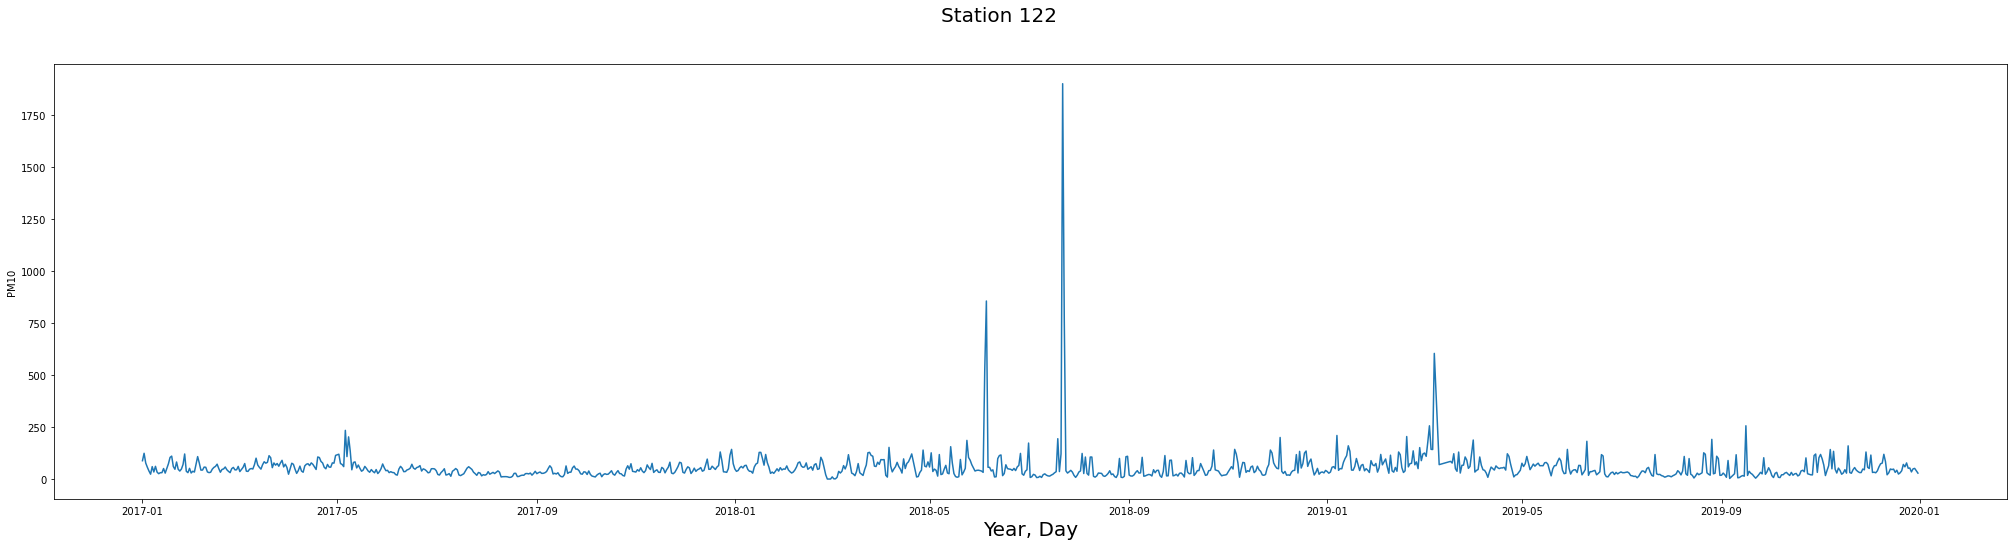

In [221]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 122", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='PM10', data=df_122)

<AxesSubplot:xlabel='Year, Day', ylabel='PM2.5'>

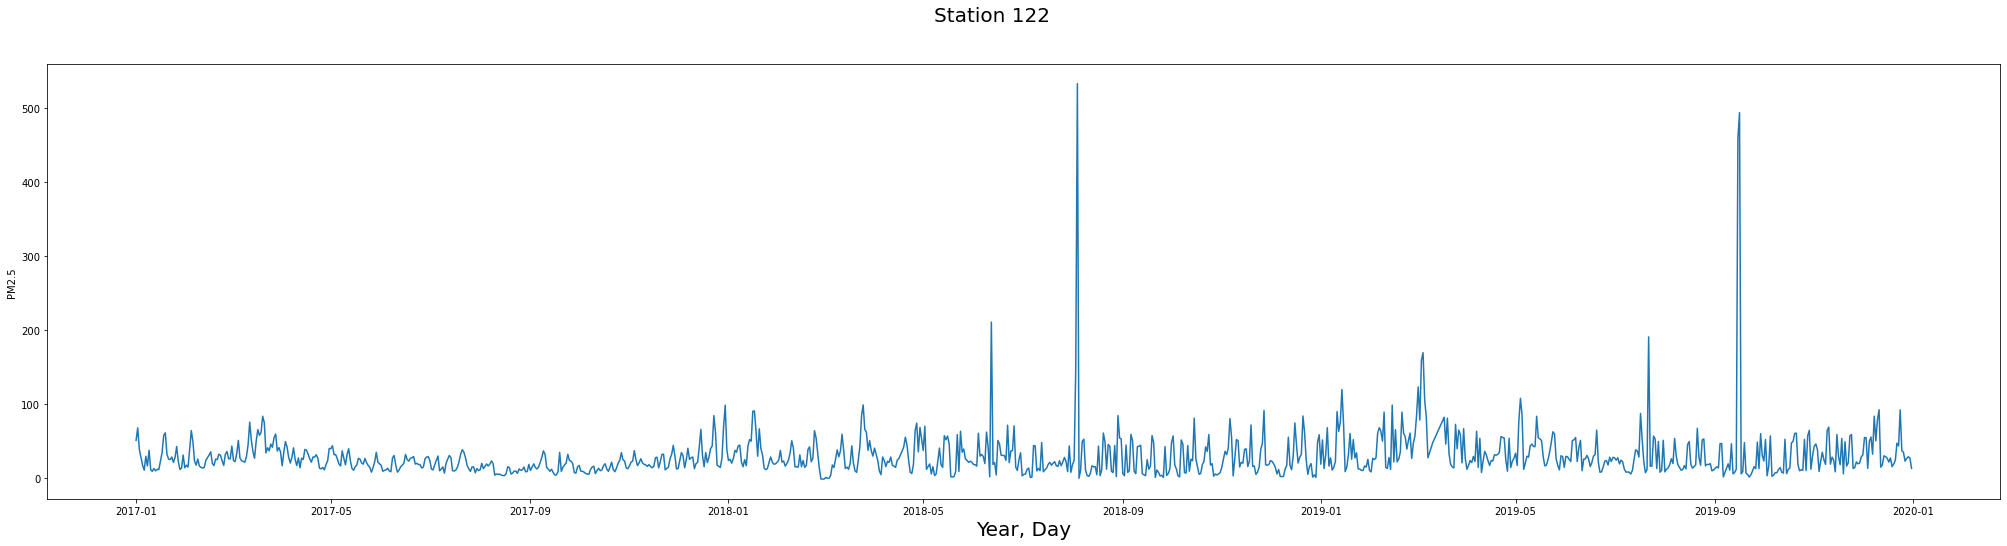

In [222]:
fig, ax = plt.subplots(figsize=(35,8))
fig.suptitle("Station 122", fontsize=20)
ax.set_xlabel('Year, Day', fontsize=20)
sns.lineplot(x='Measurement date', y='PM2.5', data=df_122)

In [223]:
df_122['PM10 Level'].value_counts()

Normal      571
Good        349
Bad         141
Very Bad     20
Name: PM10 Level, dtype: int64

In [224]:
df_122['PM2.5 Level'].value_counts()

Normal      476
Good        306
Bad         259
Very Bad     43
Name: PM2.5 Level, dtype: int64

##### For Station 122
- PM10 reaches levels of 'Bad' on 141 occasions and 'Very Bad' on 20, and can get close to bad on many occasions.
- PM2.5 reaches levels of 'Bad' on 259 occasions and 'Very Bad' on 43 occasions.

#### Picking the relevant columns

In [225]:
columns = ['PM10', 'PM2.5']
df_122 = df_122[columns]
df_122

PM10      PM2.5
Measurement date                       
2017-01-01         87.250000  51.208333
2017-01-02        122.958333  68.250000
2017-01-03         76.166667  39.166667
2017-01-04         55.708333  28.041667
2017-01-05         37.708333  17.625000
...                      ...        ...
2019-12-27         33.291667  23.208333
2019-12-28         48.000000  26.833333
2019-12-29         50.250000  29.125000
2019-12-30         38.916667  27.291667
2019-12-31         27.458333  13.375000

[1085 rows x 2 columns]

#### Train-Test Split

In [226]:
train = df_122[:-542]
test = df_122[542:]

<AxesSubplot:xlabel='Measurement date'>

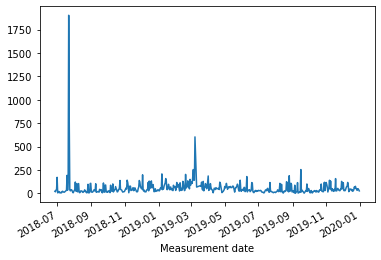

In [227]:
test['PM10'].plot()

<AxesSubplot:xlabel='Measurement date'>

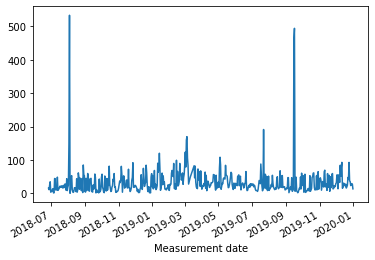

In [228]:
test['PM2.5'].plot()

<AxesSubplot:xlabel='Measurement date'>

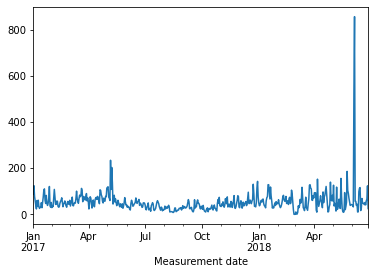

In [229]:
train['PM10'].plot()

<AxesSubplot:xlabel='Measurement date'>

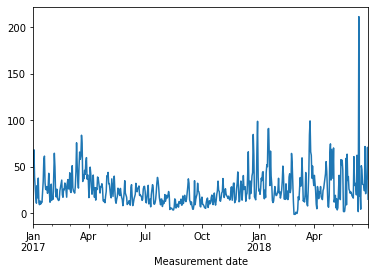

In [230]:
train['PM2.5'].plot()

#### Rolling Mean Difference Train

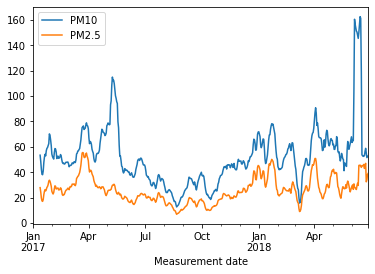

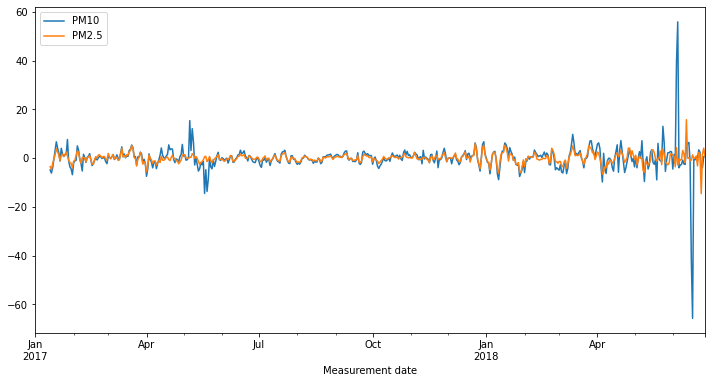

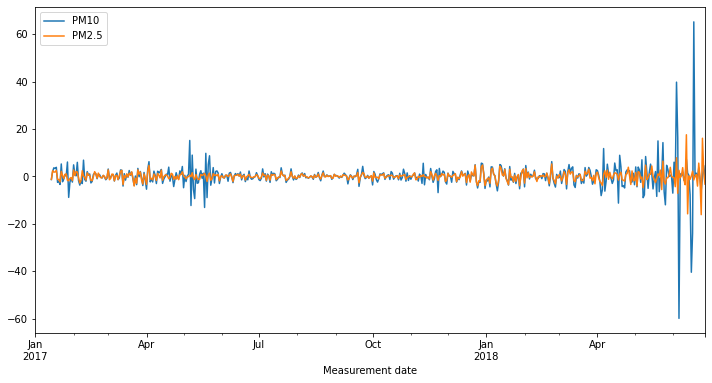

In [231]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_train = train.rolling(window=12).mean()
roll_mean_train.plot();

rm_diff_1 = roll_mean_train.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_train.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [232]:
print(stationarity_check(df_122['PM2.5']))
print(stationarity_check(df_122['PM10']))

Results of Dickey-Fuller Test: 

Test Statistic                -1.568992e+01
p-value                        1.438029e-28
#Lags Used                     2.000000e+00
Number of Observations Used    1.082000e+03
Critical Value (1%)           -3.436408e+00
Critical Value (5%)           -2.864215e+00
Critical Value (10%)          -2.568194e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.538833e+01
p-value                        3.335755e-28
#Lags Used                     2.000000e+00
Number of Observations Used    1.082000e+03
Critical Value (1%)           -3.436408e+00
Critical Value (5%)           -2.864215e+00
Critical Value (10%)          -2.568194e+00
dtype: float64
None


In [233]:
print(stationarity_check(rm_diff_1['PM2.5'].dropna()))
print(stationarity_check(rm_diff_1['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -6.033681e+00
p-value                        1.398426e-07
#Lags Used                     1.900000e+01
Number of Observations Used    5.110000e+02
Critical Value (1%)           -3.443212e+00
Critical Value (5%)           -2.867213e+00
Critical Value (10%)          -2.569791e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -7.750322e+00
p-value                        1.006059e-11
#Lags Used                     1.400000e+01
Number of Observations Used    5.160000e+02
Critical Value (1%)           -3.443087e+00
Critical Value (5%)           -2.867158e+00
Critical Value (10%)          -2.569762e+00
dtype: float64
None


In [234]:
print(stationarity_check(rm_diff_2['PM2.5'].dropna()))
print(stationarity_check(rm_diff_2['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -8.361606e+00
p-value                        2.813798e-13
#Lags Used                     1.800000e+01
Number of Observations Used    5.110000e+02
Critical Value (1%)           -3.443212e+00
Critical Value (5%)           -2.867213e+00
Critical Value (10%)          -2.569791e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.014881e+01
p-value                        8.052384e-18
#Lags Used                     1.900000e+01
Number of Observations Used    5.100000e+02
Critical Value (1%)           -3.443237e+00
Critical Value (5%)           -2.867224e+00
Critical Value (10%)          -2.569797e+00
dtype: float64
None


#### Rolling Mean Difference Test

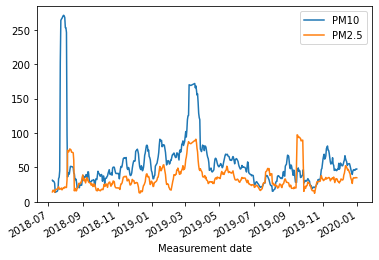

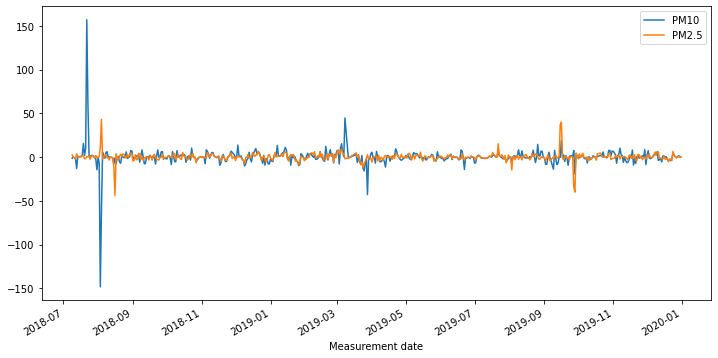

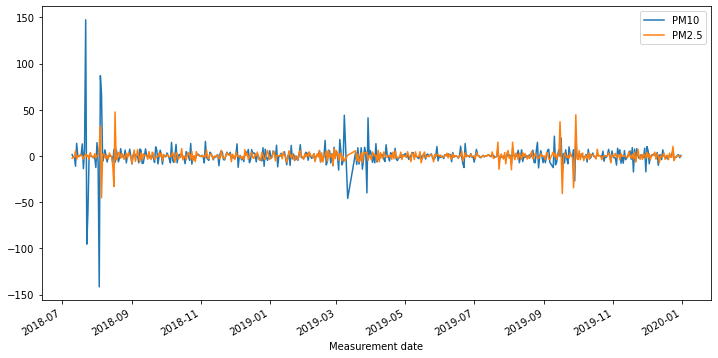

In [235]:
# Apply a 1st order difference to the time series and plot the rolling mean

roll_mean_test = test.rolling(window=12).mean()
roll_mean_test.plot();

rm_diff_1 = roll_mean_test.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean_test.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

In [236]:
print(stationarity_check(rm_diff_1['PM2.5'].dropna()))
print(stationarity_check(rm_diff_1['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -9.181694e+00
p-value                        2.242949e-15
#Lags Used                     1.300000e+01
Number of Observations Used    5.170000e+02
Critical Value (1%)           -3.443062e+00
Critical Value (5%)           -2.867147e+00
Critical Value (10%)          -2.569756e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -8.947612e+00
p-value                        8.900465e-15
#Lags Used                     1.200000e+01
Number of Observations Used    5.180000e+02
Critical Value (1%)           -3.443037e+00
Critical Value (5%)           -2.867136e+00
Critical Value (10%)          -2.569750e+00
dtype: float64
None


In [237]:
print(stationarity_check(rm_diff_2['PM2.5'].dropna()))
print(stationarity_check(rm_diff_2['PM10'].dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                -1.056871e+01
p-value                        7.400603e-19
#Lags Used                     1.800000e+01
Number of Observations Used    5.110000e+02
Critical Value (1%)           -3.443212e+00
Critical Value (5%)           -2.867213e+00
Critical Value (10%)          -2.569791e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                -1.127107e+01
p-value                        1.536446e-20
#Lags Used                     1.600000e+01
Number of Observations Used    5.130000e+02
Critical Value (1%)           -3.443162e+00
Critical Value (5%)           -2.867190e+00
Critical Value (10%)          -2.569780e+00
dtype: float64
None


#### Station 122 PM2.5

In [238]:
base_model = sm.tsa.statespace.SARIMAX(df_122['PM2.5'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood               -5459.560
Date:                Wed, 27 Oct 2021   AIC                          10923.120
Time:                        16:08:28   BIC                          10933.098
Sample:                             0   HQIC                         10926.897
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0349      1.158     -0.030      0.976      -2.304       2.234
sigma2      1387.2956      8.713    159.219      0.000    1370.218    1404.373
Ljung-Box (L1) (Q):                  71.00   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10921.121, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10850.017, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10649.623, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=10501.366, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10503.162, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=10503.194, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=10505.284, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 1.067 seconds


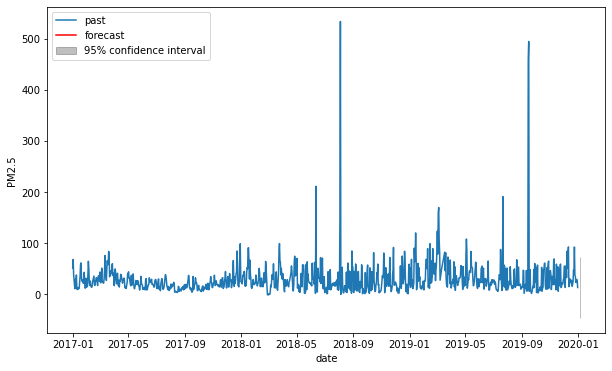

In [239]:
timeseries = df_122['PM2.5']
automodel = arimamodel(df_122['PM2.5'].diff().dropna())
plotarima(1, timeseries, automodel)

In [240]:
best_model = sm.tsa.statespace.SARIMAX(df_122['PM2.5'].diff(), trend='c', order=[1,0,2])
res = best_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1085
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -5247.373
Date:                Wed, 27 Oct 2021   AIC                          10504.746
Time:                        16:08:30   BIC                          10529.693
Sample:                             0   HQIC                         10514.190
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0120      0.006      1.980      0.048       0.000       0.024
ar.L1          0.0671      0.034      1.961      0.050    2.74e-05       0.134
ma.L1         -0.6608      0.249     -2.658      0.0

In [241]:
model_train = arima_results(train['PM2.5'],test['PM2.5'], order=[1,0,2])

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Train RMSE: 16.199226053590568
Test RMSE: 44.66839182784352
Summary:                                SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                  543
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2282.566
Date:                Wed, 27 Oct 2021   AIC                           4575.133
Time:                        16:08:30   BIC                           4596.618
Sample:                    01-01-2017   HQIC                          4583.534
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.7676      3.822      7.004      0.000      19.277      34.258
ar.L1          0.9538      0.038     25.128      0.000       0

#### Station 122 PM10

In [242]:
base_model = sm.tsa.statespace.SARIMAX(df_122['PM10'].diff(), trend='c', order=[0,0,0])
res = base_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1085
Model:                        SARIMAX   Log Likelihood               -6377.313
Date:                Wed, 27 Oct 2021   AIC                          12758.625
Time:                        16:08:30   BIC                          12768.604
Sample:                             0   HQIC                         12762.403
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0552      2.799     -0.020      0.984      -5.540       5.430
sigma2      7543.0537     33.963    222.095      0.000    7476.487    7609.621
Ljung-Box (L1) (Q):                  67.04   Jarque-

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12756.626, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12689.735, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12488.674, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=12332.864, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=12334.715, Time=0.34 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=12334.745, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=12336.035, Time=0.50 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=12334.838, Time=0.28 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 1.967 seconds


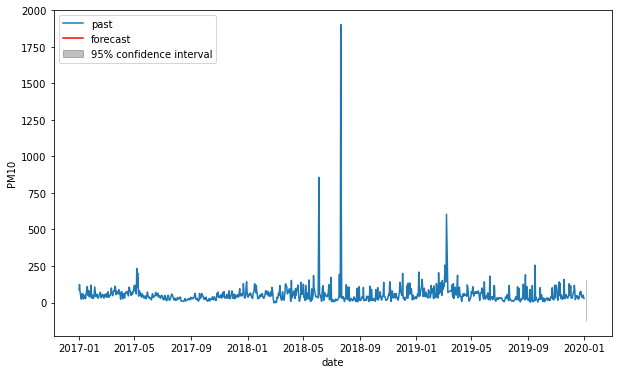

In [243]:
timeseries = df_122['PM10']
automodel = arimamodel(df_122['PM10'].diff().dropna())
plotarima(1, timeseries, automodel)

In [244]:
best_model = sm.tsa.statespace.SARIMAX(df_122['PM10'].diff(), trend='c', order=[1,0,2])
res = best_model.fit(disp=False)
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1085
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -6163.346
Date:                Wed, 27 Oct 2021   AIC                          12336.692
Time:                        16:08:33   BIC                          12361.638
Sample:                             0   HQIC                         12346.136
                               - 1085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0087      0.113     -0.077      0.939      -0.231       0.214
ar.L1         -0.0315      0.079     -0.400      0.689      -0.186       0.123
ma.L1         -0.5450      0.082     -6.639      0.0

In [245]:
model_train = arima_results(train['PM10'],test['PM10'], order=[1,0,2])

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Train RMSE: 43.077945145447224
Test RMSE: 100.84266376585359
Summary:                                SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                  543
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2813.938
Date:                Wed, 27 Oct 2021   AIC                           5637.876
Time:                        16:08:33   BIC                           5659.362
Sample:                    01-01-2017   HQIC                          5646.277
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.8106     13.494      3.988      0.000      27.363      80.258
ar.L1          0.9845      0.036     27.393      0.000       

In [246]:
model_train = arima_results(train['PM2.5'],test['PM2.5'], order=[2,0,1])

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Train RMSE: 16.058458866864534
Test RMSE: 44.75592910844834
Summary:                                SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                  543
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2277.850
Date:                Wed, 27 Oct 2021   AIC                           4565.700
Time:                        16:08:34   BIC                           4587.186
Sample:                    01-01-2017   HQIC                          4574.101
                         - 06-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.1694      4.743      5.728      0.000      17.872      36.466
ar.L1          1.3389      0.048     27.898      0.000       1

# 6. Visualizations

<AxesSubplot:>

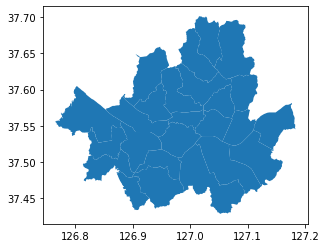

In [247]:
gdf.plot()

In [248]:
seoul = ('Seoul')
gdf = geopandas.read_file(seoul)

gdf.shape

(25, 7)

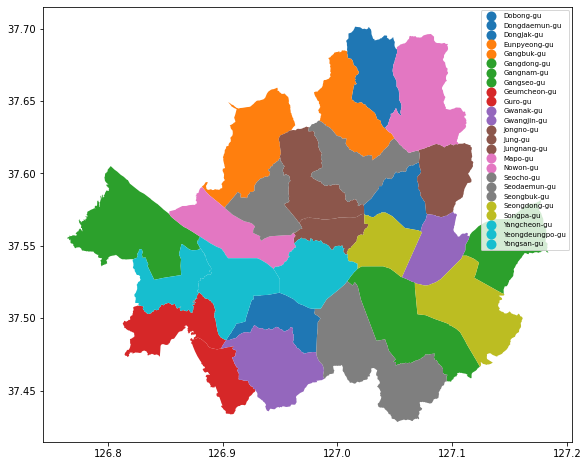

In [249]:
ax = gdf.plot("SIG_ENG_NM", legend=True, figsize=(50,8), legend_kwds={'fontsize':7})

In [250]:
ranking = pd.read_csv('ranking.csv')
ranking = ranking.drop('Unnamed: 0', axis = 1)
ranking = ranking.reset_index()

In [251]:
ranking

index  Station   PM10_Bad  PM2.5_Bad  NO2_Bad
0       0       113        93        250        8
1       1       104        74        202       11
2       2       109        65        173       37
3       3       120        61        206       27
4       4       118        60        205       22
5       5       117       151        319        2
6       6       101        50        160       24
7       7       112        67        158       10
8       8       110        68        172        7
9       9       123        61        202       10
10     10       116        80        173       26
11     11       102        52        159       21
12     12       125        98        200       17
13     13       108        99        307       15
14     14       106       112        310       15
15     15       121       104        281       49
16     16       122       161        302        4
17     17       111        89        183       26
18     18       114        62        194       18
19     19       124       101        200       18
20     20       107       126        222        9
21     21       105        84        200        4
22     22       115        76        233       29
23     23       119       131         52       10
24     24       103        46        184       12

In [252]:
plotting = gdf.reset_index(drop=True).merge(ranking.reset_index(drop=True), left_index=True, right_index=True)
plotting 

SIG_CD SIG_KOR_NM       SIG_ENG_NM  ESRI_PK  SHAPE_AREA  SHAPE_LEN  \
0   11320        도봉구        Dobong-gu        0    0.002110   0.239901   
1   11380        은평구     Eunpyeong-gu        1    0.003041   0.327143   
2   11230       동대문구    Dongdaemun-gu        2    0.001453   0.182837   
3   11590        동작구       Dongjak-gu        3    0.001670   0.237796   
4   11545        금천구     Geumcheon-gu        4    0.001325   0.211649   
5   11530        구로구          Guro-gu        5    0.002047   0.347568   
6   11110        종로구        Jongno-gu        6    0.002448   0.290100   
7   11305        강북구       Gangbuk-gu        7    0.002412   0.267441   
8   11260        중랑구      Jungnang-gu        8    0.001893   0.184716   
9   11680        강남구       Gangnam-gu        9    0.004027   0.348412   
10  11500        강서구       Gangseo-gu       10    0.004227   0.435694   
11  11140         중구          Jung-gu       11    0.001017   0.191242   
12  11740        강동구      Gangdong-gu       12    0.002504   0.242596   
13  11215        광진구      Gwangjin-gu       13    0.001737   0.186732   
14  11440        마포구          Mapo-gu       14    0.002415   0.289336   
15  11620        관악구        Gwanak-gu       15    0.003012   0.280092   
16  11650        서초구        Seocho-gu       16    0.004776   0.437399   
17  11290        성북구      Seongbuk-gu       17    0.002511   0.318673   
18  11350        노원구         Nowon-gu       18    0.003640   0.309723   
19  11710        송파구        Songpa-gu       19    0.003449   0.316773   
20  11200        성동구     Seongdong-gu       20    0.001714   0.193793   
21  11410       서대문구     Seodaemun-gu       21    0.001811   0.231131   
22  11470        양천구     Yangcheon-gu       22    0.001775   0.294094   
23  11560       영등포구  Yeongdeungpo-gu       23    0.002512   0.262953   
24  11170        용산구       Yongsan-gu       24    0.002234   0.214496   

                                             geometry  index  Station   \
0   POLYGON ((127.01985 37.70088, 127.02217 37.699...      0       113   
1   POLYGON ((126.95174 37.65489, 126.95188 37.654...      1       104   
2   POLYGON ((127.07110 37.60733, 127.07119 37.606...      2       109   
3   POLYGON ((126.95472 37.51604, 126.95556 37.515...      3       120   
4   POLYGON ((126.87994 37.48606, 126.88034 37.485...      4       118   
5   POLYGON ((126.87951 37.51778, 126.88175 37.516...      5       117   
6   POLYGON ((126.97509 37.63118, 126.97469 37.629...      6       101   
7   POLYGON ((127.00459 37.68500, 127.00555 37.684...      7       112   
8   POLYGON ((127.11132 37.62070, 127.11216 37.620...      8       110   
9   POLYGON ((127.03969 37.53584, 127.03981 37.535...      9       123   
10  POLYGON ((126.80725 37.60180, 126.80825 37.601...     10       116   
11  POLYGON ((127.02315 37.57196, 127.02337 37.571...     11       102   
12  POLYGON ((127.18163 37.55575, 127.18154 37.555...     12       125   
13  POLYGON ((127.10168 37.57241, 127.10226 37.572...     13       108   
14  POLYGON ((126.88890 37.58464, 126.88989 37.584...     14       106   
15  POLYGON ((126.92803 37.49503, 126.92823 37.494...     15       121   
16  POLYGON ((127.01319 37.52260, 127.01319 37.522...     16       122   
17  POLYGON ((126.98548 37.63594, 126.98594 37.635...     17       111   
18  POLYGON ((127.08424 37.69438, 127.08425 37.692...     18       114   
19  POLYGON ((127.11312 37.54318, 127.11306 37.542...     19       124   
20  POLYGON ((127.04343 37.57234, 127.04526 37.571...     20       107   
21  POLYGON ((126.95269 37.60274, 126.95269 37.602...     21       105   
22  POLYGON ((126.87407 37.54694, 126.87419 37.546...     22       115   
23  POLYGON ((126.88048 37.55627, 126.88141 37.555...     23       119   
24  POLYGON ((126.96920 37.55566, 126.96919 37.554...     24       103   

    PM10_Bad  PM2.5_Bad  NO2_Bad  
0         93        250        8  
1         74        202       11  
2         65        173       37  
3         61        206       27  
4   

#### PM10 Map

Text(0.5, 1.0, 'PM10 Levels')

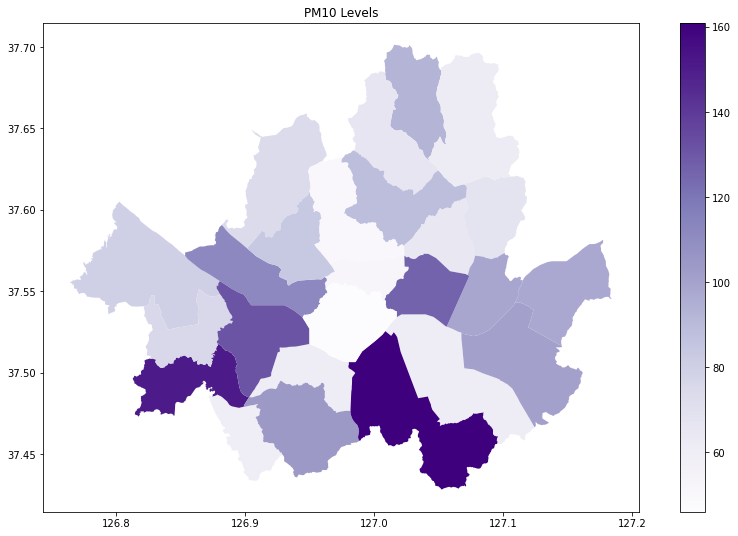

In [253]:
ax = plotting.plot(column='PM10_Bad', cmap =    
                                'Purples', figsize=(15,9),   
                                  k=3, legend =  
                                  True);
ax.set_title("PM10 Levels")

#### PM2.5 Map

Text(0.5, 1.0, 'PM2.5 Levels')

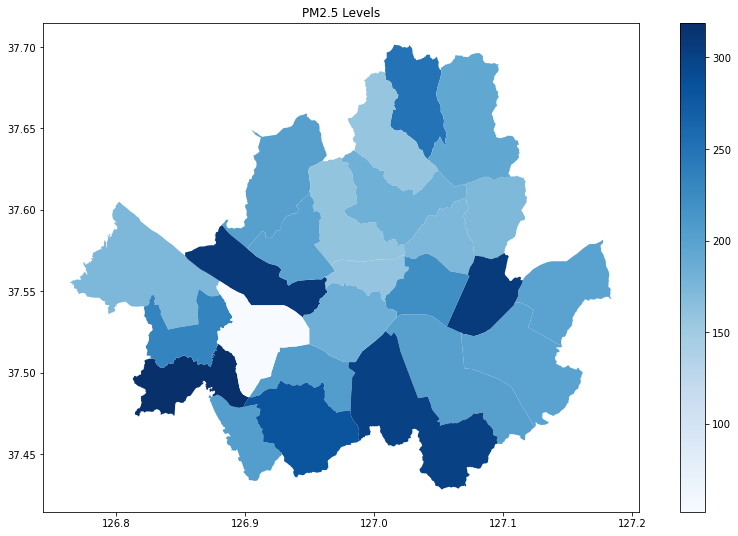

In [254]:
ax = plotting.plot(column='PM2.5_Bad', cmap =    
                                'Blues', figsize=(15,9),   
                                  k=3, legend =  
                                  True);
ax.set_title("PM2.5 Levels")

#### NO2 Map

Text(0.5, 1.0, 'NO2 Levels')

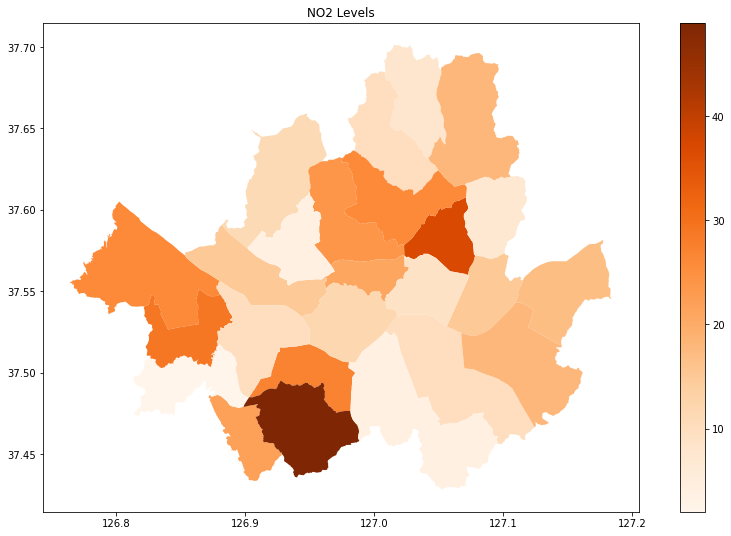

In [255]:
ax = plotting.plot(column='NO2_Bad', cmap =    
                                'Oranges', figsize=(15,9),   
                                  k=5, legend =  
                                  True);
ax.set_title("NO2 Levels")

#### Shanghi Air Quality

In [256]:
shanghi_air['date'] = pd.to_datetime(shanghi_air['date'])
shanghi_air = shanghi_air.sort_values(by="date")
shanghi_air.set_index(shanghi_air['date'], inplace=True)
shanghi_air = shanghi_air.drop('date', axis=1)
shanghi_air

pm25  pm10   o3  no2  so2   co
date                                      
2014-01-01         121   29   57   30   14
2014-01-02   188    92   39   54   17   13
2014-01-03   170   105   21   55   32   12
2014-01-04   191    94   18   36   19    9
2014-01-05   176    53   13   37   13    7
...          ...   ...  ...  ...  ...  ...
2021-01-27    90    50   38   16    2    9
2021-01-28   132    72   28   20    2   10
2021-01-29   146    62   24   13    3    6
2021-01-30    58    56   37   17    4    7
2021-01-31    69                          

[2503 rows x 6 columns]

##### Filtering to look at the years of 2017 to 2019 

In [257]:
start_remove = pd.to_datetime('2014-01-01')
end_remove = pd.to_datetime('2016-12-31')

In [258]:
shanghi_air = shanghi_air.query('index < @start_remove or index > @end_remove')
shanghi_air

pm25  pm10   o3  no2  so2   co
date                                      
2017-01-01   126    46   24   36    8    7
2017-01-02   114    63   27   33    8   10
2017-01-03   150    79   29   35    6   10
2017-01-04   178    55   28   37    8    8
2017-01-05   147    32   33   22    5    7
...          ...   ...  ...  ...  ...  ...
2021-01-27    90    50   38   16    2    9
2021-01-28   132    72   28   20    2   10
2021-01-29   146    62   24   13    3    6
2021-01-30    58    56   37   17    4    7
2021-01-31    69                          

[1483 rows x 6 columns]

In [259]:
start_remove = pd.to_datetime('2020-01-01')
end_remove = pd.to_datetime('2021-12-30')

In [260]:
shanghi_air = shanghi_air.query('index < @start_remove or index > @end_remove')
shanghi_air

pm25  pm10   o3  no2  so2   co
date                                      
2017-01-01   126    46   24   36    8    7
2017-01-02   114    63   27   33    8   10
2017-01-03   150    79   29   35    6   10
2017-01-04   178    55   28   37    8    8
2017-01-05   147    32   33   22    5    7
...          ...   ...  ...  ...  ...  ...
2019-12-26    83    32   17   22    2    9
2019-12-27    96    59   20   28    4   10
2019-12-28   155    66   32   34    4    9
2019-12-29   146    37   19   30    3    6
2019-12-30   100                          

[1088 rows x 6 columns]

In [261]:
shanghi_air[' pm25'] = pd.to_numeric(shanghi_air[' pm25'], errors='coerce').convert_dtypes() 
shanghi_air[' pm10'] = pd.to_numeric(shanghi_air[' pm10'], errors='coerce').convert_dtypes()
shanghi_air[' no2'] = pd.to_numeric(shanghi_air[' no2'], errors='coerce').convert_dtypes()
shanghi_air.dtypes                                         

<ipython-input-261-8d6cc81ecd26>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shanghi_air[' pm25'] = pd.to_numeric(shanghi_air[' pm25'], errors='coerce').convert_dtypes()
<ipython-input-261-8d6cc81ecd26>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shanghi_air[' pm10'] = pd.to_numeric(shanghi_air[' pm10'], errors='coerce').convert_dtypes()
<ipython-input-261-8d6cc81ecd26>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

 pm25     Int64
 pm10     Int64
 o3      object
 no2      Int64
 so2     object
 co      object
dtype: object

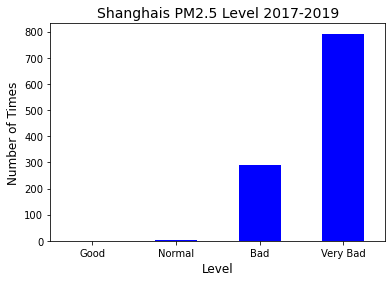

In [262]:
out = pd.cut(shanghi_air[' pm25'], bins=[0, 15, 35, 75, 500],  precision=0, labels =["Good", "Normal", "Bad", "Very Bad"])
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_title('Shanghais PM2.5 Level 2017-2019', fontsize=14)
ax.set_xlabel('Level', fontsize=12)
ax.set_ylabel('Number of Times', fontsize=12)
plt.show()

#### Shanghai Weather

In [263]:
shanghi_weather['AQI'] = pd.to_numeric(shanghi_weather['AQI'], errors='coerce').convert_dtypes()

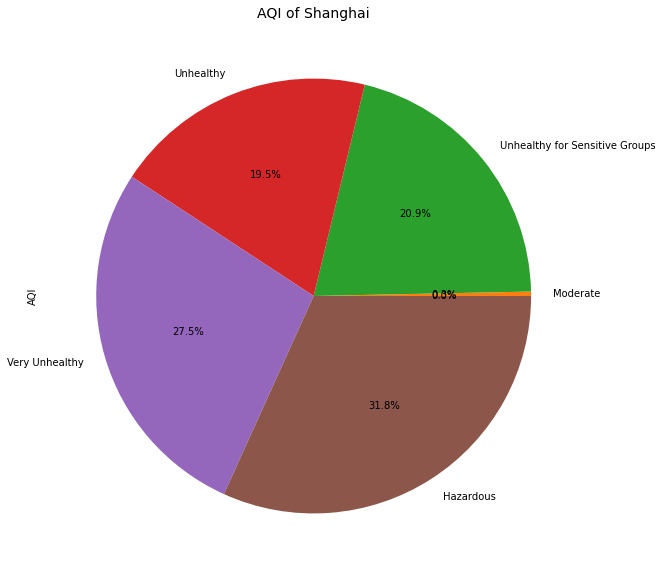

In [264]:
out = pd.cut(shanghi_weather['AQI'], bins=[0, 50, 100, 150, 200, 300, 352],  precision=0, labels =["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", 'Very Unhealthy', 'Hazardous'])
ax = out.value_counts(sort=False).plot.pie(rot=0, autopct="%.1f%%", figsize=(15,10))
ax.set_title('AQI of Shanghai', fontsize=14)
plt.show()

#### Plotting Prediction Power of Model: Worst PM10

In [265]:
train = df_122[:-542]
test = df_122[542:]

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

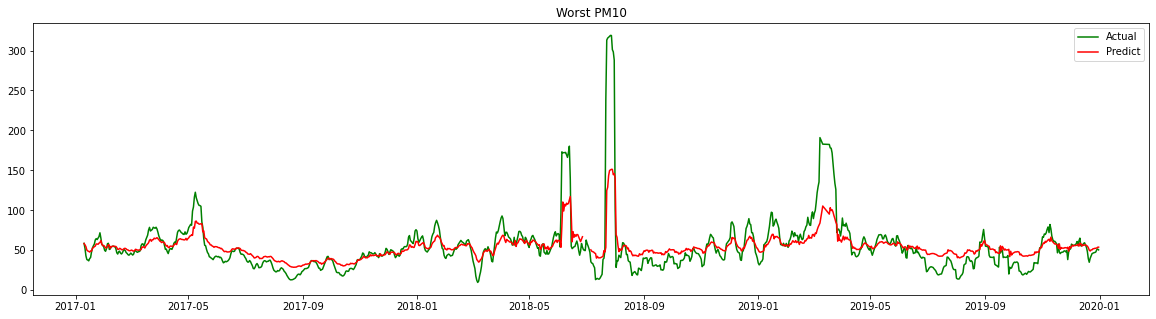

In [266]:
arima = ARIMA(train['PM10'], order=[3,0,2]).fit()
train_hat = arima.predict()

arima = ARIMA(test['PM10'], order=[3,0,2]).fit()
test_hat = arima.predict()

plt.figure(figsize=(20,5))
plt.plot(df_122.PM10.rolling(10).mean(), color='green', label="Actual")
plt.plot(train_hat.rolling(10).mean(), color='red', label="Predict")
plt.plot(test_hat.rolling(10).mean(), color='red')
plt.title('Worst PM10')
plt.legend()
plt.show()

#### Plotting Prediction Power of Model: Worst PM2.5

In [267]:
train = df_117[:-542]
test = df_117[542:]

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

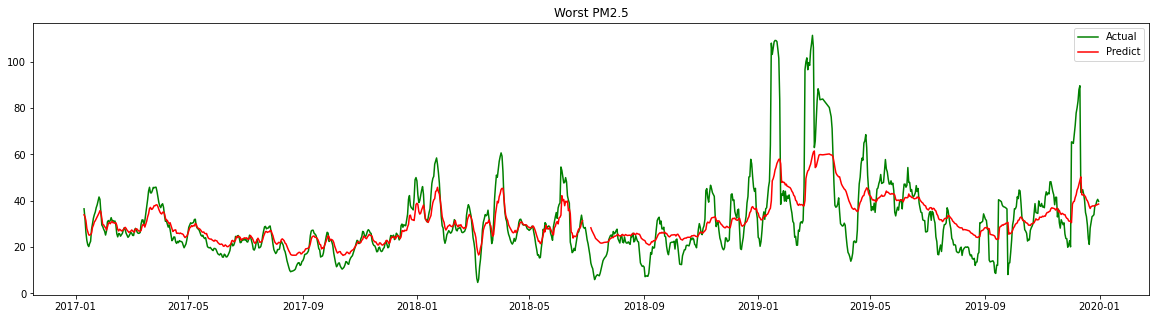

In [268]:
arima = ARIMA(train['PM2.5'], order=[3,0,2]).fit()
train_hat = arima.predict()

arima = ARIMA(test['PM2.5'], order=[3,0,2]).fit()
test_hat = arima.predict()

plt.figure(figsize=(20,5))
plt.plot(df_117['PM2.5'].rolling(10).mean(), color='green', label="Actual")
plt.plot(train_hat.rolling(10).mean(), color='red', label="Predict")
plt.plot(test_hat.rolling(10).mean(), color='red')
plt.title('Worst PM2.5')
plt.legend()
plt.show()

#### Plotting Prediction Power of Model: Worst NO2

In [269]:
train = df_121[:-542]
test = df_121[542:]

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

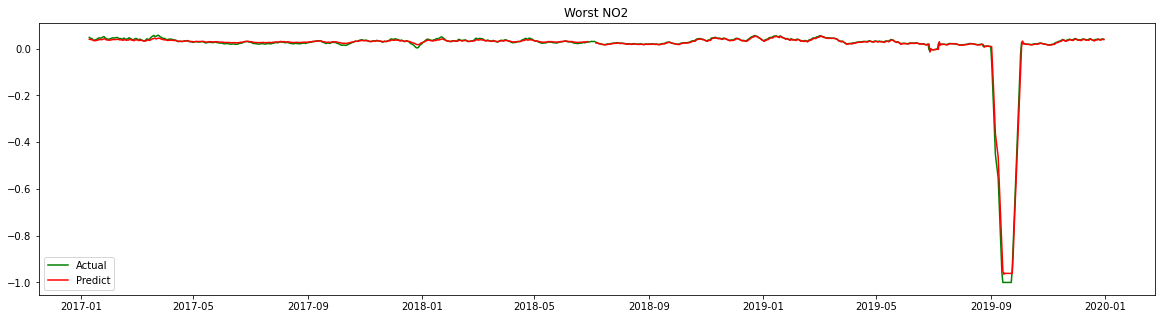

In [270]:
arima = ARIMA(train['NO2'], order=[1,0,1]).fit()
train_hat = arima.predict()

arima = ARIMA(test['NO2'], order=[1,0,1]).fit()
test_hat = arima.predict()

plt.figure(figsize=(20,5))
plt.plot(df_121['NO2'].rolling(10).mean(), color='green', label="Actual")
plt.plot(train_hat.rolling(10).mean(), color='red', label="Predict")
plt.plot(test_hat.rolling(10).mean(), color='red')
plt.title('Worst NO2')
plt.legend()
plt.show()

In [271]:
start_remove = pd.to_datetime('2017-01-01')
end_remove = pd.to_datetime('2018-12-31')

In [272]:
df_122 = df_122.query('index < @start_remove or index > @end_remove')
df_122

PM10      PM2.5
Measurement date                      
2019-01-01        35.260870  19.000000
2019-01-02        27.083333  51.916667
2019-01-03        32.666667  13.208333
2019-01-04        55.875000  31.333333
2019-01-05        58.541667  68.416667
...                     ...        ...
2019-12-27        33.291667  23.208333
2019-12-28        48.000000  26.833333
2019-12-29        50.250000  29.125000
2019-12-30        38.916667  27.291667
2019-12-31        27.458333  13.375000

[355 rows x 2 columns]

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2302.564, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2305.213, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2304.490, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2304.749, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2303.220, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2303.816, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2303.420, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2306.126, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2305.340, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2300.565, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2302.754, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2302.495, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2301.816, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

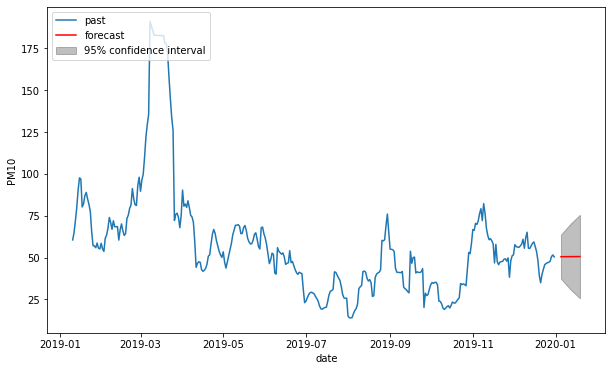

In [273]:
timeseries = df_122.PM10.rolling(10).mean()
automodel = arimamodel(df_122.PM10.rolling(10).mean().dropna())
plotarima(3, timeseries, automodel)